In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from url_parser import parse_url
import numpy as np

client = Client()

In [2]:
client 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 125.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38435,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 125.60 GiB
Comm: tcp://127.0.0.1:32963,Total threads: 4
Dashboard: http://127.0.0.1:46555/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:36933,


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

pbar = ProgressBar()
pbar.register()

In [4]:
dat = dd.read_parquet("data/output")

In [5]:
only_us = dat[(dat.Actor1Code == "USA")]
only_china = dat[(dat.Actor1Code == "CHN")]
only_russia = dat[(dat.Actor1Code == "RUS")]

In [6]:
dat.head()

,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
GLOBALEVENTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
963548206,20201211,202012,2020,2020.9342,USAEDU,UNITED STATES,USA,None,None,None,None,EDU,None,None,EDU,SCHOOL,None,None,None,None,None,EDU,None,None,0,030,030,03,1,4.0,2,1,2,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...
963548207,20210103,202101,2021,2021.0082,None,None,None,None,None,None,None,None,None,None,MIL,NATIONAL GUARD,None,None,None,None,None,MIL,None,None,1,036,036,03,1,4.0,70,5,70,-4.75240042017015,0,None,None,None,None,None,None,2,"California, United States",US,USCA,36.17,-119.746,CA,2,"California, United States",US,USCA,36.17,-119.746,CA,20210110,https://www.mdjonline.com/tribune/lifestyles/a...
963548213,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,GOV,SECRETARY OF STATE,None,None,None,None,None,GOV,None,None,0,020,020,02,1,3.0,142,38,142,-4.17371166647743,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,20210110,https://accesswdun.com/article/2021/1/969753
963548214,20210103,202101,2021,2021.0082,USA,OREGON,USA,None,None,None,None,None,None,None,USAMIL,OREGON,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,6,1,6,1.01522842639594,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,20210110,https://www.ktvb.com/article/news/health/coron...
963548215,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,USAMIL,UNITED STATES,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,4,1,4,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import re
import string
from urllib.parse import urlparse


def clean_url(inp_url:str) -> str:
    url = urlparse(inp_url)
    translation_table = str.maketrans("", "", string.digits)
    return (re.sub(' +', ' ', url.path
                .replace(".html", "")
                .replace("/", " ")
                .replace("-", " ")
                .translate(translation_table)
                .strip()))

all_features = []
all_text_features = []
country_key = []

for country, only_country in [("US",only_us.head(10000)), 
                              ("China",only_china.head(10000)), 
                              ("Russia ",only_russia.head(10000))]:
    features = only_country[["QuadClass", "GoldsteinScale", "AvgTone", "SOURCEURL"]]
    features.dropna()
    
    composite_features = []
    arr = features.to_records()#.compute()
    
    for idx, row in enumerate(tqdm(arr)):
        float_row = []
        # we don't want the global Event ID in our feature set
        for item in list(row)[1:-1]:
            try:
                float_row.append(float(item))
            # we also want to ignore any rows that contain a None
            except:
                continue
        cleaned = clean_url(row[-1])
        if cleaned != "":
            all_text_features.append(cleaned)
            all_features.append(float_row)
            
vectorizer = TfidfVectorizer(max_features=2**15)
text_vectorized = vectorizer.fit_transform(all_text_features)
for numerical_features, vec_text in zip(tqdm(all_features), text_vectorized):
    if vec_text.shape[0] == 0:
        print("ERROR 0 VEC TEXT")
#result = np.concatenate((all_features, text_vectorized), axis=1)
#print(f"Final Shape: {result.shape}")

/home/parvus/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:7974: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 6006 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:7974: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 603 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:7974: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 273 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 273/273 [00:00<00:00, 108023.11it/s]


In [12]:
X = np.array(all_features)
X.shape

(687, 60)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
print(X[0], country_key[0])

[-0.09098896  0.20735623  0.24113435  0.17685076  1.03565855  1.38321987
 -0.14003344  0.09829472  0.13042407  0.08453036  1.05047751  1.31461966
 -0.37922206 -0.79094598 -0.75991236 -0.80652722  0.89096914  0.50497891
  0.21668868  1.70459533  1.68294809  1.77018507 -1.0447276  -1.00034745
  0.50479306  1.6989172   1.67620786  1.75313098 -1.06339763 -0.24168388
 -0.38915253 -0.57490212 -0.59300276 -0.79468872  0.59864691  0.86011785
 -0.47701072 -1.1273737  -1.09306997 -0.78711466  0.01805616 -0.45272266
 -0.4705388  -1.05004004 -1.03185185 -0.74963356 -0.08016088 -0.85448733
 -0.50702578 -1.11253995 -1.09316958 -0.77996565 -0.02426351 -0.69009344
 -0.4716457  -1.08095076 -1.10110778 -0.76819357  0.01555525 -0.75477765] US


## K Means Clustering

  0%|                                                                                              | 0/295 [00:00<?, ?it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 

Initialization complete
Iteration 0, inertia 47086.141008374645.
Iteration 1, inertia 32777.66701880161.
Iteration 2, inertia 32014.662176592683.
Iteration 3, inertia 31882.036218480465.
Iteration 4, inertia 31824.468798297996.
Iteration 5, inertia 31791.96413956176.
Iteration 6, inertia 31761.792734334216.
Iteration 7, inertia 31744.43761219049.
Iteration 8, inertia 31729.459961271143.
Iteration 9, inertia 31687.12320745308.
Iteration 10, inertia 31659.65181903249.
Iteration 11, inertia 31637.39026606409.
Iteration 12, inertia 31617.606687509968.
Iteration 13, inertia 31601.73052621132.
Iteration 14, inertia 31590.103099639095.
Iteration 15, inertia 31581.33072391211.
Iteration 16, inertia 31576.699315127524.
Iteration 17, inertia 31573.480483213414.
Iteration 18, inertia 31569.896402627088.
Iteration 19, inertia 31568.750919791866.
Iteration 20, inertia 31567.56757733128.
Iteration 21, inertia 31566.568929058467.
Iteration 22, inertia 31566.251229801557.
Converged at iteration 22: st

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|██▎                                                                                   | 8/295 [00:00<00:09, 30.54it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 1, inertia 29274.2475426596.
Iteration 2, inertia 28304.24255197748.
Iteration 3, inertia 27885.60229393598.
Iteration 4, inertia 27644.873700736796.
Iteration 5, inertia 27542.252102287966.
Iteration 6, inertia 27460.03942725127.
Iteration 7, inertia 27415.14167141571.
Iteration 8, inertia 27392.128252875922.
Iteration 9, inertia 27363.40864469189.
Iteration 10, inertia 27337.16120588333.
Iteration 11, inertia 27305.85004178478.
Iteration 12, inertia 27289.681180310035.
Iteration 13, inertia 27287.030012132924.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 39232.564308441244.
Iteration 1, inertia 29441.942816587376.
Iteration 2, inertia 28685.490136114666.
Iteration 3, inertia 28246.26732720767.
Iteration 4, inertia 27997.676184130898.
Iteration 5, inertia 27891.32705471408.
Iteration 6, inertia 27835.167759951906.
Iteration 7, inertia 27797.89479009134.
Iteration 8, inertia 27776.17335522522.
Iteration 9, inertia 27758.500829584

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  4%|███▍                                                                                 | 12/295 [00:00<00:09, 28.88it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 

Iteration 17, inertia 25960.749301550968.
Iteration 18, inertia 25942.256348584662.
Iteration 19, inertia 25928.793298865705.
Iteration 20, inertia 25900.585459381735.
Iteration 21, inertia 25872.9876802548.
Iteration 22, inertia 25865.297561385993.
Iteration 23, inertia 25861.91702447471.
Converged at iteration 23: strict convergence.
Initialization complete
Iteration 0, inertia 35740.31545255678.
Iteration 1, inertia 27202.080806781585.
Iteration 2, inertia 26550.253436511823.
Iteration 3, inertia 26115.034361417012.
Iteration 4, inertia 25822.521867180247.
Iteration 5, inertia 25711.206496658153.
Iteration 6, inertia 25608.28237531405.
Iteration 7, inertia 25566.04385601141.
Iteration 8, inertia 25540.232285305905.
Iteration 9, inertia 25528.76615404965.
Iteration 10, inertia 25517.470001093323.
Iteration 11, inertia 25509.57036466548.
Iteration 12, inertia 25508.013573570643.
Iteration 13, inertia 25504.713735861686.
Iteration 14, inertia 25503.772635396836.
Converged at iteration 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  6%|█████▏                                                                               | 18/295 [00:00<00:11, 24.41it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 

Iteration 9, inertia 24590.070539485092.
Iteration 10, inertia 24573.829282733084.
Iteration 11, inertia 24550.028648744876.
Iteration 12, inertia 24527.198859649277.
Iteration 13, inertia 24516.51341137657.
Iteration 14, inertia 24514.231430174706.
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 34080.12310638245.
Iteration 1, inertia 25797.107787741897.
Iteration 2, inertia 25143.55759923463.
Iteration 3, inertia 24866.694757439418.
Iteration 4, inertia 24628.483738448514.
Iteration 5, inertia 24544.346807183916.
Iteration 6, inertia 24511.079253449745.
Iteration 7, inertia 24507.427010537886.
Iteration 8, inertia 24504.381782329285.
Iteration 9, inertia 24498.199364158605.
Iteration 10, inertia 24492.843536540506.
Iteration 11, inertia 24484.601692341774.
Iteration 12, inertia 24481.846876037926.
Iteration 13, inertia 24480.84812364564.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 33852.614546

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  7%|██████                                                                               | 21/295 [00:00<00:12, 22.65it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 

Iteration 0, inertia 32216.21121479763.
Iteration 1, inertia 24993.883322836227.
Iteration 2, inertia 24351.135431396284.
Iteration 3, inertia 24086.139575527388.
Iteration 4, inertia 23933.6369399174.
Iteration 5, inertia 23784.117567688296.
Iteration 6, inertia 23683.058306411604.
Iteration 7, inertia 23588.082209097414.
Iteration 8, inertia 23536.52589386861.
Iteration 9, inertia 23497.160964420542.
Iteration 10, inertia 23467.683428762353.
Iteration 11, inertia 23452.074488032526.
Iteration 12, inertia 23430.068169706192.
Iteration 13, inertia 23391.13682272751.
Iteration 14, inertia 23338.920658014784.
Iteration 15, inertia 23316.010111910953.
Iteration 16, inertia 23304.714470675066.
Iteration 17, inertia 23300.675523239326.
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 32566.73486463613.
Iteration 1, inertia 25290.006672306576.
Iteration 2, inertia 24397.334243192487.
Iteration 3, inertia 23918.692974112128.
Iteration 4, inertia 2369

  8%|██████▉                                                                              | 24/295 [00:01<00:13, 20.44it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  9%|███████▊                                                                             | 27/295 [00:01<00:14, 19.11it/s]

Initialization complete
Iteration 0, inertia 32330.61388430747.
Iteration 1, inertia 24541.400918160773.
Iteration 2, inertia 23648.292074912286.
Iteration 3, inertia 23420.32794520513.
Iteration 4, inertia 23335.902492441135.
Iteration 5, inertia 23266.239615269198.
Iteration 6, inertia 23212.70874494904.
Iteration 7, inertia 23164.25309107408.
Iteration 8, inertia 23109.342840252273.
Iteration 9, inertia 23071.18661569198.
Iteration 10, inertia 23023.439609398738.
Iteration 11, inertia 22987.55268341925.
Iteration 12, inertia 22975.486213610915.
Iteration 13, inertia 22961.02282682987.
Iteration 14, inertia 22942.515561963726.
Iteration 15, inertia 22923.03921989416.
Iteration 16, inertia 22918.7525897616.
Iteration 17, inertia 22911.97408286838.
Iteration 18, inertia 22906.278110680123.
Iteration 19, inertia 22900.697800861602.
Iteration 20, inertia 22895.260641494184.
Iteration 21, inertia 22892.40539901937.
Iteration 22, inertia 22890.53507005789.
Iteration 23, inertia 22889.96425

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 10%|████████▎                                                                            | 29/295 [00:01<00:14, 18.32it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 

Initialization complete
Iteration 0, inertia 30994.09244674533.
Iteration 1, inertia 23458.933442686153.
Iteration 2, inertia 22812.477402483193.
Iteration 3, inertia 22534.200247246787.
Iteration 4, inertia 22378.255253796662.
Iteration 5, inertia 22253.009028125034.
Iteration 6, inertia 22123.94112618866.
Iteration 7, inertia 22031.193647053216.
Iteration 8, inertia 21987.5135541368.
Iteration 9, inertia 21960.49724042119.
Iteration 10, inertia 21941.562808012433.
Iteration 11, inertia 21919.831642439836.
Iteration 12, inertia 21898.224433714637.
Iteration 13, inertia 21892.72818505597.
Iteration 14, inertia 21888.083090977932.
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 31761.882217558345.
Iteration 1, inertia 23429.424005146382.
Iteration 2, inertia 22627.27752591834.
Iteration 3, inertia 22426.10074398978.
Iteration 4, inertia 22336.556078965914.
Iteration 5, inertia 22261.75506377945.
Iteration 6, inertia 22221.386251008556.
Iterati

 11%|████████▉                                                                            | 31/295 [00:01<00:15, 17.49it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 11%|█████████▌                                                                           | 33/295 [00:01<00:15, 16.93it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 7, inertia 21941.741842551914.
Iteration 8, inertia 21928.193500528483.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 30761.25609976861.
Iteration 1, inertia 23189.955545207664.
Iteration 2, inertia 22347.916458796735.
Iteration 3, inertia 22013.643484683107.
Iteration 4, inertia 21882.89297959635.
Iteration 5, inertia 21821.238562275907.
Iteration 6, inertia 21793.484307045102.
Iteration 7, inertia 21765.118480868998.
Iteration 8, inertia 21715.495465496588.
Iteration 9, inertia 21687.689666876893.
Iteration 10, inertia 21675.458175371885.
Iteration 11, inertia 21664.41913963615.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 29921.38388815599.
Iteration 1, inertia 22468.552047180096.
Iteration 2, inertia 21776.38493425561.
Iteration 3, inertia 21594.727387127296.
Iteration 4, inertia 21490.2375054371.
Iteration 5, inertia 21445.788180216317.
Iteration 6, inertia 21434.995865528817.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 12%|██████████                                                                           | 35/295 [00:01<00:16, 15.97it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 10, inertia 21318.970326702478.
Iteration 11, inertia 21316.572095637348.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 29686.805751827967.
Iteration 1, inertia 22753.458359760465.
Iteration 2, inertia 21984.399168580607.
Iteration 3, inertia 21717.75243947815.
Iteration 4, inertia 21578.681125908162.
Iteration 5, inertia 21510.348845687135.
Iteration 6, inertia 21478.697805713095.
Iteration 7, inertia 21464.916819432805.
Iteration 8, inertia 21443.97078847641.
Iteration 9, inertia 21410.152673846154.
Iteration 10, inertia 21400.939944077723.
Iteration 11, inertia 21395.50451748379.
Iteration 12, inertia 21387.554446356633.
Iteration 13, inertia 21380.788268264103.
Iteration 14, inertia 21378.12486109322.
Iteration 15, inertia 21376.972138262016.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 29670.467055328438.
Iteration 1, inertia 22500.286365204043.
Iteration 2, inertia 21776.2194412

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 13%|██████████▋                                                                          | 37/295 [00:01<00:17, 15.18it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 1, inertia 22090.276321044097.
Iteration 2, inertia 21366.936146168202.
Iteration 3, inertia 21095.58843880137.
Iteration 4, inertia 20972.231264162652.
Iteration 5, inertia 20890.988046951905.
Iteration 6, inertia 20862.440346213472.
Iteration 7, inertia 20846.922725157638.
Iteration 8, inertia 20830.545363058543.
Iteration 9, inertia 20808.091547703832.
Iteration 10, inertia 20785.00251769868.
Iteration 11, inertia 20761.82000719548.
Iteration 12, inertia 20733.642078799585.
Iteration 13, inertia 20703.340993910726.
Iteration 14, inertia 20697.632804539764.
Iteration 15, inertia 20691.368914288516.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 29482.700478906037.
Iteration 1, inertia 21860.97101595574.
Iteration 2, inertia 21254.426725365694.
Iteration 3, inertia 21056.942893710806.
Iteration 4, inertia 20924.251738721305.
Iteration 5, inertia 20869.5494724583.
Iteration 6, inertia 20826.800441439183.
Iteration 7, inertia 20788.

 13%|███████████▏                                                                         | 39/295 [00:02<00:17, 14.35it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 14%|███████████▊                                                                         | 41/295 [00:02<00:18, 14.00it/s]

Initialization complete
Iteration 0, inertia 28976.413226795394.
Iteration 1, inertia 21859.051118225387.
Iteration 2, inertia 21263.97682514485.
Iteration 3, inertia 21136.671988065584.
Iteration 4, inertia 21009.6700620014.
Iteration 5, inertia 20973.580573129602.
Iteration 6, inertia 20945.11267908255.
Iteration 7, inertia 20905.235813642037.
Iteration 8, inertia 20875.23024211703.
Iteration 9, inertia 20862.885538823484.
Iteration 10, inertia 20861.134884779825.
Iteration 11, inertia 20858.50418978858.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 28834.693595653862.
Iteration 1, inertia 21954.994056097443.
Iteration 2, inertia 21286.409682363617.
Iteration 3, inertia 20995.846268154364.
Iteration 4, inertia 20829.763646220785.
Iteration 5, inertia 20793.709643634964.
Iteration 6, inertia 20780.35109374076.
Iteration 7, inertia 20764.9005520415.
Iteration 8, inertia 20748.45197500027.
Iteration 9, inertia 20727.68507321055.
Iteration 10

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 15%|████████████▍                                                                        | 43/295 [00:02<00:18, 13.43it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 28200.69894240319.
Iteration 1, inertia 21194.870874596592.
Iteration 2, inertia 20443.91137147033.
Iteration 3, inertia 20222.817337679186.
Iteration 4, inertia 20091.54973715236.
Iteration 5, inertia 20047.10156973458.
Iteration 6, inertia 20021.256468160915.
Iteration 7, inertia 20014.267084526633.
Iteration 8, inertia 20006.528588735662.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 28243.227853587057.
Iteration 1, inertia 21601.25236063386.
Iteration 2, inertia 20809.628159772958.
Iteration 3, inertia 20448.748360130503.
Iteration 4, inertia 20281.86946408698.
Iteration 5, inertia 20134.894357868037.
Iteration 6, inertia 20072.610537577388.
Iteration 7, inertia 20045.25470392278.
Iteration 8, inertia 20020.212465960532.
Iteration 9, inertia 19998.191293382624.
Iteration 10, inertia 19991.536965196105.
Iteration 11, inertia 19986.68945016347.
Iteration 12, inertia 19981.647172129302.
Iteration

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 15%|████████████▉                                                                        | 45/295 [00:02<00:19, 13.08it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 27806.94831506473.
Iteration 1, inertia 20926.13050712895.
Iteration 2, inertia 20156.703788725525.
Iteration 3, inertia 19857.411744110184.
Iteration 4, inertia 19770.926981908022.
Iteration 5, inertia 19728.62151002813.
Iteration 6, inertia 19706.2297610633.
Iteration 7, inertia 19700.857258577926.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 28027.605716004597.
Iteration 1, inertia 20823.349007193934.
Iteration 2, inertia 20307.54213342615.
Iteration 3, inertia 20100.868189454486.
Iteration 4, inertia 19998.563425445613.
Iteration 5, inertia 19889.536110554676.
Iteration 6, inertia 19835.880033306697.
Iteration 7, inertia 19776.26121755098.
Iteration 8, inertia 19745.354045126347.
Iteration 9, inertia 19735.556889365645.
Iteration 10, inertia 19714.850860359827.
Iteration 11, inertia 19711.977403165965.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia

 16%|█████████████▌                                                                       | 47/295 [00:02<00:19, 12.76it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 27368.3144033966.
Iteration 1, inertia 20591.102073859158.
Iteration 2, inertia 19880.533733158718.
Iteration 3, inertia 19671.805179778283.
Iteration 4, inertia 19624.63364524731.
Iteration 5, inertia 19609.10100993197.
Iteration 6, inertia 19602.76227224627.
Iteration 7, inertia 19589.587285294372.
Iteration 8, inertia 19576.450231685638.
Iteration 9, inertia 19565.590522462106.
Iteration 10, inertia 19560.524827256482.
Iteration 11, inertia 19557.549484755706.
Iteration 12, inertia 19556.40011426931.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 28540.054980337016.
Iteration 1, inertia 21242.29540914878.
Iteration 2, inertia 20307.258646231217.
Iteration 3, inertia 19963.152058227977.
Iteration 4, inertia 19782.206233904857.
Iteration 5, inertia 19669.585018286172.
Iteration 6, inertia 19601.29365804771.
Iteration 7, inertia 19540.83756412405.
Iteration 8, inertia 19530.372945086616.
Iteration

 17%|██████████████                                                                       | 49/295 [00:02<00:20, 12.29it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 17%|██████████████▋                                                                      | 51/295 [00:03<00:20, 11.73it/s]

Initialization complete
Iteration 0, inertia 26567.999478004003.
Iteration 1, inertia 20455.244819768133.
Iteration 2, inertia 19929.183778366936.
Iteration 3, inertia 19704.711388895437.
Iteration 4, inertia 19556.537053688186.
Iteration 5, inertia 19430.072839054432.
Iteration 6, inertia 19351.976203638817.
Iteration 7, inertia 19309.626874228485.
Iteration 8, inertia 19267.939281366733.
Iteration 9, inertia 19243.95713152395.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 27613.232501900686.
Iteration 1, inertia 20629.48150052855.
Iteration 2, inertia 19735.018414019447.
Iteration 3, inertia 19531.98396152548.
Iteration 4, inertia 19466.72394822569.
Iteration 5, inertia 19418.179366358392.
Iteration 6, inertia 19411.435585477724.
Iteration 7, inertia 19410.401172225374.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 27098.373503087143.
Iteration 1, inertia 20237.77269475649.
Iteration 2, inertia 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 18%|███████████████▎                                                                     | 53/295 [00:03<00:21, 11.35it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 27113.18243863691.
Iteration 1, inertia 20231.773277388977.
Iteration 2, inertia 19551.395131698908.
Iteration 3, inertia 19267.825956010194.
Iteration 4, inertia 19125.36374432376.
Iteration 5, inertia 19085.087876176065.
Iteration 6, inertia 19063.767538790744.
Iteration 7, inertia 19047.39524832831.
Iteration 8, inertia 19040.269376967666.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 26758.14687001908.
Iteration 1, inertia 20078.37223282918.
Iteration 2, inertia 19308.809048601746.
Iteration 3, inertia 19048.128389684618.
Iteration 4, inertia 18930.025475031478.
Iteration 5, inertia 18858.25977091729.
Iteration 6, inertia 18834.21467852741.
Iteration 7, inertia 18811.449948374753.
Iteration 8, inertia 18798.75525479768.
Iteration 9, inertia 18793.772077328056.
Iteration 10, inertia 18790.875964864208.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 2

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 19%|███████████████▊                                                                     | 55/295 [00:03<00:21, 10.99it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 2, inertia 19659.817616871387.
Iteration 3, inertia 19359.408872128068.
Iteration 4, inertia 19231.295762978247.
Iteration 5, inertia 19175.216538201792.
Iteration 6, inertia 19120.52331145249.
Iteration 7, inertia 19096.003483500066.
Iteration 8, inertia 19070.828732691625.
Iteration 9, inertia 19065.494123758584.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 26312.006577319673.
Iteration 1, inertia 19509.277899614583.
Iteration 2, inertia 18968.91043274111.
Iteration 3, inertia 18782.184353258002.
Iteration 4, inertia 18662.469048065086.
Iteration 5, inertia 18605.81148336324.
Iteration 6, inertia 18592.86592943596.
Iteration 7, inertia 18578.55471079078.
Iteration 8, inertia 18569.008692121988.
Iteration 9, inertia 18567.32161824128.
Iteration 10, inertia 18559.45987625402.
Iteration 11, inertia 18546.061717209792.
Iteration 12, inertia 18541.21633314496.
Converged at iteration 12: strict convergence.
Initialization complete
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 19%|████████████████▍                                                                    | 57/295 [00:03<00:22, 10.73it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 25911.109632336043.
Iteration 1, inertia 19518.067795116443.
Iteration 2, inertia 18893.99713808927.
Iteration 3, inertia 18615.234687741086.
Iteration 4, inertia 18514.007434202478.
Iteration 5, inertia 18452.905473381714.
Iteration 6, inertia 18434.467732300516.
Iteration 7, inertia 18431.930894491.
Iteration 8, inertia 18427.726823868714.
Iteration 9, inertia 18424.535877984978.
Iteration 10, inertia 18416.911031529868.
Iteration 11, inertia 18404.49448633911.
Iteration 12, inertia 18398.101381778135.
Iteration 13, inertia 18393.71150242682.
Iteration 14, inertia 18384.70432909196.
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 25905.555123767637.
Iteration 1, inertia 19088.18469701627.
Iteration 2, inertia 18543.775918855426.
Iteration 3, inertia 18360.529190895228.
Iteration 4, inertia 18242.62294534566.
Iteration 5, inertia 18164.293979549155.
Iteration 6, inertia 18120.03812648965.
Iteratio

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 20%|█████████████████                                                                    | 59/295 [00:03<00:22, 10.41it/s]

Initialization complete
Iteration 0, inertia 26074.723863182517.
Iteration 1, inertia 19427.78379488944.
Iteration 2, inertia 18903.03115539374.
Iteration 3, inertia 18709.062667732836.
Iteration 4, inertia 18615.657308757687.
Iteration 5, inertia 18554.16446315962.
Iteration 6, inertia 18531.84321482551.
Iteration 7, inertia 18516.015654680643.
Iteration 8, inertia 18506.18127397974.
Iteration 9, inertia 18504.609851505695.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 25255.44968859001.
Iteration 1, inertia 19617.62796648486.
Iteration 2, inertia 19010.77307555871.
Iteration 3, inertia 18745.677718794832.
Iteration 4, inertia 18608.5149166225.
Iteration 5, inertia 18525.966808433604.
Iteration 6, inertia 18472.416421590344.
Iteration 7, inertia 18432.116809863157.
Iteration 8, inertia 18416.80633940344.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 25996.19976747283.
Iteration 1, inertia 19342.5

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 21%|█████████████████▌                                                                   | 61/295 [00:04<00:23, 10.07it/s]

Initialization complete
Iteration 0, inertia 25589.175822170895.
Iteration 1, inertia 19049.663793267584.
Iteration 2, inertia 18458.515949980894.
Iteration 3, inertia 18270.99927127991.
Iteration 4, inertia 18220.053749562278.
Iteration 5, inertia 18201.313766567226.
Iteration 6, inertia 18179.343593590882.
Iteration 7, inertia 18157.03823898545.
Iteration 8, inertia 18151.46407577728.
Iteration 9, inertia 18141.88325664827.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 25284.162559975062.
Iteration 1, inertia 19111.661026062327.
Iteration 2, inertia 18507.181267884265.
Iteration 3, inertia 18329.26796925579.
Iteration 4, inertia 18251.564807782.
Iteration 5, inertia 18238.158228200737.
Iteration 6, inertia 18228.631797773684.
Iteration 7, inertia 18217.198092582996.
Iteration 8, inertia 18213.32516643191.
Iteration 9, inertia 18211.558165759317.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 2525

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 21%|██████████████████▏                                                                  | 63/295 [00:04<00:23,  9.85it/s]

Initialization complete
Iteration 0, inertia 25310.62757289081.
Iteration 1, inertia 18625.776804318266.
Iteration 2, inertia 18160.211382089354.
Iteration 3, inertia 18015.617273823464.
Iteration 4, inertia 17935.776740706166.
Iteration 5, inertia 17920.944362247374.
Iteration 6, inertia 17917.18554627285.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 24551.68103949671.
Iteration 1, inertia 18744.32567783203.
Iteration 2, inertia 18152.495538860745.
Iteration 3, inertia 17954.149707376415.
Iteration 4, inertia 17888.73545852248.
Iteration 5, inertia 17875.088643569823.
Iteration 6, inertia 17868.74597706376.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 25529.9947081944.
Iteration 1, inertia 18657.320607970447.
Iteration 2, inertia 18049.96026136659.
Iteration 3, inertia 17914.95455767465.
Iteration 4, inertia 17878.544284961477.
Iteration 5, inertia 17861.712176503817.
Iteration 6, inertia 17849

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 22%|██████████████████▍                                                                  | 64/295 [00:04<00:23,  9.69it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 24566.097220394076.
Iteration 1, inertia 18389.995368989818.
Iteration 2, inertia 17976.276673078744.
Iteration 3, inertia 17824.89130601637.
Iteration 4, inertia 17765.27947867841.
Iteration 5, inertia 17747.100774092858.
Iteration 6, inertia 17739.067801729878.
Iteration 7, inertia 17735.50337403838.
Iteration 8, inertia 17728.9570862378.
Iteration 9, inertia 17712.72867256346.
Iteration 10, inertia 17709.718315921687.
Iteration 11, inertia 17706.55541910655.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 24796.497003138156.
Iteration 1, inertia 18543.516786422268.
Iteration 2, inertia 18135.09381446496.
Iteration 3, inertia 18022.919648454186.
Iteration 4, inertia 17996.602798984317.
Iteration 5, inertia 17968.883051731234.
Iteration 6, inertia 17953.44062171582.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 24711.837483011837.
Iteration 1, inertia 1

 22%|██████████████████▋                                                                  | 65/295 [00:04<00:24,  9.47it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 22%|███████████████████                                                                  | 66/295 [00:04<00:24,  9.33it/s]

Initialization complete
Iteration 0, inertia 24928.65544351448.
Iteration 1, inertia 18408.776419966947.
Iteration 2, inertia 17842.192293954642.
Iteration 3, inertia 17683.71446996594.
Iteration 4, inertia 17616.18431709792.
Iteration 5, inertia 17582.093222360243.
Iteration 6, inertia 17550.544353184247.
Iteration 7, inertia 17527.009191040812.
Iteration 8, inertia 17519.581011372502.
Iteration 9, inertia 17515.450029925803.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 25104.954634770795.
Iteration 1, inertia 18881.64450425929.
Iteration 2, inertia 18214.472523186483.
Iteration 3, inertia 17973.892714249247.
Iteration 4, inertia 17901.698150088334.
Iteration 5, inertia 17839.40958608551.
Iteration 6, inertia 17787.20186857239.
Iteration 7, inertia 17766.919649010084.
Iteration 8, inertia 17754.685940977473.
Iteration 9, inertia 17731.485255057698.
Iteration 10, inertia 17710.7764975468.
Iteration 11, inertia 17692.46036944032.
Iteration 1

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 23%|███████████████████▎                                                                 | 67/295 [00:04<00:24,  9.15it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 23%|███████████████████▌                                                                 | 68/295 [00:04<00:25,  8.98it/s]

Initialization complete
Iteration 0, inertia 24424.27201291862.
Iteration 1, inertia 18148.235608954437.
Iteration 2, inertia 17618.773525740475.
Iteration 3, inertia 17426.498124226186.
Iteration 4, inertia 17308.72369914704.
Iteration 5, inertia 17261.45321331061.
Iteration 6, inertia 17237.17380038658.
Iteration 7, inertia 17225.36828412917.
Iteration 8, inertia 17217.60919186588.
Iteration 9, inertia 17208.56219133947.
Iteration 10, inertia 17196.371319243546.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 24528.866293581857.
Iteration 1, inertia 18106.174853812467.
Iteration 2, inertia 17524.220061270385.
Iteration 3, inertia 17319.13454648713.
Iteration 4, inertia 17237.125899522376.
Iteration 5, inertia 17179.33150870388.
Iteration 6, inertia 17170.437640346037.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 24177.705080968255.
Iteration 1, inertia 18178.668519662962.
Iteration 2, inertia 17

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 23%|███████████████████▉                                                                 | 69/295 [00:04<00:25,  8.77it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 24%|████████████████████▏                                                                | 70/295 [00:05<00:26,  8.60it/s]

Iteration 4, inertia 17244.890486073837.
Iteration 5, inertia 17225.232568142943.
Iteration 6, inertia 17216.34021750122.
Iteration 7, inertia 17210.23115922266.
Iteration 8, inertia 17204.497535415016.
Iteration 9, inertia 17203.052059956884.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 24587.057358916372.
Iteration 1, inertia 18010.118682297158.
Iteration 2, inertia 17590.74044044655.
Iteration 3, inertia 17388.88844923827.
Iteration 4, inertia 17302.54272641156.
Iteration 5, inertia 17293.561543375155.
Iteration 6, inertia 17286.39311309914.
Iteration 7, inertia 17284.42509471806.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 24384.613264809504.
Iteration 1, inertia 18184.04475619622.
Iteration 2, inertia 17519.327970953575.
Iteration 3, inertia 17335.806126504132.
Iteration 4, inertia 17257.411521630525.
Iteration 5, inertia 17214.61971138581.
Iteration 6, inertia 17191.59510976073.
Iteration

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 24%|████████████████████▍                                                                | 71/295 [00:05<00:26,  8.49it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 24395.43769557557.
Iteration 1, inertia 18199.791746548897.
Iteration 2, inertia 17562.921332754908.
Iteration 3, inertia 17356.810629492466.
Iteration 4, inertia 17291.41157629054.
Iteration 5, inertia 17220.69324426853.
Iteration 6, inertia 17183.86785320039.
Iteration 7, inertia 17170.215077345783.
Iteration 8, inertia 17152.427754089895.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 23814.285046404722.
Iteration 1, inertia 17851.84190389552.
Iteration 2, inertia 17287.409992306024.
Iteration 3, inertia 17013.501618266037.
Iteration 4, inertia 16922.83921530539.
Iteration 5, inertia 16900.954861329625.
Iteration 6, inertia 16876.222994849093.
Iteration 7, inertia 16869.716468687784.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 23947.33800315299.
Iteration 1, inertia 17992.866023867788.
Iteration 2, inertia 17508.8568102788.
Iteration 3, inertia 1739

 24%|████████████████████▋                                                                | 72/295 [00:05<00:26,  8.38it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|█████████████████████                                                                | 73/295 [00:05<00:26,  8.30it/s]

Initialization complete
Iteration 0, inertia 23992.019263076723.
Iteration 1, inertia 17980.82332284351.
Iteration 2, inertia 17482.207876943772.
Iteration 3, inertia 17333.99347166238.
Iteration 4, inertia 17313.07145630459.
Iteration 5, inertia 17293.84729022545.
Iteration 6, inertia 17288.36175564335.
Iteration 7, inertia 17285.30092649597.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 24083.1324600171.
Iteration 1, inertia 17822.99415449256.
Iteration 2, inertia 17265.882807188987.
Iteration 3, inertia 17074.87422826224.
Iteration 4, inertia 16986.250556401243.
Iteration 5, inertia 16960.27153327557.
Iteration 6, inertia 16954.98172976073.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 24292.935113664593.
Iteration 1, inertia 18132.905180897265.
Iteration 2, inertia 17550.100523706053.
Iteration 3, inertia 17406.29196837196.
Iteration 4, inertia 17293.158012363907.
Iteration 5, inertia 17280.95

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|█████████████████████▎                                                               | 74/295 [00:05<00:26,  8.25it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|█████████████████████▌                                                               | 75/295 [00:05<00:26,  8.26it/s]

Initialization complete
Iteration 0, inertia 23984.525453153958.
Iteration 1, inertia 17740.49750589068.
Iteration 2, inertia 17179.633087793813.
Iteration 3, inertia 16995.846842963874.
Iteration 4, inertia 16961.07574918914.
Iteration 5, inertia 16946.755264900024.
Iteration 6, inertia 16913.599069615644.
Iteration 7, inertia 16910.528403459724.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 23797.52458245398.
Iteration 1, inertia 17824.31388232188.
Iteration 2, inertia 17245.04861120327.
Iteration 3, inertia 16999.09205727183.
Iteration 4, inertia 16896.409126436352.
Iteration 5, inertia 16837.463063612384.
Iteration 6, inertia 16820.944761035997.
Iteration 7, inertia 16813.920715779048.
Iteration 8, inertia 16805.10745398724.
Iteration 9, inertia 16783.75716290958.
Iteration 10, inertia 16778.933730595876.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 23369.564752292936.
Iteration 1, inertia 1

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 26%|█████████████████████▉                                                               | 76/295 [00:05<00:26,  8.22it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 23271.495747584668.
Iteration 1, inertia 17435.753679900048.
Iteration 2, inertia 16862.776780425665.
Iteration 3, inertia 16756.311905200946.
Iteration 4, inertia 16718.613991187038.
Iteration 5, inertia 16705.37095199913.
Iteration 6, inertia 16699.054882582004.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 23293.278545048204.
Iteration 1, inertia 17377.748222564675.
Iteration 2, inertia 16962.168132480267.
Iteration 3, inertia 16809.216292501053.
Iteration 4, inertia 16732.1190244645.
Iteration 5, inertia 16676.647144800198.
Iteration 6, inertia 16666.11475218808.
Iteration 7, inertia 16653.759452618935.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 23509.926321621908.
Iteration 1, inertia 17290.14320840506.
Iteration 2, inertia 16813.24436685842.
Iteration 3, inertia 16702.849755075735.
Iteration 4, inertia 16695.33188435272.
Iteration 5, inertia 16

 26%|██████████████████████▏                                                              | 77/295 [00:05<00:26,  8.17it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 26%|██████████████████████▍                                                              | 78/295 [00:06<00:27,  7.94it/s]

Initialization complete
Iteration 0, inertia 23459.371044776843.
Iteration 1, inertia 17693.853951636116.
Iteration 2, inertia 17147.51135682422.
Iteration 3, inertia 17038.680892419266.
Iteration 4, inertia 16968.41333206438.
Iteration 5, inertia 16936.600308286816.
Iteration 6, inertia 16928.770547877382.
Iteration 7, inertia 16923.676950888228.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 23666.243334449344.
Iteration 1, inertia 17719.27138554943.
Iteration 2, inertia 17148.062070668526.
Iteration 3, inertia 16970.3614117003.
Iteration 4, inertia 16903.72800336329.
Iteration 5, inertia 16871.05128669287.
Iteration 6, inertia 16846.296379127274.
Iteration 7, inertia 16828.75288513461.
Iteration 8, inertia 16800.055751178446.
Iteration 9, inertia 16793.956499102926.
Iteration 10, inertia 16791.428554079088.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 22958.112365687317.
Iteration 1, inertia 1

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 27%|██████████████████████▊                                                              | 79/295 [00:06<00:27,  7.86it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 27%|███████████████████████                                                              | 80/295 [00:06<00:27,  7.81it/s]

Initialization complete
Iteration 0, inertia 23106.5063932554.
Iteration 1, inertia 17158.649394778393.
Iteration 2, inertia 16659.975596778386.
Iteration 3, inertia 16496.870327029308.
Iteration 4, inertia 16453.16602297084.
Iteration 5, inertia 16429.192577954844.
Iteration 6, inertia 16411.64590483384.
Iteration 7, inertia 16409.62054960357.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 23398.623434773446.
Iteration 1, inertia 17361.93740074.
Iteration 2, inertia 16854.40687546427.
Iteration 3, inertia 16643.283347151144.
Iteration 4, inertia 16552.002842532038.
Iteration 5, inertia 16488.87454312813.
Iteration 6, inertia 16447.745609689435.
Iteration 7, inertia 16439.797713598768.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 23568.440702132142.
Iteration 1, inertia 17245.65968898111.
Iteration 2, inertia 16711.736264623847.
Iteration 3, inertia 16606.46996933577.
Iteration 4, inertia 16557.67

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 27%|███████████████████████▎                                                             | 81/295 [00:06<00:27,  7.82it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 23349.425703214947.
Iteration 1, inertia 17518.00757746497.
Iteration 2, inertia 16962.671915816398.
Iteration 3, inertia 16791.88648846933.
Iteration 4, inertia 16719.40356196613.
Iteration 5, inertia 16675.89304792264.
Iteration 6, inertia 16649.226605643704.
Iteration 7, inertia 16627.99858964222.
Iteration 8, inertia 16602.87083215514.
Iteration 9, inertia 16591.140314165263.
Iteration 10, inertia 16590.213413290967.
Iteration 11, inertia 16587.65814084502.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 23065.21605030637.
Iteration 1, inertia 16889.918943023218.
Iteration 2, inertia 16361.095323448866.
Iteration 3, inertia 16211.638891060978.
Iteration 4, inertia 16147.342799722159.
Iteration 5, inertia 16143.909345151595.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 22859.7340657927.
Iteration 1, inertia 16972.12882131673.
Iteration 2, inertia 164

 28%|███████████████████████▋                                                             | 82/295 [00:06<00:27,  7.83it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 28%|███████████████████████▉                                                             | 83/295 [00:06<00:27,  7.76it/s]

Initialization complete
Iteration 0, inertia 23159.83627958113.
Iteration 1, inertia 16951.901557133784.
Iteration 2, inertia 16429.895896167985.
Iteration 3, inertia 16284.513013756115.
Iteration 4, inertia 16239.145751563898.
Iteration 5, inertia 16229.925859311137.
Iteration 6, inertia 16220.816843841154.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 22807.153886716624.
Iteration 1, inertia 17097.699342709515.
Iteration 2, inertia 16585.538432424117.
Iteration 3, inertia 16361.261370707527.
Iteration 4, inertia 16286.963375379639.
Iteration 5, inertia 16263.721150900747.
Iteration 6, inertia 16260.408867481237.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 22573.729283720215.
Iteration 1, inertia 17062.761204879676.
Iteration 2, inertia 16626.086422766737.
Iteration 3, inertia 16499.96720089877.
Iteration 4, inertia 16417.19608504815.
Iteration 5, inertia 16344.616680246727.
Iteration 6, inerti

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 28%|████████████████████████▏                                                            | 84/295 [00:06<00:27,  7.67it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 9, inertia 16158.30523998127.
Iteration 10, inertia 16157.345810864634.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 22718.392301836764.
Iteration 1, inertia 16973.044254813205.
Iteration 2, inertia 16393.224314574018.
Iteration 3, inertia 16224.586864253515.
Iteration 4, inertia 16160.068996290694.
Iteration 5, inertia 16129.823589413052.
Iteration 6, inertia 16115.327674005368.
Iteration 7, inertia 16113.863045978711.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 22544.00595337301.
Iteration 1, inertia 16719.14893405453.
Iteration 2, inertia 16287.267871722943.
Iteration 3, inertia 16144.122381438941.
Iteration 4, inertia 16083.601433499953.
Iteration 5, inertia 16051.000159370424.
Iteration 6, inertia 16045.729442259117.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 22785.509472770227.
Iteration 1, inertia 16992.62877918806.
Iteration 2, 

 29%|████████████████████████▍                                                            | 85/295 [00:06<00:27,  7.57it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 29%|████████████████████████▊                                                            | 86/295 [00:07<00:28,  7.34it/s]

Initialization complete
Iteration 0, inertia 22312.410713234112.
Iteration 1, inertia 16610.543407257053.
Iteration 2, inertia 16085.984139621702.
Iteration 3, inertia 15944.20139996933.
Iteration 4, inertia 15898.64500563428.
Iteration 5, inertia 15850.269642387844.
Iteration 6, inertia 15824.833232756797.
Iteration 7, inertia 15801.587337230272.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 22597.808020359218.
Iteration 1, inertia 16824.732323620334.
Iteration 2, inertia 16353.12283776173.
Iteration 3, inertia 16254.1345904702.
Iteration 4, inertia 16215.209912272603.
Iteration 5, inertia 16210.376401701902.
Iteration 6, inertia 16205.836021169947.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 22388.05587120936.
Iteration 1, inertia 16639.35108072145.
Iteration 2, inertia 16118.2131850965.
Iteration 3, inertia 15987.106445709562.
Iteration 4, inertia 15918.20055390316.
Converged at iteration 4: 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 29%|█████████████████████████                                                            | 87/295 [00:07<00:28,  7.27it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 8, inertia 16159.903776709125.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 22569.6037753299.
Iteration 1, inertia 16611.96268229436.
Iteration 2, inertia 16086.26628863714.
Iteration 3, inertia 15874.550949457865.
Iteration 4, inertia 15784.099929809643.
Iteration 5, inertia 15745.544797310436.
Iteration 6, inertia 15721.034216780658.
Iteration 7, inertia 15715.467747099567.
Iteration 8, inertia 15708.84903601907.
Iteration 9, inertia 15697.556295805292.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 21980.570666384032.
Iteration 1, inertia 16230.258265066364.
Iteration 2, inertia 15779.045656354036.
Iteration 3, inertia 15653.544509718404.
Iteration 4, inertia 15578.019754619498.
Iteration 5, inertia 15561.217477703112.
Iteration 6, inertia 15555.73836905.
Iteration 7, inertia 15554.460524684306.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia

 30%|█████████████████████████▎                                                           | 88/295 [00:07<00:28,  7.25it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 30%|█████████████████████████▋                                                           | 89/295 [00:07<00:28,  7.20it/s]

Initialization complete
Iteration 0, inertia 22249.94188915065.
Iteration 1, inertia 16388.067150885156.
Iteration 2, inertia 15935.756575012128.
Iteration 3, inertia 15833.012336405971.
Iteration 4, inertia 15802.570076503174.
Iteration 5, inertia 15801.72253784014.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 22558.154365418963.
Iteration 1, inertia 16424.674682113.
Iteration 2, inertia 15938.779263893295.
Iteration 3, inertia 15823.42776723141.
Iteration 4, inertia 15762.389405448399.
Iteration 5, inertia 15755.611254658896.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 21845.0975173249.
Iteration 1, inertia 16525.413093072693.
Iteration 2, inertia 16008.617851298535.
Iteration 3, inertia 15894.814716926314.
Iteration 4, inertia 15842.259784107668.
Iteration 5, inertia 15813.51313796632.
Iteration 6, inertia 15794.99091940936.
Iteration 7, inertia 15780.618545081843.
Iteration 8, inertia 15772

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 31%|█████████████████████████▉                                                           | 90/295 [00:07<00:28,  7.21it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 22441.657987932384.
Iteration 1, inertia 16724.02411588605.
Iteration 2, inertia 16184.959881202096.
Iteration 3, inertia 16017.59883560338.
Iteration 4, inertia 15999.863537283323.
Iteration 5, inertia 15974.976350185363.
Iteration 6, inertia 15957.361625105075.
Iteration 7, inertia 15953.140515446741.
Iteration 8, inertia 15951.843695630876.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 22193.175671266235.
Iteration 1, inertia 16164.31973272664.
Iteration 2, inertia 15732.112643220993.
Iteration 3, inertia 15611.915622400555.
Iteration 4, inertia 15585.740911964234.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 21810.31976356757.
Iteration 1, inertia 16137.924893124078.
Iteration 2, inertia 15705.014430412757.
Iteration 3, inertia 15592.299633614439.
Iteration 4, inertia 15539.62818562287.
Iteration 5, inertia 15500.529828304265.
Iteration 6, inertia 

 31%|██████████████████████████▏                                                          | 91/295 [00:07<00:28,  7.10it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 22144.018080566475.
Iteration 1, inertia 16495.465977794036.
Iteration 2, inertia 16021.655175974274.
Iteration 3, inertia 15865.180711880774.
Iteration 4, inertia 15813.768641424533.
Iteration 5, inertia 15803.211168351398.
Iteration 6, inertia 15791.55993667157.
Iteration 7, inertia 15784.327397101224.
Iteration 8, inertia 15782.008189529986.
Iteration 9, inertia 15780.71125241018.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 21724.36902684534.
Iteration 1, inertia 16001.403225788616.
Iteration 2, inertia 15619.201288398128.
Iteration 3, inertia 15535.26131341155.
Iteration 4, inertia 15522.716179273779.
Iteration 5, inertia 15515.27149724627.
Iteration 6, inertia 15513.120385499189.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 22077.34798512522.
Iteration 1, inertia 16166.425448532726.
Iteration 2, inertia 15788.338494707543.
Iteration 3, inertia 1

 31%|██████████████████████████▌                                                          | 92/295 [00:07<00:28,  7.06it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 32%|██████████████████████████▊                                                          | 93/295 [00:08<00:28,  7.02it/s]

Initialization complete
Iteration 0, inertia 21858.42786015635.
Iteration 1, inertia 16088.4039244357.
Iteration 2, inertia 15705.360335825986.
Iteration 3, inertia 15586.581140967428.
Iteration 4, inertia 15547.69350945964.
Iteration 5, inertia 15532.895353915488.
Iteration 6, inertia 15510.770637498988.
Iteration 7, inertia 15506.77522099937.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 22123.97034570984.
Iteration 1, inertia 16396.049027058973.
Iteration 2, inertia 15866.942251866527.
Iteration 3, inertia 15681.91708602662.
Iteration 4, inertia 15637.551263202935.
Iteration 5, inertia 15626.012821328586.
Iteration 6, inertia 15623.001808179793.
Iteration 7, inertia 15621.379635037567.
Iteration 8, inertia 15620.082815221704.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 21547.898469975305.
Iteration 1, inertia 15827.105682566438.
Iteration 2, inertia 15437.216682404118.
Iteration 3, inertia 15

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 32%|███████████████████████████                                                          | 94/295 [00:08<00:28,  6.98it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 21524.74011085832.
Iteration 1, inertia 15995.120106225393.
Iteration 2, inertia 15482.604003851953.
Iteration 3, inertia 15380.673559023586.
Iteration 4, inertia 15357.57745018145.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 21970.301292269527.
Iteration 1, inertia 16098.78557717386.
Iteration 2, inertia 15605.085019365522.
Iteration 3, inertia 15493.499431680022.
Iteration 4, inertia 15464.410988351274.
Iteration 5, inertia 15456.068245107888.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 21581.983794676868.
Iteration 1, inertia 15720.096115286453.
Iteration 2, inertia 15247.496882404805.
Iteration 3, inertia 15171.803323475786.
Iteration 4, inertia 15136.86971752924.
Iteration 5, inertia 15111.636004741142.
Iteration 6, inertia 15094.629943704218.
Iteration 7, inertia 15087.66301168401.
Converged at iteration 7: strict convergence.
Initialization c

 32%|███████████████████████████▎                                                         | 95/295 [00:08<00:28,  6.91it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 33%|███████████████████████████▋                                                         | 96/295 [00:08<00:29,  6.83it/s]

Initialization complete
Iteration 0, inertia 21805.35141121648.
Iteration 1, inertia 16119.546061788324.
Iteration 2, inertia 15738.991721303313.
Iteration 3, inertia 15651.544091559732.
Iteration 4, inertia 15621.222038982822.
Iteration 5, inertia 15611.37004943062.
Iteration 6, inertia 15604.123828251251.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 21349.4760996042.
Iteration 1, inertia 16094.285068492389.
Iteration 2, inertia 15625.05336229297.
Iteration 3, inertia 15348.889069179437.
Iteration 4, inertia 15271.668986840818.
Iteration 5, inertia 15216.423810430575.
Iteration 6, inertia 15207.504228838956.
Iteration 7, inertia 15204.16392098663.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 21545.196838191427.
Iteration 1, inertia 16034.071286317074.
Iteration 2, inertia 15598.511981226326.
Iteration 3, inertia 15495.817489478917.
Iteration 4, inertia 15417.708767006712.
Iteration 5, inertia 1

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 33%|███████████████████████████▉                                                         | 97/295 [00:08<00:29,  6.77it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 21340.759921242046.
Iteration 1, inertia 15855.691829152938.
Iteration 2, inertia 15475.017166580794.
Iteration 3, inertia 15348.427137287787.
Iteration 4, inertia 15281.116753331187.
Iteration 5, inertia 15248.817445555274.
Iteration 6, inertia 15227.10114358129.
Iteration 7, inertia 15223.710207323324.
Iteration 8, inertia 15222.700935606814.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 21228.228763955212.
Iteration 1, inertia 15693.455347996001.
Iteration 2, inertia 15431.949291712706.
Iteration 3, inertia 15345.676714852689.
Iteration 4, inertia 15327.176014571894.
Iteration 5, inertia 15309.487209670478.
Iteration 6, inertia 15308.62908616363.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 21169.961149292296.
Iteration 1, inertia 15800.272773047534.
Iteration 2, inertia 15304.037477327243.
Iteration 3, inertia 15154.746983513885.
Iteration 4, inert

 33%|████████████████████████████▏                                                        | 98/295 [00:08<00:29,  6.66it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 21222.756531801246.
Iteration 1, inertia 15661.96488828713.
Iteration 2, inertia 15239.275234179579.
Iteration 3, inertia 15160.744258147297.
Iteration 4, inertia 15144.53377728281.
Iteration 5, inertia 15138.13518459458.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 21171.148160821893.
Iteration 1, inertia 15725.465199026716.
Iteration 2, inertia 15300.907483639237.
Iteration 3, inertia 15167.394797835837.
Iteration 4, inertia 15028.520088321247.
Iteration 5, inertia 15008.603958455962.
Iteration 6, inertia 14985.190617280341.
Iteration 7, inertia 14969.578067516422.
Iteration 8, inertia 14960.207781335997.
Iteration 9, inertia 14957.928345355089.
Iteration 10, inertia 14956.808510315259.
Iteration 11, inertia 14951.902702798598.
Iteration 12, inertia 14950.452803729906.
Iteration 13, inertia 14948.982940445781.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, i

 34%|████████████████████████████▌                                                        | 99/295 [00:09<00:30,  6.52it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 34%|████████████████████████████▍                                                       | 100/295 [00:09<00:30,  6.50it/s]

Initialization complete
Iteration 0, inertia 21141.179518802655.
Iteration 1, inertia 15532.439771784067.
Iteration 2, inertia 15156.852296690971.
Iteration 3, inertia 15023.200833371548.
Iteration 4, inertia 14988.302120575197.
Iteration 5, inertia 14968.925294858136.
Iteration 6, inertia 14964.872268504085.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 20902.21277746194.
Iteration 1, inertia 15464.293117576217.
Iteration 2, inertia 15023.22031340342.
Iteration 3, inertia 14876.288550863504.
Iteration 4, inertia 14824.05313784414.
Iteration 5, inertia 14784.087215785928.
Iteration 6, inertia 14759.221410292435.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 21409.268477586786.
Iteration 1, inertia 15858.94316718489.
Iteration 2, inertia 15380.810305265111.
Iteration 3, inertia 15230.301077503438.
Iteration 4, inertia 15205.719222917238.
Iteration 5, inertia 15193.404252007169.
Iteration 6, inertia

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 34%|████████████████████████████▊                                                       | 101/295 [00:09<00:30,  6.45it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 21145.45840920294.
Iteration 1, inertia 15424.885429987415.
Iteration 2, inertia 15108.579899848379.
Iteration 3, inertia 15000.713952702437.
Iteration 4, inertia 14959.634528837065.
Iteration 5, inertia 14953.030998364244.
Iteration 6, inertia 14950.596226840224.
Iteration 7, inertia 14948.394696648249.
Iteration 8, inertia 14942.23752999591.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 21195.156861840445.
Iteration 1, inertia 15519.06174365487.
Iteration 2, inertia 15149.265932392982.
Iteration 3, inertia 15068.290221270954.
Iteration 4, inertia 15058.186386991916.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 20872.024514061464.
Iteration 1, inertia 15373.412774721255.
Iteration 2, inertia 14901.232386718915.
Iteration 3, inertia 14793.438613492319.
Iteration 4, inertia 14761.865288862457.
Iteration 5, inertia 14736.46537291806.
Iteration 6, inertia

 35%|█████████████████████████████                                                       | 102/295 [00:09<00:30,  6.43it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 20744.80647287654.
Iteration 1, inertia 14992.818807825983.
Iteration 2, inertia 14677.625173855982.
Iteration 3, inertia 14572.731131609386.
Iteration 4, inertia 14541.384448464627.
Iteration 5, inertia 14540.21016856725.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 20900.38417286652.
Iteration 1, inertia 15273.480731820657.
Iteration 2, inertia 14908.205063640275.
Iteration 3, inertia 14788.69482871078.
Iteration 4, inertia 14762.070381143662.
Iteration 5, inertia 14759.150154544439.
Iteration 6, inertia 14755.602904820316.
Iteration 7, inertia 14752.72609665558.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 20824.08317637284.
Iteration 1, inertia 15343.741143369703.
Iteration 2, inertia 14989.785904497301.
Iteration 3, inertia 14900.518426541394.
Iteration 4, inertia 14876.467435250515.
Iteration 5, inertia 14866.371791517964.
Converged at iteration

 35%|█████████████████████████████▎                                                      | 103/295 [00:09<00:30,  6.38it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 35%|█████████████████████████████▌                                                      | 104/295 [00:09<00:30,  6.35it/s]

Initialization complete
Iteration 0, inertia 21009.529601332553.
Iteration 1, inertia 15264.01303761124.
Iteration 2, inertia 14908.33443649374.
Iteration 3, inertia 14851.598035638548.
Iteration 4, inertia 14842.746419230152.
Iteration 5, inertia 14840.919721168379.
Iteration 6, inertia 14837.371183731164.
Iteration 7, inertia 14832.850917595508.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 21266.388632544564.
Iteration 1, inertia 15441.849083911524.
Iteration 2, inertia 15064.185468815802.
Iteration 3, inertia 14957.7841738986.
Iteration 4, inertia 14913.311829672877.
Iteration 5, inertia 14894.178981692072.
Iteration 6, inertia 14885.245726481535.
Iteration 7, inertia 14879.834184943935.
Iteration 8, inertia 14875.006041282139.
Iteration 9, inertia 14871.566156374489.
Iteration 10, inertia 14868.374786423352.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 20575.157926297863.
Iteration 1, inert

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 36%|█████████████████████████████▉                                                      | 105/295 [00:09<00:30,  6.25it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 20911.903471588394.
Iteration 1, inertia 15408.804884454868.
Iteration 2, inertia 14909.310754700007.
Iteration 3, inertia 14788.011061091202.
Iteration 4, inertia 14765.583007844669.
Iteration 5, inertia 14750.101262384682.
Iteration 6, inertia 14741.111938296033.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 20685.163248343142.
Iteration 1, inertia 15052.786325530444.
Iteration 2, inertia 14646.513482217264.
Iteration 3, inertia 14544.780478981074.
Iteration 4, inertia 14517.676073311488.
Iteration 5, inertia 14505.206135673663.
Iteration 6, inertia 14497.594241686387.
Iteration 7, inertia 14496.560168735354.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 20597.339881489836.
Iteration 1, inertia 15126.585231140756.
Iteration 2, inertia 14714.306812201597.
Iteration 3, inertia 14641.65916851797.
Iteration 4, inertia 14627.980575791713.
Iteration 5, iner

 36%|██████████████████████████████▏                                                     | 106/295 [00:10<00:30,  6.19it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 20572.201689826245.
Iteration 1, inertia 15082.981450750436.
Iteration 2, inertia 14513.617248084745.
Iteration 3, inertia 14427.97247396145.
Iteration 4, inertia 14409.136788485423.
Iteration 5, inertia 14406.431420727218.
Iteration 6, inertia 14402.360675786782.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 20337.375965312694.
Iteration 1, inertia 14999.446135418257.
Iteration 2, inertia 14624.864827438523.
Iteration 3, inertia 14523.443277630093.
Iteration 4, inertia 14497.545888493523.
Iteration 5, inertia 14481.460040534685.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 20838.453359523213.
Iteration 1, inertia 15067.358299587588.
Iteration 2, inertia 14616.800234008693.
Iteration 3, inertia 14496.065253828907.
Iteration 4, inertia 14436.54321250111.
Iteration 5, inertia 14423.548552191947.
Iteration 6, inertia 14418.813449643936.
Converged at itera

 36%|██████████████████████████████▍                                                     | 107/295 [00:10<00:30,  6.12it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 20389.65490239746.
Iteration 1, inertia 15004.722920475955.
Iteration 2, inertia 14614.330906952358.
Iteration 3, inertia 14467.781755382812.
Iteration 4, inertia 14416.604589393084.
Iteration 5, inertia 14398.640993388408.
Iteration 6, inertia 14386.35696490038.
Iteration 7, inertia 14365.537658349785.
Iteration 8, inertia 14352.166081771897.
Iteration 9, inertia 14335.078564446736.
Iteration 10, inertia 14322.612339069017.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 20366.618331985977.
Iteration 1, inertia 14940.460571253214.
Iteration 2, inertia 14481.035473948163.
Iteration 3, inertia 14345.100150169057.
Iteration 4, inertia 14305.591085326832.
Iteration 5, inertia 14293.595633331814.
Iteration 6, inertia 14288.675974964572.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 20546.06069341914.
Iteration 1, inertia 15251.692514462105.
Iteration 2, iner

 37%|██████████████████████████████▊                                                     | 108/295 [00:10<00:30,  6.08it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 20385.279303671006.
Iteration 1, inertia 15048.026424162359.
Iteration 2, inertia 14644.261574028977.
Iteration 3, inertia 14535.662720759097.
Iteration 4, inertia 14498.970964040089.
Iteration 5, inertia 14472.968506463041.
Iteration 6, inertia 14458.348728770488.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 20444.53256756876.
Iteration 1, inertia 14699.068431357899.
Iteration 2, inertia 14274.396082794814.
Iteration 3, inertia 14172.165169546666.
Iteration 4, inertia 14159.843665276878.
Iteration 5, inertia 14150.012285855348.
Iteration 6, inertia 14141.261925374236.
Iteration 7, inertia 14136.186233956336.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 20286.223787386443.
Iteration 1, inertia 14946.702937913944.
Iteration 2, inertia 14591.82832345481.
Iteration 3, inertia 14477.09292308802.
Iteration 4, inertia 14431.812790502794.
Iteration 5, inerti

 37%|███████████████████████████████                                                     | 109/295 [00:10<00:30,  6.05it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 37%|███████████████████████████████▎                                                    | 110/295 [00:10<00:30,  6.06it/s]

Iteration 2, inertia 14641.286064037848.
Iteration 3, inertia 14535.291741064011.
Iteration 4, inertia 14495.587273348629.
Iteration 5, inertia 14461.913011836537.
Iteration 6, inertia 14442.525768664937.
Iteration 7, inertia 14441.566067344775.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 20504.599856929.
Iteration 1, inertia 15063.299567418093.
Iteration 2, inertia 14561.277346471144.
Iteration 3, inertia 14441.894286645693.
Iteration 4, inertia 14400.958762591716.
Iteration 5, inertia 14385.477017131729.
Iteration 6, inertia 14376.48769304308.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 20352.072955753538.
Iteration 1, inertia 14954.817698940524.
Iteration 2, inertia 14556.52912629449.
Iteration 3, inertia 14396.128825786824.
Iteration 4, inertia 14333.509630854225.
Iteration 5, inertia 14321.71230634701.
Iteration 6, inertia 14317.753991536198.
Iteration 7, inertia 14314.844588735808.
Itera

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 38%|███████████████████████████████▌                                                    | 111/295 [00:10<00:30,  6.02it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 4, inertia 14311.074343263073.
Iteration 5, inertia 14273.566887208974.
Iteration 6, inertia 14245.020927949048.
Iteration 7, inertia 14224.650537216487.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 20249.028594960942.
Iteration 1, inertia 14718.04562739126.
Iteration 2, inertia 14369.33195910596.
Iteration 3, inertia 14284.50938281111.
Iteration 4, inertia 14269.160774125796.
Iteration 5, inertia 14267.174660128923.
Iteration 6, inertia 14263.342278324499.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 20367.220937002505.
Iteration 1, inertia 14724.387518600115.
Iteration 2, inertia 14407.221159522747.
Iteration 3, inertia 14335.050688671015.
Iteration 4, inertia 14307.9166441782.
Iteration 5, inertia 14301.60136000397.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 20142.225056276155.
Iteration 1, inertia 14758.89326964307.
Iteration 2, inert

 38%|███████████████████████████████▉                                                    | 112/295 [00:11<00:30,  5.95it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 19751.625536006835.
Iteration 1, inertia 14840.363905320059.
Iteration 2, inertia 14476.863310720668.
Iteration 3, inertia 14370.864426995162.
Iteration 4, inertia 14320.632924602778.
Iteration 5, inertia 14316.89281897358.
Iteration 6, inertia 14309.473265191555.
Iteration 7, inertia 14302.982764519224.
Iteration 8, inertia 14294.034584073072.
Iteration 9, inertia 14285.074071606048.
Iteration 10, inertia 14282.66736508844.
Iteration 11, inertia 14280.984573982067.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 20114.71830214675.
Iteration 1, inertia 14862.006022061183.
Iteration 2, inertia 14430.512187147011.
Iteration 3, inertia 14269.428532020394.
Iteration 4, inertia 14224.443701569564.
Iteration 5, inertia 14220.211123161887.
Iteration 6, inertia 14203.454133351448.
Iteration 7, inertia 14191.791584370734.
Iteration 8, inertia 14169.480998684494.
Iteration 9, inertia 14161.344798072136.
Conv

 38%|████████████████████████████████▏                                                   | 113/295 [00:11<00:30,  5.94it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 20337.006235008368.
Iteration 1, inertia 14596.42610472024.
Iteration 2, inertia 14116.148996920916.
Iteration 3, inertia 13989.994059535535.
Iteration 4, inertia 13952.400570242173.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 19852.584151105362.
Iteration 1, inertia 14727.69668523357.
Iteration 2, inertia 14334.407245680231.
Iteration 3, inertia 14220.37495959394.
Iteration 4, inertia 14182.151279094265.
Iteration 5, inertia 14143.153071895491.
Iteration 6, inertia 14140.599341031846.
Iteration 7, inertia 14133.860692923325.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 19696.324372598392.
Iteration 1, inertia 14667.339576509654.
Iteration 2, inertia 14289.46170704767.
Iteration 3, inertia 14145.249378669258.
Iteration 4, inertia 14064.587760182125.
Iteration 5, inertia 14027.410260122519.
Iteration 6, inertia 14021.157833782056.
Iteration 7, inertia

 39%|████████████████████████████████▍                                                   | 114/295 [00:11<00:30,  5.92it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 19864.90137530896.
Iteration 1, inertia 14448.814650643946.
Iteration 2, inertia 14027.637798761394.
Iteration 3, inertia 13946.015820966826.
Iteration 4, inertia 13929.293127915205.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 20010.640461416944.
Iteration 1, inertia 14365.871074205766.
Iteration 2, inertia 13995.477994430925.
Iteration 3, inertia 13917.343348114699.
Iteration 4, inertia 13886.709142715396.
Iteration 5, inertia 13877.953312389727.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19828.581417418907.
Iteration 1, inertia 14427.408584943933.
Iteration 2, inertia 14195.072939112533.
Iteration 3, inertia 14145.203022629956.
Iteration 4, inertia 14126.57194278244.
Iteration 5, inertia 14122.617680094583.
Iteration 6, inertia 14119.060340363018.
Iteration 7, inertia 14117.958974804247.
Converged at iteration 7: strict convergence.
Initializatio

 39%|████████████████████████████████▋                                                   | 115/295 [00:11<00:30,  5.85it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 39%|█████████████████████████████████                                                   | 116/295 [00:11<00:30,  5.83it/s]

Initialization complete
Iteration 0, inertia 19914.63627099425.
Iteration 1, inertia 14379.572834712533.
Iteration 2, inertia 13975.580989261614.
Iteration 3, inertia 13874.576841436707.
Iteration 4, inertia 13854.823316387521.
Iteration 5, inertia 13853.665783797274.
Iteration 6, inertia 13849.143336020557.
Iteration 7, inertia 13844.651098383936.
Iteration 8, inertia 13841.614954009818.
Iteration 9, inertia 13840.143310418898.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 19997.39922248202.
Iteration 1, inertia 14654.174336030243.
Iteration 2, inertia 14168.766499487949.
Iteration 3, inertia 14058.238436275335.
Iteration 4, inertia 14013.583898361723.
Iteration 5, inertia 14009.659202009178.
Iteration 6, inertia 14003.631894085594.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 19780.914713632523.
Iteration 1, inertia 14544.255782892566.
Iteration 2, inertia 14134.292162030557.
Iteration 3, inert

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 40%|█████████████████████████████████▎                                                  | 117/295 [00:12<00:30,  5.75it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 19664.164257404675.
Iteration 1, inertia 14275.555426500536.
Iteration 2, inertia 13910.334788637665.
Iteration 3, inertia 13844.720155746503.
Iteration 4, inertia 13812.701059511408.
Iteration 5, inertia 13807.674510096349.
Iteration 6, inertia 13805.788253524988.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 19763.92616819039.
Iteration 1, inertia 14293.674738037247.
Iteration 2, inertia 13951.876189252804.
Iteration 3, inertia 13869.709261256852.
Iteration 4, inertia 13799.206565774735.
Iteration 5, inertia 13791.13879817717.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19838.061736829022.
Iteration 1, inertia 14201.080562056159.
Iteration 2, inertia 13803.829957546623.
Iteration 3, inertia 13717.744001888012.
Iteration 4, inertia 13701.24217510219.
Iteration 5, inertia 13699.127679279396.
Iteration 6, inertia 13695.303609424194.
Converged at iterat

 40%|█████████████████████████████████▌                                                  | 118/295 [00:12<00:31,  5.69it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 6, inertia 14090.413407073376.
Iteration 7, inertia 14070.825259858559.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 19446.67736904685.
Iteration 1, inertia 14227.098572069972.
Iteration 2, inertia 13745.821479608465.
Iteration 3, inertia 13579.904718857228.
Iteration 4, inertia 13547.68316917975.
Iteration 5, inertia 13544.855137367364.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19456.555134308142.
Iteration 1, inertia 14156.58435799256.
Iteration 2, inertia 13915.239396220128.
Iteration 3, inertia 13846.48390355557.
Iteration 4, inertia 13797.862367695066.
Iteration 5, inertia 13778.181296170114.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19484.997866970083.
Iteration 1, inertia 14367.82984268763.
Iteration 2, inertia 14014.775911833764.
Iteration 3, inertia 13899.321314296832.
Iteration 4, inertia 13884.788455436768.
Iteration 5, ine

 40%|█████████████████████████████████▉                                                  | 119/295 [00:12<00:31,  5.62it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 19736.046206877672.
Iteration 1, inertia 14303.454497050981.
Iteration 2, inertia 13963.204804506775.
Iteration 3, inertia 13880.976583300595.
Iteration 4, inertia 13831.498157395545.
Iteration 5, inertia 13812.925914431211.
Iteration 6, inertia 13807.963933050865.
Iteration 7, inertia 13801.777452951017.
Iteration 8, inertia 13797.662571099143.
Iteration 9, inertia 13793.163022077091.
Iteration 10, inertia 13791.624972437574.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 19739.402589013516.
Iteration 1, inertia 14383.792450470424.
Iteration 2, inertia 13969.539394267274.
Iteration 3, inertia 13847.800799577706.
Iteration 4, inertia 13785.388660071365.
Iteration 5, inertia 13751.083232539127.
Iteration 6, inertia 13735.108239079667.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 19671.831917890737.
Iteration 1, inertia 14118.678306423564.
Iteration 2, i

 41%|██████████████████████████████████▏                                                 | 120/295 [00:12<00:31,  5.57it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 1, inertia 14160.219849418967.
Iteration 2, inertia 13843.85406382519.
Iteration 3, inertia 13744.445233163638.
Iteration 4, inertia 13701.711653486998.
Iteration 5, inertia 13672.774194191481.
Iteration 6, inertia 13667.006260497035.
Iteration 7, inertia 13659.679662463712.
Iteration 8, inertia 13657.978608668453.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 19479.817250587974.
Iteration 1, inertia 14160.74528832553.
Iteration 2, inertia 13842.911549156835.
Iteration 3, inertia 13732.036255021583.
Iteration 4, inertia 13666.484197840899.
Iteration 5, inertia 13639.582644440106.
Iteration 6, inertia 13619.193921955188.
Iteration 7, inertia 13597.515880634091.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 19265.04485245771.
Iteration 1, inertia 14143.31271052542.
Iteration 2, inertia 13785.868202060168.
Iteration 3, inertia 13676.153401005626.
Iteration 4, inertia 13655.496278874902.
Ite

 41%|██████████████████████████████████▍                                                 | 121/295 [00:12<00:31,  5.58it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 19567.1522250408.
Iteration 1, inertia 14015.748825391875.
Iteration 2, inertia 13714.087770873404.
Iteration 3, inertia 13613.377368933572.
Iteration 4, inertia 13581.594404955014.
Iteration 5, inertia 13569.562953677641.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19425.35837951045.
Iteration 1, inertia 14087.748688235215.
Iteration 2, inertia 13680.710084691138.
Iteration 3, inertia 13572.027246319989.
Iteration 4, inertia 13511.780280852616.
Iteration 5, inertia 13482.518927623012.
Iteration 6, inertia 13466.404206000225.
Iteration 7, inertia 13462.901808129944.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 19754.64223696055.
Iteration 1, inertia 14217.341582426598.
Iteration 2, inertia 13790.206002327868.
Iteration 3, inertia 13685.937319461278.
Iteration 4, inertia 13661.088964149934.
Iteration 5, inertia 13641.686993278723.
Iteration 6, inertia

 41%|██████████████████████████████████▋                                                 | 122/295 [00:12<00:31,  5.54it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 19364.73492271962.
Iteration 1, inertia 14127.780716820977.
Iteration 2, inertia 13805.558056255297.
Iteration 3, inertia 13727.516179175445.
Iteration 4, inertia 13691.826160225291.
Iteration 5, inertia 13686.747277353546.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19362.626172367018.
Iteration 1, inertia 14255.568333650901.
Iteration 2, inertia 13904.871277988077.
Iteration 3, inertia 13751.23308655482.
Iteration 4, inertia 13722.373243337146.
Iteration 5, inertia 13717.020531309694.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19562.355271186756.
Iteration 1, inertia 14308.753830830785.
Iteration 2, inertia 13875.437603631775.
Iteration 3, inertia 13762.33985971044.
Iteration 4, inertia 13729.89106312446.
Iteration 5, inertia 13721.180276193963.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19286.90018

 42%|███████████████████████████████████                                                 | 123/295 [00:13<00:31,  5.40it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 42%|███████████████████████████████████▎                                                | 124/295 [00:13<00:31,  5.45it/s]

Initialization complete
Iteration 0, inertia 19224.724944210564.
Iteration 1, inertia 13901.236246902443.
Iteration 2, inertia 13445.23178919275.
Iteration 3, inertia 13344.260035440562.
Iteration 4, inertia 13312.161957286737.
Iteration 5, inertia 13304.62117206572.
Iteration 6, inertia 13298.517718523979.
Iteration 7, inertia 13285.438208338932.
Iteration 8, inertia 13265.68959573873.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 19459.94487878925.
Iteration 1, inertia 14235.850492904303.
Iteration 2, inertia 13817.102054181605.
Iteration 3, inertia 13692.928585559654.
Iteration 4, inertia 13667.268332683885.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 18901.286517330474.
Iteration 1, inertia 13913.29347139278.
Iteration 2, inertia 13585.968089207692.
Iteration 3, inertia 13454.006597404501.
Iteration 4, inertia 13396.072946618015.
Iteration 5, inertia 13371.678395177802.
Iteration 6, inertia 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 42%|███████████████████████████████████▌                                                | 125/295 [00:13<00:31,  5.41it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 19399.018525322543.
Iteration 1, inertia 14169.941050192449.
Iteration 2, inertia 13737.639139397228.
Iteration 3, inertia 13587.025479198177.
Iteration 4, inertia 13564.59925134978.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 19136.442797877164.
Iteration 1, inertia 13827.43975528213.
Iteration 2, inertia 13394.975346134432.
Iteration 3, inertia 13309.920501775165.
Iteration 4, inertia 13282.292132774086.
Iteration 5, inertia 13276.51182635599.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18989.634108189235.
Iteration 1, inertia 13837.607517039041.
Iteration 2, inertia 13478.865712311175.
Iteration 3, inertia 13416.480053780648.
Iteration 4, inertia 13369.222601372256.
Iteration 5, inertia 13331.428611320767.
Iteration 6, inertia 13319.418028418184.
Iteration 7, inertia 13311.897503864371.
Iteration 8, inertia 13306.513748863232.
Iteration 9, inerti

 43%|███████████████████████████████████▉                                                | 126/295 [00:13<00:31,  5.40it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 19015.901210471926.
Iteration 1, inertia 13852.820377000782.
Iteration 2, inertia 13451.05933917424.
Iteration 3, inertia 13299.997456276344.
Iteration 4, inertia 13267.510696424795.
Iteration 5, inertia 13252.968297332673.
Iteration 6, inertia 13239.958817264636.
Iteration 7, inertia 13230.049063971715.
Iteration 8, inertia 13218.7306620058.
Iteration 9, inertia 13211.773361537942.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 19012.640295643338.
Iteration 1, inertia 13690.104721616375.
Iteration 2, inertia 13343.130519597933.
Iteration 3, inertia 13275.74438299148.
Iteration 4, inertia 13259.421398690167.
Iteration 5, inertia 13254.912308366995.
Iteration 6, inertia 13248.544714665039.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 19105.28332743357.
Iteration 1, inertia 13815.386619985346.
Iteration 2, inertia 13417.176329522385.
Iteration 3, inertia 

 43%|████████████████████████████████████▏                                               | 127/295 [00:13<00:31,  5.35it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 18835.845045087233.
Iteration 1, inertia 13556.892713514668.
Iteration 2, inertia 13230.853016336434.
Iteration 3, inertia 13143.301282537985.
Iteration 4, inertia 13138.493316487586.
Iteration 5, inertia 13134.748651441994.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 19016.478919533212.
Iteration 1, inertia 13759.324906125095.
Iteration 2, inertia 13425.403611246538.
Iteration 3, inertia 13343.737713341545.
Iteration 4, inertia 13319.497680792037.
Iteration 5, inertia 13312.334694191795.
Iteration 6, inertia 13308.89217848049.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 18906.463662213922.
Iteration 1, inertia 13472.519537924085.
Iteration 2, inertia 13215.91018995798.
Iteration 3, inertia 13158.576760335742.
Iteration 4, inertia 13143.407236161418.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 18665.763

 43%|████████████████████████████████████▍                                               | 128/295 [00:14<00:31,  5.30it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 18548.20348613658.
Iteration 1, inertia 13630.958091044347.
Iteration 2, inertia 13318.20886174645.
Iteration 3, inertia 13233.70518766157.
Iteration 4, inertia 13199.362424728486.
Iteration 5, inertia 13192.22631797866.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18852.38753931715.
Iteration 1, inertia 13546.867542844288.
Iteration 2, inertia 13305.288739957152.
Iteration 3, inertia 13202.716393959792.
Iteration 4, inertia 13165.496402135039.
Iteration 5, inertia 13156.09800115218.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18881.184232948584.
Iteration 1, inertia 13555.447703204054.
Iteration 2, inertia 13273.124779327925.
Iteration 3, inertia 13224.86691596073.
Iteration 4, inertia 13201.564591467115.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 18536.989060957385.
Iteration 1, inertia 13441.75338360

 44%|████████████████████████████████████▋                                               | 129/295 [00:14<00:31,  5.31it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 18640.345785692545.
Iteration 1, inertia 13670.141249260369.
Iteration 2, inertia 13270.123031695062.
Iteration 3, inertia 13161.95326259981.
Iteration 4, inertia 13119.618803203679.
Iteration 5, inertia 13106.153000994611.
Iteration 6, inertia 13104.52238120762.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 18803.602829526506.
Iteration 1, inertia 13627.286202917852.
Iteration 2, inertia 13259.589731911416.
Iteration 3, inertia 13169.358316642994.
Iteration 4, inertia 13159.809012986374.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 18578.41431054675.
Iteration 1, inertia 13703.097844541535.
Iteration 2, inertia 13352.376423979196.
Iteration 3, inertia 13255.261204951186.
Iteration 4, inertia 13208.640065867205.
Iteration 5, inertia 13191.912640389337.
Iteration 6, inertia 13176.699366356566.
Iteration 7, inertia 13173.639413659293.
Converged at iterat

 44%|█████████████████████████████████████                                               | 130/295 [00:14<00:31,  5.30it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 18839.4824204624.
Iteration 1, inertia 13632.603454584782.
Iteration 2, inertia 13310.303258050455.
Iteration 3, inertia 13218.553325519637.
Iteration 4, inertia 13188.916114946449.
Iteration 5, inertia 13183.406331440718.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18837.810036233182.
Iteration 1, inertia 13876.875754586203.
Iteration 2, inertia 13516.691128502236.
Iteration 3, inertia 13349.6471936306.
Iteration 4, inertia 13317.99910628557.
Iteration 5, inertia 13314.090356919332.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18779.587690588003.
Iteration 1, inertia 13664.522221585283.
Iteration 2, inertia 13363.64555115826.
Iteration 3, inertia 13289.658941573562.
Iteration 4, inertia 13267.87066007254.
Iteration 5, inertia 13256.3537840878.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18695.1805824765

 44%|█████████████████████████████████████▎                                              | 131/295 [00:14<00:31,  5.21it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 18716.95658085736.
Iteration 1, inertia 13623.04718006634.
Iteration 2, inertia 13315.75495528978.
Iteration 3, inertia 13290.686357093555.
Iteration 4, inertia 13282.2182124035.
Iteration 5, inertia 13278.668953733493.
Iteration 6, inertia 13278.02432073274.
Iteration 7, inertia 13276.335318137028.
Iteration 8, inertia 13266.384955694997.
Iteration 9, inertia 13258.894428316189.
Iteration 10, inertia 13255.993321203465.
Iteration 11, inertia 13253.466770839645.
Iteration 12, inertia 13248.95499891454.
Iteration 13, inertia 13241.358260285218.
Iteration 14, inertia 13236.678448410139.
Iteration 15, inertia 13231.552488171437.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 18872.51773778038.
Iteration 1, inertia 13687.96454661832.
Iteration 2, inertia 13296.7176815579.
Iteration 3, inertia 13232.86269244481.
Iteration 4, inertia 13215.426054820724.
Iteration 5, inertia 13211.267829673106.
Converged

 45%|█████████████████████████████████████▌                                              | 132/295 [00:14<00:31,  5.22it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 18455.033842702112.
Iteration 1, inertia 13344.32965873875.
Iteration 2, inertia 12888.399897354946.
Iteration 3, inertia 12788.94101467249.
Iteration 4, inertia 12754.712164040471.
Iteration 5, inertia 12730.59492855456.
Iteration 6, inertia 12719.759792722727.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 18650.677835499446.
Iteration 1, inertia 13666.823038382618.
Iteration 2, inertia 13354.116555781115.
Iteration 3, inertia 13283.96893260414.
Iteration 4, inertia 13263.995790451814.
Iteration 5, inertia 13247.9356828305.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18207.072783761927.
Iteration 1, inertia 13401.846053300012.
Iteration 2, inertia 12989.924721866408.
Iteration 3, inertia 12904.579058727479.
Iteration 4, inertia 12862.395419132097.
Iteration 5, inertia 12855.858008552663.
Converged at iteration 5: strict convergence.
Initialization co

 45%|█████████████████████████████████████▊                                              | 133/295 [00:15<00:31,  5.16it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 6, inertia 12986.869303506599.
Iteration 7, inertia 12982.630237371266.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 18506.85625366717.
Iteration 1, inertia 13430.325995326653.
Iteration 2, inertia 13170.032129915428.
Iteration 3, inertia 13117.699453763707.
Iteration 4, inertia 13088.781177854327.
Iteration 5, inertia 13079.93925809545.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18551.728905019074.
Iteration 1, inertia 13482.788665824291.
Iteration 2, inertia 13161.002474463157.
Iteration 3, inertia 13091.182754261601.
Iteration 4, inertia 13066.23902596219.
Iteration 5, inertia 13050.6526608406.
Iteration 6, inertia 13038.015316336232.
Iteration 7, inertia 13033.902610718278.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 18711.890234575287.
Iteration 1, inertia 13558.367466380147.
Iteration 2, inertia 13157.976985578644.
Iteration 3, ine

 45%|██████████████████████████████████████▏                                             | 134/295 [00:15<00:31,  5.11it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 17990.7821991606.
Iteration 1, inertia 13345.25383574441.
Iteration 2, inertia 13084.362500911375.
Iteration 3, inertia 13019.527077663355.
Iteration 4, inertia 13000.89816868354.
Iteration 5, inertia 12985.653061948562.
Iteration 6, inertia 12972.367167201268.
Iteration 7, inertia 12967.331802230765.
Iteration 8, inertia 12962.104403667887.
Iteration 9, inertia 12953.954580220101.
Iteration 10, inertia 12951.113796698899.
Iteration 11, inertia 12949.556571708497.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 18227.782026571178.
Iteration 1, inertia 13076.85457116597.
Iteration 2, inertia 12798.046273746748.
Iteration 3, inertia 12712.539387735473.
Iteration 4, inertia 12684.165507333757.
Iteration 5, inertia 12662.90235163976.
Iteration 6, inertia 12650.86994496714.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 18634.662967004853.
Iteration 1, inertia

 46%|██████████████████████████████████████▍                                             | 135/295 [00:15<00:31,  5.06it/s]

Initialization complete
Iteration 0, inertia 18250.868615947493.
Iteration 1, inertia 13394.823454418023.
Iteration 2, inertia 13067.342785131186.
Iteration 3, inertia 12969.792132662553.
Iteration 4, inertia 12919.147330254966.
Iteration 5, inertia 12878.31576054157.
Iteration 6, inertia 12867.839886473841.
Iteration 7, inertia 12863.016071894759.
Iteration 8, inertia 12857.95963153896.
Iteration 9, inertia 12854.089555026.
Iteration 10, inertia 12853.412174107441.
Iteration 11, inertia 12852.244299718097.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 18490.528011069233.
Iteration 1, inertia 13441.986532949122.
Iteration 2, inertia 13050.761112980412.
Iteration 3, inertia 12952.246204490348.
Iteration 4, inertia 12910.472938526198.
Iteration 5, inertia 12904.852113191664.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18566.71862025627.
Iteration 1, inertia 13431.132266222561.
Iteration 2, inerti

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 46%|██████████████████████████████████████▋                                             | 136/295 [00:15<00:31,  5.04it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 2, inertia 12828.271330037594.
Iteration 3, inertia 12717.691096815886.
Iteration 4, inertia 12683.19818030649.
Iteration 5, inertia 12664.22156073219.
Iteration 6, inertia 12660.763594701015.
Iteration 7, inertia 12658.612074780847.
Iteration 8, inertia 12657.257476270506.
Iteration 9, inertia 12654.54241644826.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 18324.80896067956.
Iteration 1, inertia 13319.099958319644.
Iteration 2, inertia 12926.708228054262.
Iteration 3, inertia 12831.082372766672.
Iteration 4, inertia 12812.20700955673.
Iteration 5, inertia 12797.106397396501.
Iteration 6, inertia 12781.167056342098.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 18494.016386201467.
Iteration 1, inertia 13360.254158452848.
Iteration 2, inertia 12958.182290371056.
Iteration 3, inertia 12848.246363271628.
Iteration 4, inertia 12838.095474909936.
Converged at iteration 4: strict convergence.

 46%|███████████████████████████████████████                                             | 137/295 [00:15<00:31,  5.00it/s]

Initialization complete
Iteration 0, inertia 18233.17412347052.
Iteration 1, inertia 13068.619660427039.
Iteration 2, inertia 12799.647075830313.
Iteration 3, inertia 12751.687291280563.
Iteration 4, inertia 12698.948249118228.
Iteration 5, inertia 12681.267553959045.
Iteration 6, inertia 12677.524361590802.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 17902.681466276255.
Iteration 1, inertia 13182.362460141105.
Iteration 2, inertia 12867.113443606635.
Iteration 3, inertia 12739.532100465098.
Iteration 4, inertia 12684.510125721661.
Iteration 5, inertia 12658.839345565617.
Iteration 6, inertia 12654.806730777624.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 18410.762187945682.
Iteration 1, inertia 13295.816052365117.
Iteration 2, inertia 12893.744184283325.
Iteration 3, inertia 12783.808257183895.
Iteration 4, inertia 12773.657368822202.
Converged at iteration 4: strict convergence.
Initializati

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 47%|███████████████████████████████████████▎                                            | 138/295 [00:16<00:31,  4.95it/s]

Initialization complete
Iteration 0, inertia 18050.599728390167.
Iteration 1, inertia 13097.309873400704.
Iteration 2, inertia 12696.375266109975.
Iteration 3, inertia 12619.219727757833.
Iteration 4, inertia 12607.724485539484.
Iteration 5, inertia 12597.87294122368.
Iteration 6, inertia 12596.664809852993.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 18167.238588058284.
Iteration 1, inertia 12994.385176784523.
Iteration 2, inertia 12592.016217475522.
Iteration 3, inertia 12422.970781229313.
Iteration 4, inertia 12417.999296241587.
Iteration 5, inertia 12417.69893901124.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18352.9329705507.
Iteration 1, inertia 13236.728082410324.
Iteration 2, inertia 12849.640048175488.
Iteration 3, inertia 12756.214768273796.
Iteration 4, inertia 12745.205890119234.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 17778.07008

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 47%|███████████████████████████████████████▌                                            | 139/295 [00:16<00:31,  4.94it/s]

Initialization complete
Iteration 0, inertia 17936.41349222113.
Iteration 1, inertia 12958.74383198154.
Iteration 2, inertia 12654.925580703486.
Iteration 3, inertia 12588.02153818507.
Iteration 4, inertia 12581.588337721423.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 18231.258556291512.
Iteration 1, inertia 12970.246375623727.
Iteration 2, inertia 12697.492005515836.
Iteration 3, inertia 12640.640750838164.
Iteration 4, inertia 12633.738184232287.
Iteration 5, inertia 12631.827817884003.
Iteration 6, inertia 12630.791014381288.
Iteration 7, inertia 12628.56504714002.
Iteration 8, inertia 12624.389900823697.
Iteration 9, inertia 12620.80016529036.
Iteration 10, inertia 12616.315046166459.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 18271.693975500566.
Iteration 1, inertia 13178.496996436468.
Iteration 2, inertia 12791.408962201633.
Iteration 3, inertia 12697.983682299942.
Iteration 4, inerti

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 47%|███████████████████████████████████████▊                                            | 140/295 [00:16<00:31,  4.92it/s]

Initialization complete
Iteration 0, inertia 18187.630827315028.
Iteration 1, inertia 12933.56099094362.
Iteration 2, inertia 12609.633147030832.
Iteration 3, inertia 12527.712616959161.
Iteration 4, inertia 12497.688243029006.
Iteration 5, inertia 12488.653147962972.
Iteration 6, inertia 12468.739811828522.
Iteration 7, inertia 12462.89624564022.
Iteration 8, inertia 12448.390109864577.
Iteration 9, inertia 12433.035526475496.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 18172.030447561134.
Iteration 1, inertia 13213.682600921993.
Iteration 2, inertia 12857.72503328722.
Iteration 3, inertia 12766.34987246066.
Iteration 4, inertia 12734.457703950222.
Iteration 5, inertia 12718.364143221417.
Iteration 6, inertia 12711.806869845666.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 18213.172983771743.
Iteration 1, inertia 13123.602557038563.
Iteration 2, inertia 12736.514522803729.
Iteration 3, inertia

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 48%|████████████████████████████████████████▏                                           | 141/295 [00:16<00:31,  4.90it/s]

Initialization complete
Iteration 0, inertia 18022.162458838273.
Iteration 1, inertia 12815.46596984495.
Iteration 2, inertia 12605.091023451965.
Iteration 3, inertia 12528.001543610924.
Iteration 4, inertia 12506.729984769438.
Iteration 5, inertia 12495.874001390295.
Iteration 6, inertia 12485.204105848818.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 17727.887157910624.
Iteration 1, inertia 12790.98076733064.
Iteration 2, inertia 12486.250569593802.
Iteration 3, inertia 12381.71827360704.
Iteration 4, inertia 12335.122554711063.
Iteration 5, inertia 12322.563270825956.
Iteration 6, inertia 12315.93548100348.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 18146.67321193605.
Iteration 1, inertia 13037.144550689383.
Iteration 2, inertia 12668.685003903378.
Iteration 3, inertia 12574.829975701257.
Iteration 4, inertia 12563.821097546695.
Converged at iteration 4: strict convergence.
Initialization c

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 48%|████████████████████████████████████████▍                                           | 142/295 [00:16<00:31,  4.85it/s]

Initialization complete
Iteration 0, inertia 17965.623062347346.
Iteration 1, inertia 12896.385388858376.
Iteration 2, inertia 12605.664130379699.
Iteration 3, inertia 12570.231437461702.
Iteration 4, inertia 12550.729106119623.
Iteration 5, inertia 12533.251050889434.
Iteration 6, inertia 12523.758098394514.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 17997.910718715957.
Iteration 1, inertia 12939.950951462804.
Iteration 2, inertia 12661.648118235818.
Iteration 3, inertia 12611.602963968588.
Iteration 4, inertia 12589.623275122192.
Iteration 5, inertia 12576.619276245861.
Iteration 6, inertia 12564.397719499837.
Iteration 7, inertia 12554.645152939325.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 18074.802539788503.
Iteration 1, inertia 12948.200012620362.
Iteration 2, inertia 12604.40105625945.
Iteration 3, inertia 12510.219148839366.
Iteration 4, inertia 12499.210270684804.
Converged at iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 48%|████████████████████████████████████████▋                                           | 143/295 [00:17<00:31,  4.79it/s]

Initialization complete
Iteration 0, inertia 17911.972158290442.
Iteration 1, inertia 12977.545980903233.
Iteration 2, inertia 12697.520084196556.
Iteration 3, inertia 12593.987171244333.
Iteration 4, inertia 12550.304956449865.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 17745.376431013192.
Iteration 1, inertia 12778.924388987774.
Iteration 2, inertia 12439.96964312652.
Iteration 3, inertia 12347.487841534401.
Iteration 4, inertia 12312.787569946307.
Iteration 5, inertia 12305.487391523424.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 18000.562253969743.
Iteration 1, inertia 12863.183243038437.
Iteration 2, inertia 12506.475007212337.
Iteration 3, inertia 12398.288077129162.
Iteration 4, inertia 12387.2791989746.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 17893.947505227872.
Iteration 1, inertia 12782.833045946652.
Iteration 2, inertia 12457.0073

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 49%|█████████████████████████████████████████                                           | 144/295 [00:17<00:31,  4.78it/s]

Initialization complete
Iteration 0, inertia 17654.350704205717.
Iteration 1, inertia 12713.641546763638.
Iteration 2, inertia 12475.740563487745.
Iteration 3, inertia 12383.809268474983.
Iteration 4, inertia 12374.595949556937.
Iteration 5, inertia 12373.449178183726.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 17657.773091912168.
Iteration 1, inertia 12805.995755274906.
Iteration 2, inertia 12501.303135290562.
Iteration 3, inertia 12361.958075835784.
Iteration 4, inertia 12338.435770010314.
Iteration 5, inertia 12336.607427162564.
Iteration 6, inertia 12330.534117422447.
Iteration 7, inertia 12325.566564681589.
Iteration 8, inertia 12295.78420259363.
Iteration 9, inertia 12274.24199755314.
Iteration 10, inertia 12270.767685231107.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 17683.396565217194.
Iteration 1, inertia 12859.761794082093.
Iteration 2, inertia 12494.970712802045.
Iteration 3, ine

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 49%|█████████████████████████████████████████▎                                          | 145/295 [00:17<00:30,  4.97it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 49%|█████████████████████████████████████████▌                                          | 146/295 [00:17<00:29,  5.13it/s]

Initialization complete
Iteration 0, inertia 17318.009517490114.
Iteration 1, inertia 12531.849808418694.
Iteration 2, inertia 12243.47403442984.
Iteration 3, inertia 12163.580060770584.
Iteration 4, inertia 12140.46010071771.
Iteration 5, inertia 12138.886369482067.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 17602.782363431834.
Iteration 1, inertia 12778.419152193563.
Iteration 2, inertia 12413.628070913517.
Iteration 3, inertia 12319.165408999486.
Iteration 4, inertia 12295.836950674331.
Iteration 5, inertia 12293.015562449626.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 17273.6758643811.
Iteration 1, inertia 12529.497768298832.
Iteration 2, inertia 12175.027390466943.
Iteration 3, inertia 12079.01596802045.
Iteration 4, inertia 12054.464101812739.
Iteration 5, inertia 12028.823732196524.
Iteration 6, inertia 12018.10724760962.
Iteration 7, inertia 12001.876138737502.
Iteration 8, inertia 1

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 50%|█████████████████████████████████████████▊                                          | 147/295 [00:17<00:28,  5.21it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 2, inertia 12375.015561518727.
Iteration 3, inertia 12280.552899604696.
Iteration 4, inertia 12257.224441279539.
Iteration 5, inertia 12254.403053054833.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 17390.560005575942.
Iteration 1, inertia 12494.254990961197.
Iteration 2, inertia 12124.543487237557.
Iteration 3, inertia 11999.433137707949.
Iteration 4, inertia 11974.791252684172.
Iteration 5, inertia 11962.756528398064.
Iteration 6, inertia 11961.644307637009.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 17219.675073490955.
Iteration 1, inertia 12512.12715162811.
Iteration 2, inertia 12196.486805013225.
Iteration 3, inertia 12102.710494520341.
Iteration 4, inertia 12091.099142560757.
Iteration 5, inertia 12084.43411881725.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 17303.057110838912.
Iteration 1, inertia 12379.906567651442.
Iteration 2, 

 50%|██████████████████████████████████████████▏                                         | 148/295 [00:18<00:28,  5.10it/s]

Initialization complete
Iteration 0, inertia 17081.8853370762.
Iteration 1, inertia 12295.08059871701.
Iteration 2, inertia 12055.938395749725.
Iteration 3, inertia 11971.099937447301.
Iteration 4, inertia 11939.705594073388.
Iteration 5, inertia 11936.86718769095.
Iteration 6, inertia 11936.052210864116.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 17474.005880389774.
Iteration 1, inertia 12576.466954883825.
Iteration 2, inertia 12326.66699173351.
Iteration 3, inertia 12226.681807382649.
Iteration 4, inertia 12196.248846631037.
Iteration 5, inertia 12187.9394790308.
Iteration 6, inertia 12183.271855019224.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 17216.53404555663.
Iteration 1, inertia 12757.593926821095.
Iteration 2, inertia 12420.964422616547.
Iteration 3, inertia 12354.28275082451.
Iteration 4, inertia 12300.411868002177.
Iteration 5, inertia 12273.322802783276.
Iteration 6, inertia 1225

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 51%|██████████████████████████████████████████▍                                         | 149/295 [00:18<00:28,  5.17it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 17230.305950874343.
Iteration 1, inertia 12250.80343565285.
Iteration 2, inertia 12040.562594418961.
Iteration 3, inertia 11979.76983940348.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 17214.87946504938.
Iteration 1, inertia 12497.151394906448.
Iteration 2, inertia 12255.087604890456.
Iteration 3, inertia 12227.254915815702.
Iteration 4, inertia 12219.783580412139.
Iteration 5, inertia 12215.0323054504.
Iteration 6, inertia 12210.302210568832.
Iteration 7, inertia 12207.310127187982.
Iteration 8, inertia 12196.362952379843.
Iteration 9, inertia 12184.16047275825.
Iteration 10, inertia 12176.77388435739.
Iteration 11, inertia 12171.094790136063.
Iteration 12, inertia 12168.306756084285.
Iteration 13, inertia 12164.823797953122.
Iteration 14, inertia 12157.69600846626.
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 17378.323615724963.
Iteration 1, inert

 51%|██████████████████████████████████████████▋                                         | 150/295 [00:18<00:27,  5.21it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 17088.085005842582.
Iteration 1, inertia 12395.182747210294.
Iteration 2, inertia 12074.349498678112.
Iteration 3, inertia 11984.252644172162.
Iteration 4, inertia 11959.750650214237.
Iteration 5, inertia 11931.536205665385.
Iteration 6, inertia 11927.54899070814.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 16986.460500232406.
Iteration 1, inertia 12207.684173980377.
Iteration 2, inertia 11830.39868105938.
Iteration 3, inertia 11764.980830479077.
Iteration 4, inertia 11744.522550479307.
Iteration 5, inertia 11743.319135239895.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 17182.487524927183.
Iteration 1, inertia 12500.892366084614.
Iteration 2, inertia 12163.339188207365.
Iteration 3, inertia 12062.622460150236.
Iteration 4, inertia 12040.193475010876.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 17077.921

 51%|██████████████████████████████████████████▉                                         | 151/295 [00:18<00:27,  5.26it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 16825.835159797734.
Iteration 1, inertia 12288.817632359887.
Iteration 2, inertia 11949.816946975754.
Iteration 3, inertia 11873.359530814836.
Iteration 4, inertia 11858.880038361825.
Iteration 5, inertia 11849.864762488616.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16996.79065881393.
Iteration 1, inertia 12229.282738667816.
Iteration 2, inertia 11955.416569972786.
Iteration 3, inertia 11868.673799917284.
Iteration 4, inertia 11842.365549952832.
Iteration 5, inertia 11837.411931195329.
Iteration 6, inertia 11832.495760413656.
Iteration 7, inertia 11827.553429823964.
Iteration 8, inertia 11824.24349097258.
Iteration 9, inertia 11819.538709206541.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 17122.80097497476.
Iteration 1, inertia 12178.20657545848.
Iteration 2, inertia 11877.379102596202.
Iteration 3, inertia 11801.662363785663.
Iteration 4, inertia

 52%|███████████████████████████████████████████▎                                        | 152/295 [00:18<00:27,  5.29it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 16898.66859025474.
Iteration 1, inertia 12164.732592245928.
Iteration 2, inertia 11883.813459383844.
Iteration 3, inertia 11868.94447480579.
Iteration 4, inertia 11864.4251894032.
Iteration 5, inertia 11861.705542198988.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16597.285435799513.
Iteration 1, inertia 12181.754029098247.
Iteration 2, inertia 11897.907901999906.
Iteration 3, inertia 11838.102994861252.
Iteration 4, inertia 11787.917563168845.
Iteration 5, inertia 11778.006894584572.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16867.485164563106.
Iteration 1, inertia 12268.803063414089.
Iteration 2, inertia 11975.397805881159.
Iteration 3, inertia 11889.975626390995.
Iteration 4, inertia 11824.175494887872.
Iteration 5, inertia 11784.457554185292.
Iteration 6, inertia 11774.366732742385.
Iteration 7, inertia 11767.973172233245.
Iteration 8, inertia

 52%|███████████████████████████████████████████▌                                        | 153/295 [00:18<00:27,  5.21it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 16857.817896852837.
Iteration 1, inertia 12173.175201943688.
Iteration 2, inertia 11910.636829916446.
Iteration 3, inertia 11859.332400312682.
Iteration 4, inertia 11831.131202116796.
Iteration 5, inertia 11823.453584890527.
Iteration 6, inertia 11819.52947459994.
Iteration 7, inertia 11815.156032483861.
Iteration 8, inertia 11814.236806112416.
Iteration 9, inertia 11813.59492809453.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 16799.669292327.
Iteration 1, inertia 12205.277837121004.
Iteration 2, inertia 11908.917246290363.
Iteration 3, inertia 11800.84702295108.
Iteration 4, inertia 11767.210553087236.
Iteration 5, inertia 11750.722545996758.
Iteration 6, inertia 11740.839062243555.
Iteration 7, inertia 11734.017087965241.
Iteration 8, inertia 11727.304271607247.
Iteration 9, inertia 11723.425455298137.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 1

 52%|███████████████████████████████████████████▊                                        | 154/295 [00:19<00:27,  5.15it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 16918.993031603528.
Iteration 1, inertia 12336.557925985107.
Iteration 2, inertia 11941.531598910316.
Iteration 3, inertia 11813.79359782054.
Iteration 4, inertia 11787.097455124713.
Iteration 5, inertia 11771.384984636725.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16767.82657639724.
Iteration 1, inertia 12217.639809979548.
Iteration 2, inertia 11909.217736094366.
Iteration 3, inertia 11840.795524236195.
Iteration 4, inertia 11834.700851428419.
Iteration 5, inertia 11832.10856516895.
Iteration 6, inertia 11827.32095135502.
Iteration 7, inertia 11824.354943128441.
Iteration 8, inertia 11813.037748937224.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 16666.81254416085.
Iteration 1, inertia 12155.764005209543.
Iteration 2, inertia 11909.85301153433.
Iteration 3, inertia 11859.171234941557.
Iteration 4, inertia 11849.917387184529.
Iteration 5, inertia 1

 53%|████████████████████████████████████████████▏                                       | 155/295 [00:19<00:27,  5.15it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 16949.48122195938.
Iteration 1, inertia 12002.015219540328.
Iteration 2, inertia 11804.525712627097.
Iteration 3, inertia 11735.160111162866.
Iteration 4, inertia 11713.45779260654.
Iteration 5, inertia 11712.409066548807.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16794.399924611804.
Iteration 1, inertia 12254.286469846355.
Iteration 2, inertia 11934.159427393119.
Iteration 3, inertia 11847.950342857564.
Iteration 4, inertia 11804.917124163247.
Iteration 5, inertia 11786.371253943002.
Iteration 6, inertia 11775.001184563218.
Iteration 7, inertia 11773.048667472965.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 16787.28487347786.
Iteration 1, inertia 11946.500013868435.
Iteration 2, inertia 11733.246614649728.
Iteration 3, inertia 11658.7214053131.
Iteration 4, inertia 11651.818921357528.
Converged at iteration 4: strict convergence.
Initialization c

 53%|████████████████████████████████████████████▍                                       | 156/295 [00:19<00:26,  5.20it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 16607.330626753384.
Iteration 1, inertia 12082.345712728255.
Iteration 2, inertia 11803.95518672896.
Iteration 3, inertia 11696.32020005151.
Iteration 4, inertia 11642.62774872633.
Iteration 5, inertia 11618.573461530306.
Iteration 6, inertia 11617.246291915104.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 16864.43772905483.
Iteration 1, inertia 11926.85843846443.
Iteration 2, inertia 11679.754531045575.
Iteration 3, inertia 11620.95383188891.
Iteration 4, inertia 11615.620854456354.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16772.741396627036.
Iteration 1, inertia 12003.174634378172.
Iteration 2, inertia 11743.1338630923.
Iteration 3, inertia 11652.838337614598.
Iteration 4, inertia 11625.83861830568.
Iteration 5, inertia 11610.27800193564.
Iteration 6, inertia 11596.975402493954.
Iteration 7, inertia 11593.703036822724.
Converged at iteration 7: 

 53%|████████████████████████████████████████████▋                                       | 157/295 [00:19<00:26,  5.17it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 16575.933903588997.
Iteration 1, inertia 11973.87401821071.
Iteration 2, inertia 11708.823831839352.
Iteration 3, inertia 11561.30234937511.
Iteration 4, inertia 11499.634783695305.
Iteration 5, inertia 11470.452360048026.
Iteration 6, inertia 11456.858508696547.
Iteration 7, inertia 11447.16801286033.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 16533.634716892484.
Iteration 1, inertia 11993.077597016301.
Iteration 2, inertia 11703.353267559613.
Iteration 3, inertia 11655.888927004255.
Iteration 4, inertia 11646.189524523837.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16840.268719396452.
Iteration 1, inertia 12153.7915180583.
Iteration 2, inertia 11860.302488072979.
Iteration 3, inertia 11774.955151686025.
Iteration 4, inertia 11751.029856362324.
Iteration 5, inertia 11748.208468137622.
Converged at iteration 5: strict convergence.
Initialization c

 54%|████████████████████████████████████████████▉                                       | 158/295 [00:19<00:26,  5.09it/s]

Initialization complete
Iteration 0, inertia 16624.84435978853.
Iteration 1, inertia 11925.667229216984.
Iteration 2, inertia 11614.184943920141.
Iteration 3, inertia 11499.600710515768.
Iteration 4, inertia 11459.277812340077.
Iteration 5, inertia 11439.48104091331.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16526.29567597563.
Iteration 1, inertia 11911.380983460014.
Iteration 2, inertia 11628.811794195071.
Iteration 3, inertia 11569.496974501868.
Iteration 4, inertia 11561.842622197197.
Iteration 5, inertia 11556.236847581393.
Iteration 6, inertia 11552.974018249686.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 16755.177589346407.
Iteration 1, inertia 12106.946274167414.
Iteration 2, inertia 11813.457244182093.
Iteration 3, inertia 11728.10990779514.
Iteration 4, inertia 11704.18461247144.
Iteration 5, inertia 11701.363224246737.
Converged at iteration 5: strict convergence.
Initialization c

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 54%|█████████████████████████████████████████████▎                                      | 159/295 [00:20<00:27,  4.92it/s]

Initialization complete
Iteration 0, inertia 16601.110406828444.
Iteration 1, inertia 11949.020054258192.
Iteration 2, inertia 11665.587593303891.
Iteration 3, inertia 11532.904778926393.
Iteration 4, inertia 11505.314113190954.
Iteration 5, inertia 11484.611884580187.
Iteration 6, inertia 11464.84066218757.
Iteration 7, inertia 11443.882993353247.
Iteration 8, inertia 11431.974486935947.
Iteration 9, inertia 11421.5085847235.
Iteration 10, inertia 11411.504344941211.
Iteration 11, inertia 11409.229119236958.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 16542.86671177893.
Iteration 1, inertia 11738.108349471628.
Iteration 2, inertia 11494.964248103714.
Iteration 3, inertia 11448.305318140308.
Iteration 4, inertia 11423.81576388684.
Iteration 5, inertia 11418.581802249215.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16669.26492038662.
Iteration 1, inertia 12075.743078894611.
Iteration 2, inerti

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 54%|█████████████████████████████████████████████▌                                      | 160/295 [00:20<00:27,  4.94it/s]

Initialization complete
Iteration 0, inertia 16795.974883682036.
Iteration 1, inertia 11767.74072501151.
Iteration 2, inertia 11503.642879287756.
Iteration 3, inertia 11447.452094251003.
Iteration 4, inertia 11429.063711855044.
Iteration 5, inertia 11420.589590914424.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16246.164605554728.
Iteration 1, inertia 11731.67203297415.
Iteration 2, inertia 11448.969738661122.
Iteration 3, inertia 11415.419568766147.
Iteration 4, inertia 11408.269648550266.
Iteration 5, inertia 11406.897156216566.
Iteration 6, inertia 11404.847374758583.
Iteration 7, inertia 11402.842984558572.
Iteration 8, inertia 11401.001194581571.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 16600.74115887847.
Iteration 1, inertia 12033.300857027223.
Iteration 2, inertia 11756.2364659957.
Iteration 3, inertia 11649.25880338617.
Iteration 4, inertia 11625.33350806247.
Iteration 5, inertia 11

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 55%|█████████████████████████████████████████████▊                                      | 161/295 [00:20<00:26,  4.97it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 3, inertia 11547.598656364275.
Iteration 4, inertia 11511.469179593394.
Iteration 5, inertia 11496.180105684387.
Iteration 6, inertia 11493.910501846765.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 16318.051588066532.
Iteration 1, inertia 11814.774163725424.
Iteration 2, inertia 11599.583399099007.
Iteration 3, inertia 11547.618681242573.
Iteration 4, inertia 11539.257814954586.
Iteration 5, inertia 11532.63583412078.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16529.53612119911.
Iteration 1, inertia 11975.738398698286.
Iteration 2, inertia 11702.257772767338.
Iteration 3, inertia 11598.778185781655.
Iteration 4, inertia 11570.958633196047.
Iteration 5, inertia 11563.226918459439.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16308.963349349313.
Iteration 1, inertia 11734.974553997767.
Iteration 2, inertia 11485.784036040255.
Iteration 3, 

 55%|██████████████████████████████████████████████▏                                     | 162/295 [00:20<00:26,  4.98it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 1, inertia 11737.621125832307.
Iteration 2, inertia 11429.839826599344.
Iteration 3, inertia 11413.71963103347.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 16464.263350746867.
Iteration 1, inertia 11709.540145935647.
Iteration 2, inertia 11472.227438012103.
Iteration 3, inertia 11434.031919856541.
Iteration 4, inertia 11410.997243999871.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16453.757727303986.
Iteration 1, inertia 11903.25148570266.
Iteration 2, inertia 11626.53076805662.
Iteration 3, inertia 11524.523394387208.
Iteration 4, inertia 11497.569952964584.
Iteration 5, inertia 11487.022889814676.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16387.582972355198.
Iteration 1, inertia 11768.28094719154.
Iteration 2, inertia 11417.471456614248.
Iteration 3, inertia 11313.26987520813.
Iteration 4, inertia 11259.133556556919.
Iteration 5, ine

 55%|██████████████████████████████████████████████▍                                     | 163/295 [00:21<00:27,  4.77it/s]

Initialization complete
Iteration 0, inertia 16075.711092486656.
Iteration 1, inertia 11529.510889620595.
Iteration 2, inertia 11329.08439415044.
Iteration 3, inertia 11291.059405802458.
Iteration 4, inertia 11266.144607229513.
Iteration 5, inertia 11250.17322688714.
Iteration 6, inertia 11244.774797393222.
Iteration 7, inertia 11242.279571195575.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 16387.770538994555.
Iteration 1, inertia 11561.724605115482.
Iteration 2, inertia 11282.339286582228.
Iteration 3, inertia 11221.451307486723.
Iteration 4, inertia 11203.13243305418.
Iteration 5, inertia 11197.13270695026.
Iteration 6, inertia 11194.579458965387.
Iteration 7, inertia 11191.74437445712.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 16387.25795546829.
Iteration 1, inertia 11827.454693715394.
Iteration 2, inertia 11557.310936622289.
Iteration 3, inertia 11467.770137101075.
Iteration 4, inertia 1

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 56%|██████████████████████████████████████████████▋                                     | 164/295 [00:21<00:27,  4.84it/s]/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 5, inertia 11267.025973643269.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16219.008368129507.
Iteration 1, inertia 11417.520630802623.
Iteration 2, inertia 11238.378689411074.
Iteration 3, inertia 11205.860350966113.
Iteration 4, inertia 11202.325813111594.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16362.402373827037.
Iteration 1, inertia 11648.04882969551.
Iteration 2, inertia 11475.931277867852.
Iteration 3, inertia 11416.485291850826.
Iteration 4, inertia 11392.500713708016.
Iteration 5, inertia 11387.65037669319.
Iteration 6, inertia 11376.417794535706.
Iteration 7, inertia 11373.96149234907.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 16329.78304124202.
Iteration 1, inertia 11774.728567130727.
Iteration 2, inertia 11504.584810037622.
Iteration 3, inertia 11415.044010516407.
Iteration 4, inertia 11402.98283233354.
Iteration 5, ine

 56%|██████████████████████████████████████████████▉                                     | 165/295 [00:21<00:27,  4.65it/s]

Initialization complete
Iteration 0, inertia 16096.17566872282.
Iteration 1, inertia 11566.767649873977.
Iteration 2, inertia 11306.272806785817.
Iteration 3, inertia 11265.101549596866.
Iteration 4, inertia 11245.185398527994.
Iteration 5, inertia 11234.194906289908.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16110.20645644639.
Iteration 1, inertia 11662.186896044623.
Iteration 2, inertia 11427.934324106332.
Iteration 3, inertia 11362.94634166143.
Iteration 4, inertia 11338.266804281837.
Iteration 5, inertia 11316.540805290917.
Iteration 6, inertia 11309.482524161696.
Iteration 7, inertia 11306.287182031258.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 16174.060666690317.
Iteration 1, inertia 11539.78554139417.
Iteration 2, inertia 11290.972730829431.
Iteration 3, inertia 11240.069350016824.
Iteration 4, inertia 11206.101614372572.
Iteration 5, inertia 11199.09156692267.
Converged at iteratio

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 56%|███████████████████████████████████████████████▎                                    | 166/295 [00:21<00:29,  4.35it/s]

Initialization complete
Iteration 0, inertia 16080.533714761845.
Iteration 1, inertia 11577.38668398327.
Iteration 2, inertia 11373.271552234612.
Iteration 3, inertia 11347.79313699025.
Iteration 4, inertia 11342.915239325559.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15920.98194671945.
Iteration 1, inertia 11581.019773429916.
Iteration 2, inertia 11355.605396909532.
Iteration 3, inertia 11315.645513171838.
Iteration 4, inertia 11287.204465632267.
Iteration 5, inertia 11266.672779453624.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16277.60741244612.
Iteration 1, inertia 11620.277159085988.
Iteration 2, inertia 11326.489726302147.
Iteration 3, inertia 11264.201973824369.
Iteration 4, inertia 11242.194701090362.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16176.821153959372.
Iteration 1, inertia 11609.380170099243.
Iteration 2, inertia 11390.77689

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 57%|███████████████████████████████████████████████▌                                    | 167/295 [00:21<00:30,  4.15it/s]

Initialization complete
Iteration 0, inertia 15892.574006919085.
Iteration 1, inertia 11566.33904343967.
Iteration 2, inertia 11380.040176078404.
Iteration 3, inertia 11326.663160036062.
Iteration 4, inertia 11289.233240822112.
Iteration 5, inertia 11287.801812196632.
Iteration 6, inertia 11285.123370761394.
Iteration 7, inertia 11279.82519408832.
Iteration 8, inertia 11277.468961770497.
Iteration 9, inertia 11272.904545565032.
Iteration 10, inertia 11269.466011142442.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 16075.768438287092.
Iteration 1, inertia 11676.776142404062.
Iteration 2, inertia 11384.613799540377.
Iteration 3, inertia 11333.22444206517.
Iteration 4, inertia 11327.176280697104.
Iteration 5, inertia 11323.14181672733.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16090.002269068436.
Iteration 1, inertia 11419.81777987499.
Iteration 2, inertia 11192.923922229482.
Iteration 3, inerti

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 57%|███████████████████████████████████████████████▊                                    | 168/295 [00:22<00:29,  4.25it/s]

Initialization complete
Iteration 0, inertia 16163.745406625716.
Iteration 1, inertia 11495.891846279374.
Iteration 2, inertia 11307.06938751074.
Iteration 3, inertia 11270.900351857943.
Iteration 4, inertia 11245.97360407031.
Iteration 5, inertia 11231.141281466851.
Iteration 6, inertia 11228.979129996596.
Iteration 7, inertia 11224.462184093027.
Iteration 8, inertia 11221.203779383743.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 16013.147824947468.
Iteration 1, inertia 11334.13024066912.
Iteration 2, inertia 11174.454121647188.
Iteration 3, inertia 11124.384331038576.
Iteration 4, inertia 11094.721424053783.
Iteration 5, inertia 11068.261085095279.
Iteration 6, inertia 11059.740077500914.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15883.64394001016.
Iteration 1, inertia 11582.139193841616.
Iteration 2, inertia 11279.927872343642.
Iteration 3, inertia 11191.771962314655.
Iteration 4, inertia

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 57%|████████████████████████████████████████████████                                    | 169/295 [00:22<00:28,  4.39it/s]

Initialization complete
Iteration 0, inertia 15793.460830842858.
Iteration 1, inertia 11506.740867636252.
Iteration 2, inertia 11261.776697215988.
Iteration 3, inertia 11196.214770591258.
Iteration 4, inertia 11179.530525744762.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16146.912610437652.
Iteration 1, inertia 11347.661503381178.
Iteration 2, inertia 11062.234965952404.
Iteration 3, inertia 11034.947250606978.
Iteration 4, inertia 11025.753210677936.
Iteration 5, inertia 11022.813376048996.
Iteration 6, inertia 11017.282128139257.
Iteration 7, inertia 11012.587834371565.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 15857.941233952168.
Iteration 1, inertia 11260.2016875531.
Iteration 2, inertia 11058.323708763457.
Iteration 3, inertia 10985.112020524168.
Iteration 4, inertia 10952.061618107768.
Iteration 5, inertia 10939.049555461548.
Iteration 6, inertia 10926.21998441398.
Iteration 7, inerti

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 58%|████████████████████████████████████████████████▍                                   | 170/295 [00:22<00:27,  4.53it/s]

Initialization complete
Iteration 0, inertia 15897.667137676683.
Iteration 1, inertia 11418.39561241017.
Iteration 2, inertia 11216.194058768962.
Iteration 3, inertia 11171.320938668981.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15888.693039296348.
Iteration 1, inertia 11258.44936188202.
Iteration 2, inertia 11026.378604913252.
Iteration 3, inertia 10933.731640271515.
Iteration 4, inertia 10907.01796012859.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15922.962114125768.
Iteration 1, inertia 11219.366868570305.
Iteration 2, inertia 11028.875977450889.
Iteration 3, inertia 10978.532315802802.
Iteration 4, inertia 10946.944335739037.
Iteration 5, inertia 10943.216833387922.
Iteration 6, inertia 10931.702234318322.
Iteration 7, inertia 10927.095310482402.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 15858.751712563231.
Iteration 1, inertia 11287.1563

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 58%|████████████████████████████████████████████████▋                                   | 171/295 [00:22<00:27,  4.56it/s]

Initialization complete
Iteration 0, inertia 15837.765195041216.
Iteration 1, inertia 11443.787833783223.
Iteration 2, inertia 11212.86542902045.
Iteration 3, inertia 11159.177814759134.
Iteration 4, inertia 11136.547214265149.
Iteration 5, inertia 11116.573992872613.
Iteration 6, inertia 11098.413242734194.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15633.868219963297.
Iteration 1, inertia 11213.41408725357.
Iteration 2, inertia 10976.222772876195.
Iteration 3, inertia 10898.16498613778.
Iteration 4, inertia 10890.540190249138.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15705.311358707855.
Iteration 1, inertia 11331.327096088675.
Iteration 2, inertia 11096.202604149232.
Iteration 3, inertia 11014.082446143633.
Iteration 4, inertia 10970.43521369353.
Iteration 5, inertia 10945.620616787226.
Iteration 6, inertia 10939.812002237053.
Converged at iteration 6: strict convergence.
Initialization 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 58%|████████████████████████████████████████████████▉                                   | 172/295 [00:23<00:27,  4.47it/s]

Initialization complete
Iteration 0, inertia 15678.780104177587.
Iteration 1, inertia 11212.365276789265.
Iteration 2, inertia 11020.198088598676.
Iteration 3, inertia 10986.364955035697.
Iteration 4, inertia 10971.344876446567.
Iteration 5, inertia 10958.191850038915.
Iteration 6, inertia 10943.821865623804.
Iteration 7, inertia 10936.589823133318.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 15691.635685836427.
Iteration 1, inertia 11294.908364634362.
Iteration 2, inertia 11050.063891726819.
Iteration 3, inertia 10984.182690750842.
Iteration 4, inertia 10963.311634280624.
Iteration 5, inertia 10962.664472196497.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15711.058968904106.
Iteration 1, inertia 11227.825219537754.
Iteration 2, inertia 10953.274882412174.
Iteration 3, inertia 10871.547835811349.
Iteration 4, inertia 10845.334438868007.
Iteration 5, inertia 10842.766951104351.
Converged at ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 59%|█████████████████████████████████████████████████▎                                  | 173/295 [00:23<00:26,  4.55it/s]

Initialization complete
Iteration 0, inertia 15823.629460782398.
Iteration 1, inertia 11294.05433245118.
Iteration 2, inertia 11082.44278132368.
Iteration 3, inertia 10990.871379119122.
Iteration 4, inertia 10973.429718113226.
Iteration 5, inertia 10952.326256798597.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15403.780070707846.
Iteration 1, inertia 11207.269495547178.
Iteration 2, inertia 11003.714962719867.
Iteration 3, inertia 10952.954213915722.
Iteration 4, inertia 10933.876921393989.
Iteration 5, inertia 10931.835775029202.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15587.687854865031.
Iteration 1, inertia 11214.085714941037.
Iteration 2, inertia 10991.415497054099.
Iteration 3, inertia 10969.357762339954.
Iteration 4, inertia 10967.565767652964.
Iteration 5, inertia 10962.133891531279.
Iteration 6, inertia 10960.557949047852.
Converged at iteration 6: strict convergence.
Initializatio

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 59%|█████████████████████████████████████████████████▌                                  | 174/295 [00:23<00:26,  4.59it/s]

Initialization complete
Iteration 0, inertia 15754.335156164145.
Iteration 1, inertia 11227.852517501022.
Iteration 2, inertia 11047.995838300061.
Iteration 3, inertia 10968.812297489736.
Iteration 4, inertia 10948.620574493603.
Iteration 5, inertia 10923.761567444431.
Iteration 6, inertia 10922.670491983294.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15833.442830539432.
Iteration 1, inertia 11144.766596314501.
Iteration 2, inertia 10929.75867636561.
Iteration 3, inertia 10860.690486250141.
Iteration 4, inertia 10844.63728633569.
Iteration 5, inertia 10820.750602459702.
Iteration 6, inertia 10817.30368138073.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15648.228985753822.
Iteration 1, inertia 11213.308346603346.
Iteration 2, inertia 10933.866660110434.
Iteration 3, inertia 10890.643751556445.
Iteration 4, inertia 10877.13617084957.
Iteration 5, inertia 10873.477481368742.
Iteration 6, inertia

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 59%|█████████████████████████████████████████████████▊                                  | 175/295 [00:23<00:25,  4.62it/s]

Initialization complete
Iteration 0, inertia 15690.423807909216.
Iteration 1, inertia 11172.109132037398.
Iteration 2, inertia 10995.185552563005.
Iteration 3, inertia 10933.786322308566.
Iteration 4, inertia 10921.831688895914.
Iteration 5, inertia 10914.08212213796.
Iteration 6, inertia 10912.991046676821.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15522.216272775915.
Iteration 1, inertia 10974.154735118367.
Iteration 2, inertia 10736.322438383122.
Iteration 3, inertia 10676.483697354004.
Iteration 4, inertia 10656.916015937715.
Iteration 5, inertia 10652.17365438471.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15398.981028562795.
Iteration 1, inertia 10968.32492042529.
Iteration 2, inertia 10655.92580711418.
Iteration 3, inertia 10627.09716753813.
Iteration 4, inertia 10623.133634805366.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15484.867716

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 15632.447648835625.
Iteration 1, inertia 11129.999258614753.
Iteration 2, inertia 10953.07567914036.
Iteration 3, inertia 10891.676448885923.
Iteration 4, inertia 10879.721815473273.
Iteration 5, inertia 10871.972248715318.
Iteration 6, inertia 10870.881173254178.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15404.602044195006.
Iteration 1, inertia 10935.443359388533.
Iteration 2, inertia 10711.139699823243.
Iteration 3, inertia 10657.5747295844.
Iteration 4, inertia 10620.719702087732.
Iteration 5, inertia 10615.904698770035.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15514.577426019772.
Iteration 1, inertia 10998.283051544468.
Iteration 2, inertia 10771.807380705934.
Iteration 3, inertia 10731.30946465409.
Iteration 4, inertia 10724.64362820602.
Iteration 5, inertia 10721.222895488858.
Converged at iteration 5: strict convergence.
Initialization c

 60%|██████████████████████████████████████████████████                                  | 176/295 [00:23<00:25,  4.59it/s]

Iteration 4, inertia 10736.012531112096.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15570.90876380987.
Iteration 1, inertia 11082.182999371711.
Iteration 2, inertia 10898.144389748024.
Iteration 3, inertia 10836.745159493583.
Iteration 4, inertia 10824.790526080933.
Iteration 5, inertia 10817.040959322978.
Iteration 6, inertia 10815.949883861838.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15418.183417530807.
Iteration 1, inertia 10927.87118542281.
Iteration 2, inertia 10679.25209342699.
Iteration 3, inertia 10575.962232457006.
Iteration 4, inertia 10560.4411661952.
Iteration 5, inertia 10556.655134638198.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15171.357397590235.
Iteration 1, inertia 11089.441014524258.
Iteration 2, inertia 10845.621437603517.
Iteration 3, inertia 10801.795748907476.
Iteration 4, inertia 10773.565094043654.
Iteration 5, ine

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 60%|██████████████████████████████████████████████████▍                                 | 177/295 [00:24<00:26,  4.48it/s]

Initialization complete
Iteration 0, inertia 15385.337493044817.
Iteration 1, inertia 11041.480085841418.
Iteration 2, inertia 10779.620355528295.
Iteration 3, inertia 10715.774303856797.
Iteration 4, inertia 10681.917793269276.
Iteration 5, inertia 10637.408319844575.
Iteration 6, inertia 10615.359172362032.
Iteration 7, inertia 10609.826328024097.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 15417.995409629568.
Iteration 1, inertia 10882.398940477158.
Iteration 2, inertia 10682.884569166701.
Iteration 3, inertia 10652.715339064409.
Iteration 4, inertia 10642.547028782066.
Iteration 5, inertia 10626.025770430684.
Iteration 6, inertia 10616.909084921574.
Iteration 7, inertia 10615.664761165983.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 15522.533388690974.
Iteration 1, inertia 11036.49926260885.
Iteration 2, inertia 10849.221700115642.
Iteration 3, inertia 10795.739655346557.
Iteration 4, iner

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 60%|██████████████████████████████████████████████████▋                                 | 178/295 [00:24<00:26,  4.49it/s]

Initialization complete
Iteration 0, inertia 15307.487061172322.
Iteration 1, inertia 10904.046586164492.
Iteration 2, inertia 10680.371437720165.
Iteration 3, inertia 10629.076129912195.
Iteration 4, inertia 10611.895587775796.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15448.231178657627.
Iteration 1, inertia 10940.56578600404.
Iteration 2, inertia 10673.909896776357.
Iteration 3, inertia 10622.32952897435.
Iteration 4, inertia 10601.74489083926.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15268.793083801515.
Iteration 1, inertia 10925.213436083697.
Iteration 2, inertia 10697.810602237912.
Iteration 3, inertia 10663.261795015427.
Iteration 4, inertia 10656.804882478467.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15463.870566513298.
Iteration 1, inertia 10982.267988709746.
Iteration 2, inertia 10800.311841798479.
Iteration 3, inertia 10746.8297

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 61%|██████████████████████████████████████████████████▉                                 | 179/295 [00:24<00:25,  4.53it/s]

Initialization complete
Iteration 0, inertia 15430.285280518248.
Iteration 1, inertia 10846.256123141964.
Iteration 2, inertia 10565.195444423816.
Iteration 3, inertia 10508.333445584225.
Iteration 4, inertia 10488.802246153324.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15285.284876475476.
Iteration 1, inertia 10842.114895417619.
Iteration 2, inertia 10650.117214937405.
Iteration 3, inertia 10578.823608520202.
Iteration 4, inertia 10572.953897803125.
Iteration 5, inertia 10571.098279394491.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15500.59991328694.
Iteration 1, inertia 10864.475563103877.
Iteration 2, inertia 10716.678945341737.
Iteration 3, inertia 10677.99986283534.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15406.211608516975.
Iteration 1, inertia 10941.512780726935.
Iteration 2, inertia 10759.556633815668.
Iteration 3, inertia 10706.074

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 61%|███████████████████████████████████████████████████▎                                | 180/295 [00:24<00:25,  4.55it/s]

Initialization complete
Iteration 0, inertia 15371.246414926421.
Iteration 1, inertia 10957.237971642635.
Iteration 2, inertia 10772.037767473561.
Iteration 3, inertia 10710.931657781295.
Iteration 4, inertia 10687.675490911037.
Iteration 5, inertia 10682.973424912161.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15330.592232683195.
Iteration 1, inertia 10921.020639380358.
Iteration 2, inertia 10729.051273154042.
Iteration 3, inertia 10693.041143163533.
Iteration 4, inertia 10675.98736070998.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15431.58157923691.
Iteration 1, inertia 10772.586483593295.
Iteration 2, inertia 10637.46227896435.
Iteration 3, inertia 10621.021643770242.
Iteration 4, inertia 10611.418170604195.
Iteration 5, inertia 10606.595520094095.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15341.16424353262.
Iteration 1, inertia 10908.98909

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 61%|███████████████████████████████████████████████████▌                                | 181/295 [00:25<00:25,  4.42it/s]

Initialization complete
Iteration 0, inertia 15144.647764019397.
Iteration 1, inertia 10849.552949635172.
Iteration 2, inertia 10630.821836974023.
Iteration 3, inertia 10555.077984952359.
Iteration 4, inertia 10532.578336003906.
Iteration 5, inertia 10508.673792713214.
Iteration 6, inertia 10496.572360297598.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15016.000349882752.
Iteration 1, inertia 10798.621328990172.
Iteration 2, inertia 10594.420051121124.
Iteration 3, inertia 10512.361611806266.
Iteration 4, inertia 10500.89647823454.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15315.080429321264.
Iteration 1, inertia 10849.329901748908.
Iteration 2, inertia 10649.489817098716.
Iteration 3, inertia 10600.56146466199.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15073.307989637386.
Iteration 1, inertia 10630.923162903067.
Iteration 2, inertia 10413.399

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 62%|███████████████████████████████████████████████████▊                                | 182/295 [00:25<00:25,  4.46it/s]

Initialization complete
Iteration 0, inertia 15163.644063940235.
Iteration 1, inertia 10806.053803615381.
Iteration 2, inertia 10541.94689708032.
Iteration 3, inertia 10457.154440731565.
Iteration 4, inertia 10431.338082855573.
Iteration 5, inertia 10429.70410922821.
Iteration 6, inertia 10426.871562219098.
Iteration 7, inertia 10424.88136165107.
Iteration 8, inertia 10422.085988609862.
Iteration 9, inertia 10418.668815083445.
Iteration 10, inertia 10411.840520514968.
Iteration 11, inertia 10409.973013524006.
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 15238.503085836246.
Iteration 1, inertia 10627.13069020115.
Iteration 2, inertia 10468.284818107066.
Iteration 3, inertia 10421.967563350778.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 15232.59619311065.
Iteration 1, inertia 10809.703439685949.
Iteration 2, inertia 10619.109881265424.
Iteration 3, inertia 10564.962659079434.
Iteration 4, inert

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 62%|████████████████████████████████████████████████████                                | 183/295 [00:25<00:25,  4.47it/s]

Initialization complete
Iteration 0, inertia 14947.220620458304.
Iteration 1, inertia 10674.269412174595.
Iteration 2, inertia 10434.277231429502.
Iteration 3, inertia 10408.580666248296.
Iteration 4, inertia 10396.262961553552.
Iteration 5, inertia 10391.236295911933.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 15037.851806550341.
Iteration 1, inertia 10823.108442729437.
Iteration 2, inertia 10599.217597785726.
Iteration 3, inertia 10479.173379610314.
Iteration 4, inertia 10457.975968778883.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15118.239161617017.
Iteration 1, inertia 10641.667312137171.
Iteration 2, inertia 10484.07365122598.
Iteration 3, inertia 10439.39667957096.
Iteration 4, inertia 10414.206849922008.
Iteration 5, inertia 10408.87400287394.
Iteration 6, inertia 10406.259729652409.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15114.0214

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 62%|████████████████████████████████████████████████████▍                               | 184/295 [00:25<00:24,  4.48it/s]

Iteration 4, inertia 10369.636734005095.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 15026.75120342119.
Iteration 1, inertia 10767.900942139455.
Iteration 2, inertia 10518.343374469852.
Iteration 3, inertia 10449.532222296237.
Iteration 4, inertia 10425.961996623553.
Iteration 5, inertia 10419.304473366701.
Iteration 6, inertia 10412.355962432972.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15159.77966584348.
Iteration 1, inertia 10513.89065509388.
Iteration 2, inertia 10261.228756429571.
Iteration 3, inertia 10226.345777497461.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14901.785167722848.
Iteration 1, inertia 10592.747089664364.
Iteration 2, inertia 10302.618997494834.
Iteration 3, inertia 10272.259559964836.
Iteration 4, inertia 10256.584141551562.
Iteration 5, inertia 10245.095171409172.
Iteration 6, inertia 10243.174040140178.
Converged at i

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 63%|████████████████████████████████████████████████████▋                               | 185/295 [00:25<00:24,  4.43it/s]

Iteration 5, inertia 10399.521646794634.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14956.63970411721.
Iteration 1, inertia 10667.419533931748.
Iteration 2, inertia 10439.048285366693.
Iteration 3, inertia 10374.349626792255.
Iteration 4, inertia 10354.659173648071.
Iteration 5, inertia 10349.535841473626.
Iteration 6, inertia 10347.329733438432.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 15004.721237924696.
Iteration 1, inertia 10656.871532131518.
Iteration 2, inertia 10469.661877423861.
Iteration 3, inertia 10419.899125179894.
Iteration 4, inertia 10395.130103050582.
Iteration 5, inertia 10367.984899784653.
Iteration 6, inertia 10355.049977459357.
Iteration 7, inertia 10339.763088388332.
Iteration 8, inertia 10337.849906682262.
Iteration 9, inertia 10336.70245373509.
Iteration 10, inertia 10336.084590054366.
Iteration 11, inertia 10335.407402125133.
Converged at iteration 11: strict conver

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 63%|████████████████████████████████████████████████████▉                               | 186/295 [00:26<00:25,  4.29it/s]

Initialization complete
Iteration 0, inertia 14776.513787049025.
Iteration 1, inertia 10428.687139626609.
Iteration 2, inertia 10226.733939715708.
Iteration 3, inertia 10204.409882466221.
Iteration 4, inertia 10199.389434601333.
Iteration 5, inertia 10193.911291130364.
Iteration 6, inertia 10193.215542208694.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14942.467089669237.
Iteration 1, inertia 10555.4740492843.
Iteration 2, inertia 10357.792832818563.
Iteration 3, inertia 10321.104737204943.
Iteration 4, inertia 10312.160785329856.
Iteration 5, inertia 10305.421794442502.
Iteration 6, inertia 10292.848189602711.
Iteration 7, inertia 10283.366938079856.
Iteration 8, inertia 10281.185632034414.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 14914.628015424207.
Iteration 1, inertia 10518.60085453672.
Iteration 2, inertia 10279.960439917284.
Iteration 3, inertia 10215.16515808746.
Iteration 4, inertia

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 15021.588501312992.
Iteration 1, inertia 10634.262670863938.
Iteration 2, inertia 10444.190530252807.
Iteration 3, inertia 10392.122957728396.
Iteration 4, inertia 10379.79770521124.
Iteration 5, inertia 10374.98187303578.
Iteration 6, inertia 10371.779374702779.
Iteration 7, inertia 10370.688299241641.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 14902.06864793416.
Iteration 1, inertia 10723.45779847747.
Iteration 2, inertia 10500.009935604938.
Iteration 3, inertia 10359.088929947799.
Iteration 4, inertia 10332.710187753739.
Iteration 5, inertia 10330.4353635862.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14932.176526144833.
Iteration 1, inertia 10401.310124333657.
Iteration 2, inertia 10206.358404086159.
Iteration 3, inertia 10143.755631968254.
Iteration 4, inertia 10141.736841565018.
Converged at iteration 4: strict convergence.
Initialization co

 63%|█████████████████████████████████████████████████████▏                              | 187/295 [00:26<00:24,  4.33it/s]

Initialization complete
Iteration 0, inertia 14879.898409787884.
Iteration 1, inertia 10595.602325142094.
Iteration 2, inertia 10409.490365214142.
Iteration 3, inertia 10377.820739649595.
Iteration 4, inertia 10347.553308249073.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14946.529474283518.
Iteration 1, inertia 10544.584932391426.
Iteration 2, inertia 10361.618092986968.
Iteration 3, inertia 10312.39354613398.
Iteration 4, inertia 10300.068293616823.
Iteration 5, inertia 10295.252461441365.
Iteration 6, inertia 10292.049963108364.
Iteration 7, inertia 10290.958887647226.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 14736.50589759249.
Iteration 1, inertia 10443.69987005782.
Iteration 2, inertia 10272.383549586371.
Iteration 3, inertia 10226.426773985044.
Iteration 4, inertia 10194.522150137283.
Iteration 5, inertia 10171.842880296084.
Iteration 6, inertia 10169.760728618856.
Iteration 7, inerti

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 64%|█████████████████████████████████████████████████████▌                              | 188/295 [00:26<00:24,  4.29it/s]

Initialization complete
Iteration 0, inertia 14922.15652987289.
Iteration 1, inertia 10344.86878803433.
Iteration 2, inertia 10171.295635255172.
Iteration 3, inertia 10134.276212864335.
Iteration 4, inertia 10129.205749744051.
Iteration 5, inertia 10126.327256832812.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14747.479354834555.
Iteration 1, inertia 10553.3712708046.
Iteration 2, inertia 10291.564571501956.
Iteration 3, inertia 10209.77154691436.
Iteration 4, inertia 10195.045440358213.
Iteration 5, inertia 10175.744358192514.
Iteration 6, inertia 10170.800116497814.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14899.609362603369.
Iteration 1, inertia 10513.222153873183.
Iteration 2, inertia 10328.272915635951.
Iteration 3, inertia 10279.048368782964.
Iteration 4, inertia 10266.723116265806.
Iteration 5, inertia 10261.907284090348.
Iteration 6, inertia 10258.704785757347.
Iteration 7, inertia 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 64%|█████████████████████████████████████████████████████▊                              | 189/295 [00:26<00:26,  3.94it/s]

Initialization complete
Iteration 0, inertia 14706.026903086764.
Iteration 1, inertia 10322.386757058312.
Iteration 2, inertia 10201.378027170349.
Iteration 3, inertia 10185.499225175427.
Iteration 4, inertia 10182.809939767183.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14754.050078027682.
Iteration 1, inertia 10395.368190591902.
Iteration 2, inertia 10175.27269944664.
Iteration 3, inertia 10113.260714775963.
Iteration 4, inertia 10097.21656089351.
Iteration 5, inertia 10085.521635265537.
Iteration 6, inertia 10080.436849094287.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14860.947490667439.
Iteration 1, inertia 10612.21596321848.
Iteration 2, inertia 10413.914954539088.
Iteration 3, inertia 10373.215580095226.
Iteration 4, inertia 10368.609154846157.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14721.63075658166.
Iteration 1, inertia 10497.31363

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 64%|██████████████████████████████████████████████████████                              | 190/295 [00:27<00:26,  4.01it/s]

Initialization complete
Iteration 0, inertia 14816.131439697683.
Iteration 1, inertia 10469.498009959776.
Iteration 2, inertia 10217.321508301995.
Iteration 3, inertia 10180.01867293084.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14636.277037083499.
Iteration 1, inertia 10334.119144264288.
Iteration 2, inertia 10123.890148551325.
Iteration 3, inertia 10093.402546851898.
Iteration 4, inertia 10086.971706370909.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14895.348814082978.
Iteration 1, inertia 10347.768544660523.
Iteration 2, inertia 10132.775714387071.
Iteration 3, inertia 10130.259979255277.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14589.09659342261.
Iteration 1, inertia 10391.299058657332.
Iteration 2, inertia 10212.671569421647.
Iteration 3, inertia 10200.886579560714.
Converged at iteration 3: strict convergence.
Initialization complete
I

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 65%|██████████████████████████████████████████████████████▍                             | 191/295 [00:27<00:25,  4.09it/s]

Initialization complete
Iteration 0, inertia 14570.12811324284.
Iteration 1, inertia 10485.819669389595.
Iteration 2, inertia 10303.010249668761.
Iteration 3, inertia 10244.918428653182.
Iteration 4, inertia 10233.077954520932.
Iteration 5, inertia 10230.537447182054.
Iteration 6, inertia 10229.125674879197.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14690.427849425329.
Iteration 1, inertia 10284.37842329272.
Iteration 2, inertia 10056.426880574603.
Iteration 3, inertia 10014.769160610676.
Iteration 4, inertia 10010.21184031069.
Iteration 5, inertia 10004.834601116747.
Iteration 6, inertia 10002.309125248315.
Iteration 7, inertia 9999.337895943063.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 14779.47246024559.
Iteration 1, inertia 10362.930725062351.
Iteration 2, inertia 10099.155436211166.
Iteration 3, inertia 10028.61898974703.
Iteration 4, inertia 10018.302403182579.
Iteration 5, inertia 1

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 14712.887565326064.
Iteration 1, inertia 10344.163417915113.
Iteration 2, inertia 10150.665814402364.
Iteration 3, inertia 10098.374931313778.
Iteration 4, inertia 10086.049678796622.
Iteration 5, inertia 10081.233846621164.
Iteration 6, inertia 10078.031348288161.
Iteration 7, inertia 10076.940272827025.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 14617.680705238743.
Iteration 1, inertia 10422.51069220643.
Iteration 2, inertia 10204.35538123731.
Iteration 3, inertia 10160.723131103472.
Iteration 4, inertia 10145.121211748397.
Iteration 5, inertia 10138.655164426398.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14441.16380721786.
Iteration 1, inertia 10173.586044714613.
Iteration 2, inertia 9987.164500095416.
Iteration 3, inertia 9959.259823433671.
Iteration 4, inertia 9938.26238814596.
Iteration 5, inertia 9926.914171269424.
Converged at iteration 5

 65%|██████████████████████████████████████████████████████▋                             | 192/295 [00:27<00:24,  4.13it/s]

Initialization complete
Iteration 0, inertia 14395.604920772817.
Iteration 1, inertia 10251.21345812194.
Iteration 2, inertia 10040.32479214214.
Iteration 3, inertia 10007.051387870066.
Iteration 4, inertia 9981.035662538925.
Iteration 5, inertia 9967.981758726042.
Iteration 6, inertia 9948.35407351993.
Iteration 7, inertia 9944.29408972741.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 14664.395589612119.
Iteration 1, inertia 10285.962488065661.
Iteration 2, inertia 10090.20408616033.
Iteration 3, inertia 10040.953841767707.
Iteration 4, inertia 10028.628589250551.
Iteration 5, inertia 10023.812757075093.
Iteration 6, inertia 10020.61025874209.
Iteration 7, inertia 10019.519183280954.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 14451.991473515673.
Iteration 1, inertia 10320.115553820562.
Iteration 2, inertia 10159.080297765817.
Iteration 3, inertia 10120.634392735488.
Iteration 4, inertia 10110

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 65%|██████████████████████████████████████████████████████▉                             | 193/295 [00:27<00:24,  4.17it/s]

Initialization complete
Iteration 0, inertia 14655.502000961385.
Iteration 1, inertia 10358.528329247867.
Iteration 2, inertia 10126.311477217998.
Iteration 3, inertia 10052.75661868625.
Iteration 4, inertia 10018.226544877749.
Iteration 5, inertia 10016.820466141424.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14502.269466547288.
Iteration 1, inertia 10182.641170011675.
Iteration 2, inertia 10019.818258023097.
Iteration 3, inertia 9933.956422840969.
Iteration 4, inertia 9906.586876591704.
Iteration 5, inertia 9898.924997354243.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14608.49634068199.
Iteration 1, inertia 10211.67174698437.
Iteration 2, inertia 10021.329995782666.
Iteration 3, inertia 9971.655997517302.
Iteration 4, inertia 9953.866468185708.
Iteration 5, inertia 9949.05063601025.
Iteration 6, inertia 9945.848137677249.
Iteration 7, inertia 9944.757062216113.
Converged at iteration 7: st

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 66%|███████████████████████████████████████████████████████▏                            | 194/295 [00:28<00:24,  4.08it/s]

Initialization complete
Iteration 0, inertia 14438.544418446823.
Iteration 1, inertia 10182.381824089494.
Iteration 2, inertia 10023.799355115836.
Iteration 3, inertia 9950.625558757463.
Iteration 4, inertia 9922.139701579263.
Iteration 5, inertia 9920.063823378101.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14508.064796562048.
Iteration 1, inertia 10042.222510604845.
Iteration 2, inertia 9889.464675243016.
Iteration 3, inertia 9872.648507604368.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 14510.61291204606.
Iteration 1, inertia 10178.668838986834.
Iteration 2, inertia 10036.156811943656.
Iteration 3, inertia 9995.228589594783.
Iteration 4, inertia 9980.91839483499.
Iteration 5, inertia 9970.9737452399.
Iteration 6, inertia 9959.57262421222.
Iteration 7, inertia 9954.792368234817.
Iteration 8, inertia 9947.155817327122.
Iteration 9, inertia 9937.740377090342.
Converged at iteration 9: strict 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 66%|███████████████████████████████████████████████████████▌                            | 195/295 [00:28<00:24,  4.11it/s]

Initialization complete
Iteration 0, inertia 14327.507760621049.
Iteration 1, inertia 10245.10995274954.
Iteration 2, inertia 10025.805111442414.
Iteration 3, inertia 9968.35974298943.
Iteration 4, inertia 9942.94339485863.
Iteration 5, inertia 9932.132903078618.
Iteration 6, inertia 9929.428770457018.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14510.325752166656.
Iteration 1, inertia 10093.983652096387.
Iteration 2, inertia 9943.584604395131.
Iteration 3, inertia 9901.265050661446.
Iteration 4, inertia 9875.210045045233.
Iteration 5, inertia 9865.376581118964.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14326.15617801367.
Iteration 1, inertia 10186.70655673755.
Iteration 2, inertia 9985.688236659978.
Iteration 3, inertia 9946.589044786726.
Iteration 4, inertia 9928.916419594578.
Iteration 5, inertia 9926.152132048244.
Converged at iteration 5: strict convergence.
Initialization complete
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 66%|███████████████████████████████████████████████████████▊                            | 196/295 [00:28<00:24,  4.11it/s]

Initialization complete
Iteration 0, inertia 14306.74943577859.
Iteration 1, inertia 10253.177237958716.
Iteration 2, inertia 10064.534759326849.
Iteration 3, inertia 10001.73042402009.
Iteration 4, inertia 9978.98971084216.
Iteration 5, inertia 9962.505826002875.
Iteration 6, inertia 9960.619828076302.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14375.728973065841.
Iteration 1, inertia 10148.387747680352.
Iteration 2, inertia 9941.896968160137.
Iteration 3, inertia 9882.788051409281.
Iteration 4, inertia 9876.13340212296.
Iteration 5, inertia 9872.922838164519.
Iteration 6, inertia 9871.206444874786.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14290.034186111658.
Iteration 1, inertia 10222.21753847172.
Iteration 2, inertia 9988.079935810381.
Iteration 3, inertia 9903.694633186375.
Iteration 4, inertia 9889.830042842746.
Iteration 5, inertia 9888.6360186044.
Iteration 6, inertia 9884.458307472

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 67%|████████████████████████████████████████████████████████                            | 197/295 [00:28<00:23,  4.16it/s]

Initialization complete
Iteration 0, inertia 14279.788397060058.
Iteration 1, inertia 10114.177151786645.
Iteration 2, inertia 9850.129362117957.
Iteration 3, inertia 9782.022863376731.
Iteration 4, inertia 9758.699848078777.
Iteration 5, inertia 9741.863713880235.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14158.907146878031.
Iteration 1, inertia 10049.667452708161.
Iteration 2, inertia 9837.381595591512.
Iteration 3, inertia 9767.13615590084.
Iteration 4, inertia 9758.390207649103.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14351.383492851695.
Iteration 1, inertia 10087.27465880116.
Iteration 2, inertia 9929.275481340435.
Iteration 3, inertia 9821.953929720865.
Iteration 4, inertia 9800.309616856615.
Iteration 5, inertia 9782.983373311305.
Iteration 6, inertia 9781.676018287137.
Iteration 7, inertia 9781.260189981142.
Converged at iteration 7: strict convergence.
Initialization complete
It

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 67%|████████████████████████████████████████████████████████▍                           | 198/295 [00:29<00:23,  4.06it/s]

Initialization complete
Iteration 0, inertia 14151.651355885848.
Iteration 1, inertia 10079.23943565451.
Iteration 2, inertia 9940.311763261936.
Iteration 3, inertia 9907.166584722898.
Iteration 4, inertia 9905.436171225183.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14212.510718142092.
Iteration 1, inertia 10179.047611595643.
Iteration 2, inertia 9878.097065048602.
Iteration 3, inertia 9807.812710106087.
Iteration 4, inertia 9785.862924467925.
Iteration 5, inertia 9773.328137972328.
Iteration 6, inertia 9767.72350219986.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14369.472480902032.
Iteration 1, inertia 10005.664700150255.
Iteration 2, inertia 9833.55585904002.
Iteration 3, inertia 9781.469434478437.
Iteration 4, inertia 9758.492557852604.
Iteration 5, inertia 9748.265128541912.
Iteration 6, inertia 9745.048938142652.
Converged at iteration 6: strict convergence.
Initialization complete
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 14348.52559790813.
Iteration 1, inertia 10012.328188801115.
Iteration 2, inertia 9825.510745197462.
Iteration 3, inertia 9775.304401961746.
Iteration 4, inertia 9753.93385241854.
Iteration 5, inertia 9747.157006364574.
Iteration 6, inertia 9735.88119520691.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14421.040851072152.
Iteration 1, inertia 9976.015116435949.
Iteration 2, inertia 9765.586875942676.
Iteration 3, inertia 9716.955830812.
Iteration 4, inertia 9705.24637366217.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13995.499448043145.
Iteration 1, inertia 9914.01261435837.
Iteration 2, inertia 9809.659638896836.
Iteration 3, inertia 9796.249788347975.
Iteration 4, inertia 9791.123067761087.
Iteration 5, inertia 9779.253007788082.
Iteration 6, inertia 9764.171251634638.
Iteration 7, inertia 9754.53472628055.
Iteration 8, inertia 9753.3134197644.
Ite

 67%|████████████████████████████████████████████████████████▋                           | 199/295 [00:29<00:23,  4.08it/s]

Initialization complete
Iteration 0, inertia 14282.483334325536.
Iteration 1, inertia 10154.607676702097.
Iteration 2, inertia 9915.30013827344.
Iteration 3, inertia 9866.234995381186.
Iteration 4, inertia 9861.254895982931.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14296.30114999513.
Iteration 1, inertia 9955.41465706963.
Iteration 2, inertia 9768.597213465979.
Iteration 3, inertia 9718.390870230265.
Iteration 4, inertia 9697.020320687057.
Iteration 5, inertia 9690.243474633093.
Iteration 6, inertia 9678.967663475429.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14376.412999868742.
Iteration 1, inertia 9979.52063801213.
Iteration 2, inertia 9810.605910084709.
Iteration 3, inertia 9773.250460332974.
Iteration 4, inertia 9729.913425385614.
Iteration 5, inertia 9722.437522669406.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14232.327965480123.
Itera

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 68%|████████████████████████████████████████████████████████▉                           | 200/295 [00:29<00:23,  4.12it/s]

Initialization complete
Iteration 0, inertia 14483.190344166493.
Iteration 1, inertia 10046.136029720397.
Iteration 2, inertia 9881.945392426913.
Iteration 3, inertia 9823.024872848337.
Iteration 4, inertia 9807.340942606173.
Iteration 5, inertia 9805.029077934423.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14054.844019453483.
Iteration 1, inertia 9988.274004514626.
Iteration 2, inertia 9802.17635304578.
Iteration 3, inertia 9742.085300348997.
Iteration 4, inertia 9724.121798764716.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14240.82926946725.
Iteration 1, inertia 9913.433340170724.
Iteration 2, inertia 9738.679832920805.
Iteration 3, inertia 9689.340153474392.
Iteration 4, inertia 9669.722982882124.
Iteration 5, inertia 9665.959650949737.
Iteration 6, inertia 9655.774915253209.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14076.007625070333.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 68%|█████████████████████████████████████████████████████████▏                          | 201/295 [00:29<00:22,  4.12it/s]

Initialization complete
Iteration 0, inertia 14042.919032020152.
Iteration 1, inertia 9998.37624273057.
Iteration 2, inertia 9762.359667227089.
Iteration 3, inertia 9686.077555165957.
Iteration 4, inertia 9674.070904220878.
Iteration 5, inertia 9673.13029676161.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13969.338878568398.
Iteration 1, inertia 9910.596381775746.
Iteration 2, inertia 9789.675184608674.
Iteration 3, inertia 9741.950118437067.
Iteration 4, inertia 9721.366401548501.
Iteration 5, inertia 9713.241029734358.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14076.806322549146.
Iteration 1, inertia 10107.710310619863.
Iteration 2, inertia 9887.68399049746.
Iteration 3, inertia 9832.288766918286.
Iteration 4, inertia 9814.87931499615.
Iteration 5, inertia 9809.507154285677.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14181.178575642867.
Itera

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 68%|█████████████████████████████████████████████████████████▌                          | 202/295 [00:30<00:23,  4.00it/s]

Initialization complete
Iteration 0, inertia 13973.587312312762.
Iteration 1, inertia 9869.569952817435.
Iteration 2, inertia 9724.508511148108.
Iteration 3, inertia 9676.887226820752.
Iteration 4, inertia 9654.962340050759.
Iteration 5, inertia 9652.480263332809.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13985.133761902493.
Iteration 1, inertia 9731.264888687077.
Iteration 2, inertia 9635.842791220039.
Iteration 3, inertia 9597.01865875632.
Iteration 4, inertia 9583.621770527669.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14170.479006221438.
Iteration 1, inertia 9897.970706764367.
Iteration 2, inertia 9749.122868479382.
Iteration 3, inertia 9723.410130474076.
Iteration 4, inertia 9715.971063879793.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 14116.234371753695.
Iteration 1, inertia 9908.22421700325.
Iteration 2, inertia 9710.712980398652.
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 69%|█████████████████████████████████████████████████████████▊                          | 203/295 [00:30<00:22,  4.01it/s]

Initialization complete
Iteration 0, inertia 14073.262923709372.
Iteration 1, inertia 9783.108701441965.
Iteration 2, inertia 9606.990167080627.
Iteration 3, inertia 9550.616645595694.
Iteration 4, inertia 9535.849459935382.
Iteration 5, inertia 9530.393956722884.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13986.192395838632.
Iteration 1, inertia 9776.603112659259.
Iteration 2, inertia 9613.81586251957.
Iteration 3, inertia 9569.089943244466.
Iteration 4, inertia 9556.173386412273.
Iteration 5, inertia 9550.25699249586.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13737.783188859936.
Iteration 1, inertia 9725.429495493228.
Iteration 2, inertia 9578.269000065315.
Iteration 3, inertia 9541.130342409228.
Iteration 4, inertia 9530.716633466871.
Iteration 5, inertia 9526.362718491375.
Iteration 6, inertia 9521.31312987841.
Converged at iteration 6: strict convergence.
Initialization complete
Iterat

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 69%|██████████████████████████████████████████████████████████                          | 204/295 [00:30<00:22,  4.06it/s]

Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13885.908712872848.
Iteration 1, inertia 9815.047489204968.
Iteration 2, inertia 9624.211020395613.
Iteration 3, inertia 9577.953987495157.
Iteration 4, inertia 9569.513599494374.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13821.063798101824.
Iteration 1, inertia 9799.845455603989.
Iteration 2, inertia 9593.959390038415.
Iteration 3, inertia 9529.978208498997.
Iteration 4, inertia 9513.948587583389.
Iteration 5, inertia 9503.374285998825.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 14054.359086101535.
Iteration 1, inertia 9802.523415247108.
Iteration 2, inertia 9601.379422465223.
Iteration 3, inertia 9551.864984777501.
Iteration 4, inertia 9549.73659174603.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13910.394081696366.
Iteration 1, inertia 9779.35570853906

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 13928.040257195928.
Iteration 1, inertia 9627.760661099064.
Iteration 2, inertia 9428.71762930275.
Iteration 3, inertia 9372.75961795961.
Iteration 4, inertia 9359.983216840878.
Iteration 5, inertia 9357.41464292291.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13761.069682445923.
Iteration 1, inertia 9818.817585862984.
Iteration 2, inertia 9642.058602468916.
Iteration 3, inertia 9590.268884453511.
Iteration 4, inertia 9583.88389804016.
Iteration 5, inertia 9580.465307650544.
Iteration 6, inertia 9578.680568510226.
Iteration 7, inertia 9577.991584433785.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 13899.002147107158.
Iteration 1, inertia 9848.299683799361.
Iteration 2, inertia 9691.275910128152.
Iteration 3, inertia 9673.018397095908.
Iteration 4, inertia 9670.765143045048.
Converged at iteration 4: strict convergence.
Initialization complete
Iterati

 69%|██████████████████████████████████████████████████████████▎                         | 205/295 [00:30<00:22,  4.05it/s]

Iteration 5, inertia 9581.181261539808.
Iteration 6, inertia 9574.70354439561.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13955.129834435618.
Iteration 1, inertia 9703.47613319561.
Iteration 2, inertia 9529.181414496377.
Iteration 3, inertia 9493.66400045878.
Iteration 4, inertia 9476.306444786906.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13637.437508803614.
Iteration 1, inertia 9665.545744392593.
Iteration 2, inertia 9493.984004214886.
Iteration 3, inertia 9450.341114837616.
Iteration 4, inertia 9431.3605726273.
Iteration 5, inertia 9429.291515077304.
Iteration 6, inertia 9428.186311667634.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13711.979596996282.
Iteration 1, inertia 9639.83045166075.
Iteration 2, inertia 9476.58711438095.
Iteration 3, inertia 9448.221776127042.
Iteration 4, inertia 9443.095662122689.
Iteration 5, inertia 9440.92681611

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 70%|██████████████████████████████████████████████████████████▋                         | 206/295 [00:31<00:22,  3.92it/s]

Initialization complete
Iteration 0, inertia 13808.056492751099.
Iteration 1, inertia 9819.919211153441.
Iteration 2, inertia 9574.318666629502.
Iteration 3, inertia 9496.66714255793.
Iteration 4, inertia 9474.1126328207.
Iteration 5, inertia 9459.597529488849.
Iteration 6, inertia 9455.778948724963.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13628.819374987777.
Iteration 1, inertia 9769.74740878965.
Iteration 2, inertia 9652.923478819548.
Iteration 3, inertia 9621.848729450245.
Iteration 4, inertia 9614.726404578318.
Iteration 5, inertia 9610.728637108676.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13807.557709579247.
Iteration 1, inertia 9845.540068861732.
Iteration 2, inertia 9598.437945067451.
Iteration 3, inertia 9550.058794809134.
Iteration 4, inertia 9539.678951372225.
Iteration 5, inertia 9526.234708794695.
Converged at iteration 5: strict convergence.
Initialization complete
Iterati

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 70%|██████████████████████████████████████████████████████████▉                         | 207/295 [00:31<00:22,  3.93it/s]

Iteration 3, inertia 9443.224925293533.
Iteration 4, inertia 9419.425424447803.
Iteration 5, inertia 9401.96725265387.
Iteration 6, inertia 9394.820861660783.
Iteration 7, inertia 9374.90113601963.
Iteration 8, inertia 9371.452063717656.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 13716.566568235765.
Iteration 1, inertia 9667.455523832525.
Iteration 2, inertia 9489.146525861657.
Iteration 3, inertia 9443.909654132727.
Iteration 4, inertia 9427.617097554961.
Iteration 5, inertia 9425.983249294957.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13714.971235845827.
Iteration 1, inertia 9655.396943565305.
Iteration 2, inertia 9502.740321814383.
Iteration 3, inertia 9473.402822941109.
Iteration 4, inertia 9453.779043909992.
Iteration 5, inertia 9449.37950655689.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13772.563268942351.
Iteration 1, inertia 9806.8616

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 71%|███████████████████████████████████████████████████████████▏                        | 208/295 [00:31<00:22,  3.93it/s]

Initialization complete
Iteration 0, inertia 13683.934444823328.
Iteration 1, inertia 9606.528485324667.
Iteration 2, inertia 9472.87795611834.
Iteration 3, inertia 9433.015558285946.
Iteration 4, inertia 9427.43080060748.
Iteration 5, inertia 9421.497102359906.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13832.953067705233.
Iteration 1, inertia 9658.58526467258.
Iteration 2, inertia 9449.7643360117.
Iteration 3, inertia 9405.094675615848.
Iteration 4, inertia 9402.156033929778.
Iteration 5, inertia 9400.9440089428.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13661.287576925288.
Iteration 1, inertia 9716.10702645358.
Iteration 2, inertia 9526.199986013908.
Iteration 3, inertia 9500.191285705281.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13746.404959237838.
Iteration 1, inertia 9626.927213294925.
Iteration 2, inertia 9470.070141116053.
Iteration 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 13588.940371261046.
Iteration 1, inertia 9433.342762493861.
Iteration 2, inertia 9291.039705864197.
Iteration 3, inertia 9279.60635513822.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13703.851143543505.
Iteration 1, inertia 9475.111384535965.
Iteration 2, inertia 9314.152443082967.
Iteration 3, inertia 9240.283546874552.
Iteration 4, inertia 9237.711635520249.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13638.122605562503.
Iteration 1, inertia 9499.009786490376.
Iteration 2, inertia 9368.792421246326.
Iteration 3, inertia 9345.972678318894.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13614.596795534533.
Iteration 1, inertia 9539.750667812104.
Iteration 2, inertia 9328.739729447581.
Iteration 3, inertia 9266.236368216414.
Iteration 4, inertia 9265.141213194858.
Converged at iteration 4: strict convergenc

 71%|███████████████████████████████████████████████████████████▌                        | 209/295 [00:31<00:23,  3.63it/s]

Iteration 7, inertia 9325.768358986154.
Iteration 8, inertia 9323.47281293666.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 13580.59276039146.
Iteration 1, inertia 9681.971517429098.
Iteration 2, inertia 9486.26949566558.
Iteration 3, inertia 9421.279321430267.
Iteration 4, inertia 9410.468200353365.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13686.078055228183.
Iteration 1, inertia 9711.000028998737.
Iteration 2, inertia 9533.563922145155.
Iteration 3, inertia 9493.095311430201.
Iteration 4, inertia 9460.148373190195.
Iteration 5, inertia 9451.06708127675.
Iteration 6, inertia 9447.030080380662.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13771.545552922466.
Iteration 1, inertia 9540.290618338204.
Iteration 2, inertia 9350.572336326682.
Iteration 3, inertia 9319.634006799573.
Iteration 4, inertia 9306.742594405408.
Iteration 5, inertia 9300.84295

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 71%|███████████████████████████████████████████████████████████▊                        | 210/295 [00:32<00:23,  3.69it/s]

Iteration 1, inertia 9492.299289933682.
Iteration 2, inertia 9319.348974219885.
Iteration 3, inertia 9298.83343842364.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13586.847155381563.
Iteration 1, inertia 9475.376740646092.
Iteration 2, inertia 9315.921132115865.
Iteration 3, inertia 9294.476397944562.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13660.775839188304.
Iteration 1, inertia 9553.193256987914.
Iteration 2, inertia 9385.077896250461.
Iteration 3, inertia 9360.515604485774.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13625.540194828915.
Iteration 1, inertia 9569.666559894236.
Iteration 2, inertia 9452.242462964337.
Iteration 3, inertia 9432.906503747183.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13442.011500405686.
Iteration 1, inertia 9451.736588123342.
Iteration 2, inertia 9296.34568166651

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 72%|████████████████████████████████████████████████████████████                        | 211/295 [00:32<00:22,  3.76it/s]

Iteration 4, inertia 9179.460392144245.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13616.295996059504.
Iteration 1, inertia 9604.954811886573.
Iteration 2, inertia 9485.940076727966.
Iteration 3, inertia 9453.663291272629.
Iteration 4, inertia 9450.100654050164.
Iteration 5, inertia 9443.314318969.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13472.51996182993.
Iteration 1, inertia 9478.980380194911.
Iteration 2, inertia 9276.116812866801.
Iteration 3, inertia 9250.037241019832.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13482.536268518055.
Iteration 1, inertia 9454.54147697104.
Iteration 2, inertia 9256.377480267805.
Iteration 3, inertia 9215.255843369812.
Iteration 4, inertia 9209.153077896013.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13639.079530235374.
Iteration 1, inertia 9450.195518660856.
I

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 13433.304049983819.
Iteration 1, inertia 9492.690313658113.
Iteration 2, inertia 9355.422151982804.
Iteration 3, inertia 9284.794121489102.
Iteration 4, inertia 9263.855173347969.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13281.905635272615.
Iteration 1, inertia 9388.50405250579.
Iteration 2, inertia 9223.823526089573.
Iteration 3, inertia 9186.695964055965.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13475.106945626803.
Iteration 1, inertia 9482.665085059029.
Iteration 2, inertia 9316.846373492392.
Iteration 3, inertia 9287.133456705982.
Iteration 4, inertia 9272.513742637251.
Iteration 5, inertia 9257.99320969685.
Iteration 6, inertia 9246.58205005656.
Iteration 7, inertia 9245.657483840965.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 13585.095723768263.
Iteration 1, inertia 9393.962811259287.
Itera

 72%|████████████████████████████████████████████████████████████▎                       | 212/295 [00:32<00:21,  3.83it/s]

Iteration 3, inertia 9092.316771897144.
Iteration 4, inertia 9068.021053709143.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13614.443436041742.
Iteration 1, inertia 9427.174604117172.
Iteration 2, inertia 9254.963889368062.
Iteration 3, inertia 9224.025559840953.
Iteration 4, inertia 9211.134147446788.
Iteration 5, inertia 9205.234508583142.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13445.314344355751.
Iteration 1, inertia 9362.59931688842.
Iteration 2, inertia 9177.000577458835.
Iteration 3, inertia 9123.252851690964.
Iteration 4, inertia 9121.998366521764.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13350.856220024878.
Iteration 1, inertia 9324.35625185198.
Iteration 2, inertia 9168.558831835384.
Iteration 3, inertia 9156.155912671182.
Iteration 4, inertia 9149.3010724849.
Iteration 5, inertia 9148.452626991331.
Converged at iteration 5: stric

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 72%|████████████████████████████████████████████████████████████▋                       | 213/295 [00:33<00:21,  3.77it/s]

Initialization complete
Iteration 0, inertia 13275.11281014554.
Iteration 1, inertia 9278.254478083392.
Iteration 2, inertia 9173.668667965374.
Iteration 3, inertia 9125.11771348053.
Iteration 4, inertia 9085.949731825032.
Iteration 5, inertia 9085.14680266585.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13550.7063778899.
Iteration 1, inertia 9544.032572755197.
Iteration 2, inertia 9393.244964696898.
Iteration 3, inertia 9354.36230251126.
Iteration 4, inertia 9342.96603362098.
Iteration 5, inertia 9330.057972836676.
Iteration 6, inertia 9327.80784725601.
Iteration 7, inertia 9326.169283789224.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 13500.851113321914.
Iteration 1, inertia 9335.809653128967.
Iteration 2, inertia 9218.04672418625.
Iteration 3, inertia 9189.918452151074.
Iteration 4, inertia 9171.499561219936.
Iteration 5, inertia 9168.331399670617.
Converged at iteration 5: strict convergen

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 73%|████████████████████████████████████████████████████████████▉                       | 214/295 [00:33<00:21,  3.82it/s]

Iteration 10, inertia 9296.285830867668.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 13240.041403701436.
Iteration 1, inertia 9312.850369644917.
Iteration 2, inertia 9134.255601561468.
Iteration 3, inertia 9127.90348785813.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13346.48153302925.
Iteration 1, inertia 9338.656392458819.
Iteration 2, inertia 9168.192711591377.
Iteration 3, inertia 9122.224380179221.
Iteration 4, inertia 9104.972354361405.
Iteration 5, inertia 9094.398358109378.
Iteration 6, inertia 9092.24466124228.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13344.595187791008.
Iteration 1, inertia 9225.2105941081.
Iteration 2, inertia 9135.910041217498.
Iteration 3, inertia 9113.398128188252.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13301.127374484195.
Iteration 1, inertia 9316.368191539557.

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 73%|█████████████████████████████████████████████████████████████▏                      | 215/295 [00:33<00:20,  3.85it/s]

Iteration 2, inertia 9114.026780620909.
Iteration 3, inertia 9077.788582000978.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 13339.922395028034.
Iteration 1, inertia 9170.579051530778.
Iteration 2, inertia 9046.32290291557.
Iteration 3, inertia 9040.502397102766.
Iteration 4, inertia 9036.008176492067.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13355.916600556398.
Iteration 1, inertia 9279.988640738184.
Iteration 2, inertia 9153.508434519494.
Iteration 3, inertia 9126.112065892907.
Iteration 4, inertia 9120.801258666263.
Iteration 5, inertia 9116.70465363648.
Iteration 6, inertia 9106.581840072413.
Iteration 7, inertia 9103.49486328308.
Iteration 8, inertia 9100.435171523466.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 13517.975718816848.
Iteration 1, inertia 9435.928981857294.
Iteration 2, inertia 9302.022288024471.
Iteration 3, inertia 9244.9997

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 1, inertia 9321.499015109399.
Iteration 2, inertia 9141.017273280406.
Iteration 3, inertia 9118.836772400417.
Iteration 4, inertia 9108.90540535376.
Iteration 5, inertia 9103.005766490114.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13333.606334154118.
Iteration 1, inertia 9421.645267000466.
Iteration 2, inertia 9197.844487227463.
Iteration 3, inertia 9182.932158184201.
Iteration 4, inertia 9169.916337097888.
Iteration 5, inertia 9153.43266335956.
Iteration 6, inertia 9152.47973881325.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13306.045318089633.
Iteration 1, inertia 9324.730106967134.
Iteration 2, inertia 9110.675538203466.
Iteration 3, inertia 9047.363278474631.
Iteration 4, inertia 9036.13501113387.
Iteration 5, inertia 9025.572644001219.
Iteration 6, inertia 9022.449864631826.
Iteration 7, inertia 9021.05382512454.
Converged at iteration 7: strict convergence.
Initialization co

 73%|█████████████████████████████████████████████████████████████▌                      | 216/295 [00:33<00:20,  3.85it/s]

Initialization complete
Iteration 0, inertia 13212.40765241946.
Iteration 1, inertia 9323.03255841943.
Iteration 2, inertia 9131.869613811305.
Iteration 3, inertia 9081.632740128583.
Iteration 4, inertia 9076.009258689633.
Iteration 5, inertia 9075.065338103666.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13202.64101132695.
Iteration 1, inertia 9291.49032118251.
Iteration 2, inertia 9121.329315072511.
Iteration 3, inertia 9093.479668704827.
Iteration 4, inertia 9079.718613212443.
Iteration 5, inertia 9068.21686091.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13428.368249797753.
Iteration 1, inertia 9295.400533204072.
Iteration 2, inertia 9122.280516486595.
Iteration 3, inertia 9097.135940209468.
Iteration 4, inertia 9085.97637089919.
Iteration 5, inertia 9080.076732035544.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13198.500136016106.
Iteration 1

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 74%|█████████████████████████████████████████████████████████████▊                      | 217/295 [00:34<00:20,  3.74it/s]

Initialization complete
Iteration 0, inertia 13066.979080851732.
Iteration 1, inertia 9244.636273937003.
Iteration 2, inertia 9090.262150653225.
Iteration 3, inertia 9010.845521551344.
Iteration 4, inertia 8984.980514420742.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13317.864721868402.
Iteration 1, inertia 9275.704117578653.
Iteration 2, inertia 9124.709853317643.
Iteration 3, inertia 9094.122491718335.
Iteration 4, inertia 9090.451363258248.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13358.232403536867.
Iteration 1, inertia 9320.534791476046.
Iteration 2, inertia 9146.96656720154.
Iteration 3, inertia 9133.083594271633.
Iteration 4, inertia 9127.717659148524.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13217.544098485763.
Iteration 1, inertia 9190.64444098282.
Iteration 2, inertia 8998.856771407207.
Iteration 3, inertia 8935.637077401154.
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 74%|██████████████████████████████████████████████████████████████                      | 218/295 [00:34<00:20,  3.79it/s]

Initialization complete
Iteration 0, inertia 13414.467131542666.
Iteration 1, inertia 9233.550345403692.
Iteration 2, inertia 9058.446543905062.
Iteration 3, inertia 9016.260876258055.
Iteration 4, inertia 9007.345736222143.
Iteration 5, inertia 9005.984701354326.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13037.057055913703.
Iteration 1, inertia 9079.77510261371.
Iteration 2, inertia 8905.025215534119.
Iteration 3, inertia 8881.333719780296.
Iteration 4, inertia 8875.829223504143.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13096.248544504846.
Iteration 1, inertia 9203.489934930363.
Iteration 2, inertia 9064.220550915697.
Iteration 3, inertia 9041.68178610904.
Iteration 4, inertia 9029.314639166414.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13230.533861976637.
Iteration 1, inertia 9117.680070925371.
Iteration 2, inertia 8970.711948269718.
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 74%|██████████████████████████████████████████████████████████████▎                     | 219/295 [00:34<00:19,  3.82it/s]

Initialization complete
Iteration 0, inertia 12997.156630860774.
Iteration 1, inertia 9165.23133747622.
Iteration 2, inertia 9004.302404554697.
Iteration 3, inertia 8949.814528133435.
Iteration 4, inertia 8926.73484371071.
Iteration 5, inertia 8921.407018279666.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13197.68139757209.
Iteration 1, inertia 9223.15601028264.
Iteration 2, inertia 9104.907599540213.
Iteration 3, inertia 9067.16639226638.
Iteration 4, inertia 9047.064223444495.
Iteration 5, inertia 9038.84559973817.
Iteration 6, inertia 9036.339040206194.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13010.882148864426.
Iteration 1, inertia 9152.577236100693.
Iteration 2, inertia 8967.776543185715.
Iteration 3, inertia 8926.589925455746.
Iteration 4, inertia 8915.392604592487.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12965.876370908503.
Iteratio

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 13276.264271382297.
Iteration 1, inertia 9194.437275093955.
Iteration 2, inertia 9029.900761684356.
Iteration 3, inertia 9006.406939912567.
Iteration 4, inertia 9003.26123980569.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13283.571733088827.
Iteration 1, inertia 9170.95697279791.
Iteration 2, inertia 9043.57639593822.
Iteration 3, inertia 9020.996024622596.
Iteration 4, inertia 9010.283769285526.
Iteration 5, inertia 9001.397830675503.
Iteration 6, inertia 8998.749336459588.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13121.907394540222.
Iteration 1, inertia 9080.042315551971.
Iteration 2, inertia 8934.126470985779.
Iteration 3, inertia 8898.708721622612.
Iteration 4, inertia 8875.506154003908.
Iteration 5, inertia 8868.066769772704.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12967.609523751858.
Itera

 75%|██████████████████████████████████████████████████████████████▋                     | 220/295 [00:34<00:19,  3.80it/s]

Initialization complete
Iteration 0, inertia 13053.601185623209.
Iteration 1, inertia 9105.732368305742.
Iteration 2, inertia 8903.47940523388.
Iteration 3, inertia 8828.656474246862.
Iteration 4, inertia 8817.945576645408.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 13205.905470456642.
Iteration 1, inertia 9356.63796072585.
Iteration 2, inertia 9135.629898985642.
Iteration 3, inertia 9087.162675727852.
Iteration 4, inertia 9070.707598778483.
Iteration 5, inertia 9067.04609933276.
Iteration 6, inertia 9066.168826817326.
Iteration 7, inertia 9062.349434821012.
Iteration 8, inertia 9057.251231986625.
Iteration 9, inertia 9054.993875097443.
Iteration 10, inertia 9053.131050700002.
Iteration 11, inertia 9049.533244212063.
Iteration 12, inertia 9047.050043122425.
Iteration 13, inertia 9044.582688201734.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 13224.76098119574.
Iteration 1, inertia 9136.783199

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 75%|██████████████████████████████████████████████████████████████▉                     | 221/295 [00:35<00:19,  3.72it/s]

Initialization complete
Iteration 0, inertia 13107.333851365045.
Iteration 1, inertia 9126.35569234953.
Iteration 2, inertia 8987.151759878216.
Iteration 3, inertia 8954.356735062745.
Iteration 4, inertia 8940.057594697995.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12998.827355382797.
Iteration 1, inertia 9145.870999752367.
Iteration 2, inertia 8922.760673244293.
Iteration 3, inertia 8892.31479080122.
Iteration 4, inertia 8876.761197458092.
Iteration 5, inertia 8872.885900024396.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13027.495800387782.
Iteration 1, inertia 9129.395037219556.
Iteration 2, inertia 9000.219803984952.
Iteration 3, inertia 8959.58937027715.
Iteration 4, inertia 8953.28052377829.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12846.164823405183.
Iteration 1, inertia 9104.761979924542.
Iteration 2, inertia 8897.875283005642.
Iterat

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 75%|███████████████████████████████████████████████████████████████▏                    | 222/295 [00:35<00:19,  3.72it/s]

Initialization complete
Iteration 0, inertia 12904.209004869834.
Iteration 1, inertia 8956.292116835664.
Iteration 2, inertia 8806.40323998623.
Iteration 3, inertia 8760.819605128172.
Iteration 4, inertia 8738.169525944626.
Iteration 5, inertia 8728.515524985209.
Iteration 6, inertia 8725.677240863903.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13014.384864697542.
Iteration 1, inertia 9049.867024819781.
Iteration 2, inertia 8916.212573962945.
Iteration 3, inertia 8889.65851297885.
Iteration 4, inertia 8868.277108716245.
Iteration 5, inertia 8866.18232849213.
Iteration 6, inertia 8864.478966028828.
Iteration 7, inertia 8857.807579310336.
Iteration 8, inertia 8849.67145561379.
Iteration 9, inertia 8841.232277349245.
Iteration 10, inertia 8829.605394811117.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 12892.279911314676.
Iteration 1, inertia 9052.788986783711.
Iteration 2, inertia 8841.049271973

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 12947.06195208104.
Iteration 1, inertia 8965.27823006828.
Iteration 2, inertia 8852.868552909093.
Iteration 3, inertia 8826.424456645776.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12866.853492435337.
Iteration 1, inertia 8911.325292403595.
Iteration 2, inertia 8794.183432241965.
Iteration 3, inertia 8759.073066329554.
Iteration 4, inertia 8756.14690051682.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12854.916251401204.
Iteration 1, inertia 9062.320102291087.
Iteration 2, inertia 8901.340547016813.
Iteration 3, inertia 8875.05642552317.
Iteration 4, inertia 8867.346236194235.
Iteration 5, inertia 8865.455426033604.
Iteration 6, inertia 8857.311581871903.
Iteration 7, inertia 8855.26394109596.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 13021.470533989468.
Iteration 1, inertia 9075.073337840802.
Iterati

 76%|███████████████████████████████████████████████████████████████▍                    | 223/295 [00:35<00:19,  3.73it/s]

Initialization complete
Iteration 0, inertia 12952.686535482257.
Iteration 1, inertia 8957.980939928306.
Iteration 2, inertia 8850.637012406862.
Iteration 3, inertia 8840.010981491516.
Iteration 4, inertia 8839.52030940399.
Iteration 5, inertia 8834.59747515108.
Iteration 6, inertia 8830.558357556121.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13048.891854101526.
Iteration 1, inertia 9021.643980100129.
Iteration 2, inertia 8848.984249103401.
Iteration 3, inertia 8828.770635912151.
Iteration 4, inertia 8822.824440278591.
Iteration 5, inertia 8818.350776975138.
Iteration 6, inertia 8817.389203216608.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12695.753121972628.
Iteration 1, inertia 8972.315046377618.
Iteration 2, inertia 8874.80466963841.
Iteration 3, inertia 8871.13956652839.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12942.068882911088.
Iterat

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 76%|███████████████████████████████████████████████████████████████▊                    | 224/295 [00:35<00:19,  3.71it/s]

Initialization complete
Iteration 0, inertia 12852.850451565286.
Iteration 1, inertia 8884.769917792193.
Iteration 2, inertia 8747.575586932255.
Iteration 3, inertia 8735.73611556703.
Iteration 4, inertia 8728.953631914033.
Iteration 5, inertia 8725.404574529923.
Iteration 6, inertia 8722.611720134626.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 13151.78058264909.
Iteration 1, inertia 9047.113794955576.
Iteration 2, inertia 8889.89509819462.
Iteration 3, inertia 8866.537224084665.
Iteration 4, inertia 8863.421456553519.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12969.306195881642.
Iteration 1, inertia 8880.619101791073.
Iteration 2, inertia 8770.57811007121.
Iteration 3, inertia 8750.23876856592.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12997.254495721858.
Iteration 1, inertia 8978.374430371798.
Iteration 2, inertia 8816.964245972138.
Iterati

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 76%|████████████████████████████████████████████████████████████████                    | 225/295 [00:36<00:19,  3.66it/s]

Initialization complete
Iteration 0, inertia 12772.25353233883.
Iteration 1, inertia 8742.58778569655.
Iteration 2, inertia 8597.460346530183.
Iteration 3, inertia 8566.942319467087.
Iteration 4, inertia 8563.164224088132.
Iteration 5, inertia 8561.374027477143.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12793.033696174276.
Iteration 1, inertia 8954.042264246646.
Iteration 2, inertia 8821.343139409526.
Iteration 3, inertia 8802.670780216034.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12831.9573804325.
Iteration 1, inertia 8917.181418276312.
Iteration 2, inertia 8805.894098102772.
Iteration 3, inertia 8764.844480275813.
Iteration 4, inertia 8752.07091429041.
Iteration 5, inertia 8749.93350167683.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 13082.183274924846.
Iteration 1, inertia 9056.958099403762.
Iteration 2, inertia 8881.418228112298.
Iteratio

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 77%|████████████████████████████████████████████████████████████████▎                   | 226/295 [00:36<00:18,  3.66it/s]

Initialization complete
Iteration 0, inertia 12811.958525346043.
Iteration 1, inertia 8965.863544949463.
Iteration 2, inertia 8824.193098888549.
Iteration 3, inertia 8795.827372956597.
Iteration 4, inertia 8787.056630128582.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12816.269311673519.
Iteration 1, inertia 9002.48253519654.
Iteration 2, inertia 8870.543549867638.
Iteration 3, inertia 8847.76207935031.
Iteration 4, inertia 8826.49855290789.
Iteration 5, inertia 8801.394823604258.
Iteration 6, inertia 8791.707467886956.
Iteration 7, inertia 8787.724152331204.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 12633.871416547807.
Iteration 1, inertia 8805.753183882138.
Iteration 2, inertia 8673.96567888768.
Iteration 3, inertia 8626.80806591758.
Iteration 4, inertia 8610.046995033372.
Iteration 5, inertia 8606.874435376123.
Converged at iteration 5: strict convergence.
Initialization complete
Iteratio

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 12893.636564752776.
Iteration 1, inertia 8906.167248896694.
Iteration 2, inertia 8744.757064497031.
Iteration 3, inertia 8724.543451305779.
Iteration 4, inertia 8718.597255672219.
Iteration 5, inertia 8714.123592368765.
Iteration 6, inertia 8713.162018610235.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12851.684799887342.
Iteration 1, inertia 8785.637083275273.
Iteration 2, inertia 8674.870783253722.
Iteration 3, inertia 8647.34536087932.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12759.86273492424.
Iteration 1, inertia 8788.74327040494.
Iteration 2, inertia 8678.646379409995.
Iteration 3, inertia 8665.831333522765.
Iteration 4, inertia 8659.96834521895.
Iteration 5, inertia 8657.980359755018.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12560.195332248422.
Iteration 1, inertia 8837.72760872451.
Iterati

 77%|████████████████████████████████████████████████████████████████▋                   | 227/295 [00:36<00:19,  3.52it/s]

Initialization complete
Iteration 0, inertia 12921.57624370463.
Iteration 1, inertia 8889.562939013696.
Iteration 2, inertia 8779.295652426725.
Iteration 3, inertia 8762.518141969642.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12858.225702158483.
Iteration 1, inertia 8778.231699939382.
Iteration 2, inertia 8625.520137617521.
Iteration 3, inertia 8592.270187621285.
Iteration 4, inertia 8579.155458340301.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12564.901790609649.
Iteration 1, inertia 8886.633905688801.
Iteration 2, inertia 8761.818760403032.
Iteration 3, inertia 8738.561022396805.
Iteration 4, inertia 8734.680389154062.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12849.998168760772.
Iteration 1, inertia 8873.769406717203.
Iteration 2, inertia 8714.77631222517.
Iteration 3, inertia 8694.562699033917.
Iteration 4, inertia 8688.616503400355.
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 77%|████████████████████████████████████████████████████████████████▉                   | 228/295 [00:37<00:19,  3.37it/s]

Initialization complete
Iteration 0, inertia 12650.496089178208.
Iteration 1, inertia 8757.475882224908.
Iteration 2, inertia 8610.707131266261.
Iteration 3, inertia 8579.650581833863.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12586.986465992059.
Iteration 1, inertia 8839.511111581614.
Iteration 2, inertia 8662.233858039674.
Iteration 3, inertia 8632.520050295823.
Iteration 4, inertia 8624.238512644934.
Iteration 5, inertia 8612.853604474776.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12709.305499543225.
Iteration 1, inertia 8847.013301792436.
Iteration 2, inertia 8658.011386786326.
Iteration 3, inertia 8607.291842940824.
Iteration 4, inertia 8564.296367255542.
Iteration 5, inertia 8545.865067534714.
Iteration 6, inertia 8539.168061664366.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12721.72306650059.
Iteration 1, inertia 8752.124905937408.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 12805.816354082956.
Iteration 1, inertia 8846.276913213924.
Iteration 2, inertia 8711.113290556048.
Iteration 3, inertia 8690.899677364796.
Iteration 4, inertia 8684.953481731234.
Iteration 5, inertia 8680.47981842778.
Iteration 6, inertia 8679.51824466925.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12598.89254795013.
Iteration 1, inertia 8838.6815203594.
Iteration 2, inertia 8651.431223529178.
Iteration 3, inertia 8609.506527500282.
Iteration 4, inertia 8590.475012892623.
Iteration 5, inertia 8589.804565428345.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12398.36042975379.
Iteration 1, inertia 8682.462925137686.
Iteration 2, inertia 8511.69524133172.
Iteration 3, inertia 8487.731058628007.
Iteration 4, inertia 8467.496922986338.
Iteration 5, inertia 8458.085049019946.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 

 78%|█████████████████████████████████████████████████████████████████▏                  | 229/295 [00:37<00:19,  3.45it/s]

Initialization complete
Iteration 0, inertia 12508.643386377962.
Iteration 1, inertia 8638.360596035463.
Iteration 2, inertia 8493.5610096811.
Iteration 3, inertia 8446.260942487268.
Iteration 4, inertia 8438.74248788163.
Iteration 5, inertia 8432.970122410794.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12477.587186941984.
Iteration 1, inertia 8562.545424580067.
Iteration 2, inertia 8455.201981914928.
Iteration 3, inertia 8444.365046219853.
Iteration 4, inertia 8442.086853876019.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12758.328957312462.
Iteration 1, inertia 8801.549454643835.
Iteration 2, inertia 8674.330343746125.
Iteration 3, inertia 8654.116730554873.
Iteration 4, inertia 8648.170534921313.
Iteration 5, inertia 8643.69687161786.
Iteration 6, inertia 8642.73529785933.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12700.414229219045.
Iterati

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 78%|█████████████████████████████████████████████████████████████████▍                  | 230/295 [00:37<00:18,  3.53it/s]

Initialization complete
Iteration 0, inertia 12700.402374303523.
Iteration 1, inertia 8538.796772049498.
Iteration 2, inertia 8409.196398243601.
Iteration 3, inertia 8399.725554501136.
Iteration 4, inertia 8397.593076445397.
Iteration 5, inertia 8395.719253308154.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12619.09512440147.
Iteration 1, inertia 8762.65130774937.
Iteration 2, inertia 8682.547350307419.
Iteration 3, inertia 8653.370677300878.
Iteration 4, inertia 8632.556830575002.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12571.922590330883.
Iteration 1, inertia 8707.525966412526.
Iteration 2, inertia 8605.97399685298.
Iteration 3, inertia 8563.640319649514.
Iteration 4, inertia 8532.987797815033.
Iteration 5, inertia 8508.561188739637.
Iteration 6, inertia 8501.589997633824.
Iteration 7, inertia 8495.946681548023.
Converged at iteration 7: strict convergence.
Initialization complete
Iterat

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 78%|█████████████████████████████████████████████████████████████████▊                  | 231/295 [00:37<00:18,  3.53it/s]

Initialization complete
Iteration 0, inertia 12405.302500524698.
Iteration 1, inertia 8647.658290781425.
Iteration 2, inertia 8486.046260061683.
Iteration 3, inertia 8447.034840717432.
Iteration 4, inertia 8435.430974808967.
Iteration 5, inertia 8431.67182170932.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12639.376938228943.
Iteration 1, inertia 8809.916527166277.
Iteration 2, inertia 8670.551552361376.
Iteration 3, inertia 8656.390549198102.
Iteration 4, inertia 8650.223653109544.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12628.950633622359.
Iteration 1, inertia 8631.536455666175.
Iteration 2, inertia 8531.168041399646.
Iteration 3, inertia 8483.854387726427.
Iteration 4, inertia 8471.323098249031.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12336.344882095427.
Iteration 1, inertia 8597.395721399467.
Iteration 2, inertia 8476.785695656945.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 12394.887410142252.
Iteration 1, inertia 8668.301484753623.
Iteration 2, inertia 8545.022812472122.
Iteration 3, inertia 8483.378979002346.
Iteration 4, inertia 8460.314235955451.
Iteration 5, inertia 8458.155394326965.
Iteration 6, inertia 8455.435927427126.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12413.73079669406.
Iteration 1, inertia 8627.800885320714.
Iteration 2, inertia 8511.235681954779.
Iteration 3, inertia 8498.918776874314.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12532.794255095412.
Iteration 1, inertia 8554.162435980748.
Iteration 2, inertia 8431.840929311864.
Iteration 3, inertia 8423.555272166805.
Iteration 4, inertia 8416.942837788583.
Iteration 5, inertia 8415.32463129524.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12497.482289244523.
Iteration 1, inertia 8552.696075298072.
Iter

 79%|██████████████████████████████████████████████████████████████████                  | 232/295 [00:38<00:17,  3.51it/s]

Initialization complete
Iteration 0, inertia 12487.616246972702.
Iteration 1, inertia 8765.841532203374.
Iteration 2, inertia 8610.190611177442.
Iteration 3, inertia 8572.07319885387.
Iteration 4, inertia 8561.40658868529.
Iteration 5, inertia 8556.112046904727.
Iteration 6, inertia 8552.01161926977.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12613.950477975886.
Iteration 1, inertia 8702.799629726906.
Iteration 2, inertia 8575.580518829196.
Iteration 3, inertia 8555.366905637946.
Iteration 4, inertia 8549.420710004386.
Iteration 5, inertia 8544.947046700932.
Iteration 6, inertia 8543.985472942402.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12400.519731160924.
Iteration 1, inertia 8558.078720902335.
Iteration 2, inertia 8467.657807098114.
Iteration 3, inertia 8445.883736836433.
Iteration 4, inertia 8421.018718202353.
Iteration 5, inertia 8415.829989342428.
Converged at iteration 5: strict con

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 79%|██████████████████████████████████████████████████████████████████▎                 | 233/295 [00:38<00:17,  3.55it/s]

Initialization complete
Iteration 0, inertia 12428.57828008295.
Iteration 1, inertia 8589.729965830555.
Iteration 2, inertia 8487.08145870656.
Iteration 3, inertia 8457.79065013342.
Iteration 4, inertia 8456.718547656481.
Iteration 5, inertia 8453.603087890031.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12478.27922069066.
Iteration 1, inertia 8537.477108184443.
Iteration 2, inertia 8395.249813453833.
Iteration 3, inertia 8369.070333756727.
Iteration 4, inertia 8351.23738692839.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12445.24014606692.
Iteration 1, inertia 8674.272080390598.
Iteration 2, inertia 8570.58519496479.
Iteration 3, inertia 8547.241636881974.
Iteration 4, inertia 8544.214904050006.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12564.972304703331.
Iteration 1, inertia 8678.310543090629.
Iteration 2, inertia 8551.09143219292.
Iteration 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 79%|██████████████████████████████████████████████████████████████████▋                 | 234/295 [00:38<00:17,  3.57it/s]

Initialization complete
Iteration 0, inertia 12466.401431039036.
Iteration 1, inertia 8520.939252047796.
Iteration 2, inertia 8410.09275769305.
Iteration 3, inertia 8402.950207846134.
Iteration 4, inertia 8399.435166975518.
Iteration 5, inertia 8393.837603363203.
Iteration 6, inertia 8391.220797318583.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12422.455167406792.
Iteration 1, inertia 8529.890264299134.
Iteration 2, inertia 8415.560079305174.
Iteration 3, inertia 8385.910201973085.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12327.28414564817.
Iteration 1, inertia 8676.552340149947.
Iteration 2, inertia 8574.1796959681.
Iteration 3, inertia 8533.00891971876.
Iteration 4, inertia 8530.357623815466.
Iteration 5, inertia 8525.42762271632.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12324.777746191528.
Iteration 1, inertia 8589.128391276357.
Iteratio

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 80%|██████████████████████████████████████████████████████████████████▉                 | 235/295 [00:39<00:17,  3.51it/s]

Initialization complete
Iteration 0, inertia 12299.004175352207.
Iteration 1, inertia 8543.418570370022.
Iteration 2, inertia 8432.628391347844.
Iteration 3, inertia 8403.985545629816.
Iteration 4, inertia 8398.226076146873.
Iteration 5, inertia 8392.525787989614.
Iteration 6, inertia 8388.732904486136.
Iteration 7, inertia 8384.984736370636.
Iteration 8, inertia 8382.809756375487.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 12316.0804321522.
Iteration 1, inertia 8413.453152594211.
Iteration 2, inertia 8315.740862113576.
Iteration 3, inertia 8277.353300348834.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12340.447229107314.
Iteration 1, inertia 8563.403352654404.
Iteration 2, inertia 8484.796741296288.
Iteration 3, inertia 8466.148778354145.
Iteration 4, inertia 8454.20354614525.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12444.422668618508.
Itera

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 12464.356386785053.
Iteration 1, inertia 8616.153854423901.
Iteration 2, inertia 8484.97506998117.
Iteration 3, inertia 8467.487921213211.
Iteration 4, inertia 8461.932876618721.
Iteration 5, inertia 8458.893639813641.
Iteration 6, inertia 8454.262269475194.
Iteration 7, inertia 8453.228392668108.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 12244.144823739183.
Iteration 1, inertia 8493.082827831196.
Iteration 2, inertia 8309.382053684963.
Iteration 3, inertia 8285.63309567042.
Iteration 4, inertia 8278.137597669478.
Iteration 5, inertia 8275.828148916818.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12258.046404190034.
Iteration 1, inertia 8439.310588774968.
Iteration 2, inertia 8347.711409361666.
Iteration 3, inertia 8342.443866432377.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12282.987509724277.
Iter

 80%|███████████████████████████████████████████████████████████████████▏                | 236/295 [00:39<00:16,  3.55it/s]

Initialization complete
Iteration 0, inertia 12333.442719705861.
Iteration 1, inertia 8586.832626165678.
Iteration 2, inertia 8454.835570998994.
Iteration 3, inertia 8432.860588329893.
Iteration 4, inertia 8423.946976344809.
Iteration 5, inertia 8415.127883804553.
Iteration 6, inertia 8407.197099750887.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12285.97372024825.
Iteration 1, inertia 8509.579670861607.
Iteration 2, inertia 8378.391401217354.
Iteration 3, inertia 8374.210766469581.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12397.619551022559.
Iteration 1, inertia 8563.065508743817.
Iteration 2, inertia 8431.886724301086.
Iteration 3, inertia 8414.399575533127.
Iteration 4, inertia 8408.844530938637.
Iteration 5, inertia 8405.805294133557.
Iteration 6, inertia 8401.17392379511.
Iteration 7, inertia 8400.140046988025.
Converged at iteration 7: strict convergence.
Initialization complete
Itera

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 80%|███████████████████████████████████████████████████████████████████▍                | 237/295 [00:39<00:16,  3.55it/s]

Initialization complete
Iteration 0, inertia 12239.228673474547.
Iteration 1, inertia 8488.140712922725.
Iteration 2, inertia 8382.18353026982.
Iteration 3, inertia 8347.585031389479.
Iteration 4, inertia 8346.538470791702.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12282.19214659078.
Iteration 1, inertia 8481.986376565981.
Iteration 2, inertia 8357.689957739416.
Iteration 3, inertia 8329.934587052523.
Iteration 4, inertia 8321.316893567851.
Iteration 5, inertia 8316.114401014036.
Iteration 6, inertia 8313.965600033907.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12260.546737131828.
Iteration 1, inertia 8493.100666127022.
Iteration 2, inertia 8380.980476431832.
Iteration 3, inertia 8347.235926857253.
Iteration 4, inertia 8341.8025408789.
Iteration 5, inertia 8333.663896109523.
Iteration 6, inertia 8332.195886782965.
Converged at iteration 6: strict convergence.
Initialization complete
Iterati

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 81%|███████████████████████████████████████████████████████████████████▊                | 238/295 [00:39<00:15,  3.57it/s]

Initialization complete
Iteration 0, inertia 12181.875534777613.
Iteration 1, inertia 8419.453679659842.
Iteration 2, inertia 8268.493992110669.
Iteration 3, inertia 8249.112091618168.
Iteration 4, inertia 8246.404833885637.
Iteration 5, inertia 8245.351819868532.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12170.275611402532.
Iteration 1, inertia 8451.415870128332.
Iteration 2, inertia 8292.157237344907.
Iteration 3, inertia 8259.250434153351.
Iteration 4, inertia 8252.81864256938.
Iteration 5, inertia 8251.94319009234.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12104.534956751922.
Iteration 1, inertia 8363.500966479718.
Iteration 2, inertia 8262.81763323835.
Iteration 3, inertia 8259.209403568299.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12197.859980600044.
Iteration 1, inertia 8333.910740000163.
Iteration 2, inertia 8229.98583533635.
Iterat

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 12043.244479009392.
Iteration 1, inertia 8409.903393305878.
Iteration 2, inertia 8258.429616338492.
Iteration 3, inertia 8233.117055852945.
Iteration 4, inertia 8230.7789329629.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12116.953247093888.
Iteration 1, inertia 8420.329615841109.
Iteration 2, inertia 8283.33330859125.
Iteration 3, inertia 8258.665709505685.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12088.959123678595.
Iteration 1, inertia 8376.489740786305.
Iteration 2, inertia 8241.742102144644.
Iteration 3, inertia 8207.713971178631.
Iteration 4, inertia 8184.360897450957.
Iteration 5, inertia 8173.532429150007.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12304.87872006602.
Iteration 1, inertia 8550.630202392098.
Iteration 2, inertia 8429.59548483305.
Iteration 3, inertia 8404.643444870353.
Iterati

 81%|████████████████████████████████████████████████████████████████████                | 239/295 [00:40<00:16,  3.49it/s]

Initialization complete
Iteration 0, inertia 12211.36118002951.
Iteration 1, inertia 8472.657583638127.
Iteration 2, inertia 8367.834561097527.
Iteration 3, inertia 8351.203176740471.
Iteration 4, inertia 8347.130492804055.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12246.866161701728.
Iteration 1, inertia 8447.77520044927.
Iteration 2, inertia 8316.596416006541.
Iteration 3, inertia 8299.109267238582.
Iteration 4, inertia 8293.55422264409.
Iteration 5, inertia 8290.51498583901.
Iteration 6, inertia 8285.883615500565.
Iteration 7, inertia 8284.84973869348.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 12000.853780315674.
Iteration 1, inertia 8371.469652705791.
Iteration 2, inertia 8274.331053311882.
Iteration 3, inertia 8231.765523067696.
Iteration 4, inertia 8219.355886178515.
Iteration 5, inertia 8206.63544591842.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 81%|████████████████████████████████████████████████████████████████████▎               | 240/295 [00:40<00:15,  3.51it/s]

Initialization complete
Iteration 0, inertia 12053.709784975705.
Iteration 1, inertia 8381.31271103286.
Iteration 2, inertia 8216.044688190043.
Iteration 3, inertia 8179.71332992582.
Iteration 4, inertia 8173.281010107263.
Iteration 5, inertia 8170.33929813335.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12148.779790172423.
Iteration 1, inertia 8455.212634810536.
Iteration 2, inertia 8354.894078191037.
Iteration 3, inertia 8338.459465578699.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12137.29056336776.
Iteration 1, inertia 8476.934828261208.
Iteration 2, inertia 8387.731369103834.
Iteration 3, inertia 8329.04571312278.
Iteration 4, inertia 8315.316234633001.
Iteration 5, inertia 8302.48213842632.
Iteration 6, inertia 8295.820442991951.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 12173.891369573439.
Iteration 1, inertia 8411.287804385127.
Iteratio

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 82%|████████████████████████████████████████████████████████████████████▌               | 241/295 [00:40<00:15,  3.52it/s]

Iteration 1, inertia 8162.998529608124.
Iteration 2, inertia 8010.348942240292.
Iteration 3, inertia 7990.397747876294.
Iteration 4, inertia 7985.827801863272.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12121.332846144805.
Iteration 1, inertia 8258.992697063924.
Iteration 2, inertia 8126.789897764328.
Iteration 3, inertia 8108.023290724555.
Iteration 4, inertia 8098.477613911713.
Iteration 5, inertia 8097.611297083836.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 12184.707239132942.
Iteration 1, inertia 8293.025879945182.
Iteration 2, inertia 8179.6331574222795.
Iteration 3, inertia 8172.750498042419.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12088.778796488854.
Iteration 1, inertia 8401.58520541371.
Iteration 2, inertia 8237.13464423951.
Iteration 3, inertia 8200.45885720044.
Iteration 4, inertia 8196.125528933057.
Iteration 5, inertia 8193.036

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 12027.342391177612.
Iteration 1, inertia 8297.051243064978.
Iteration 2, inertia 8139.64618478529.
Iteration 3, inertia 8110.930436959582.
Iteration 4, inertia 8109.752316949139.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11832.002207396685.
Iteration 1, inertia 8265.372557182549.
Iteration 2, inertia 8162.04855176952.
Iteration 3, inertia 8132.765766117788.
Iteration 4, inertia 8120.7568627545315.
Iteration 5, inertia 8117.022507513438.
Iteration 6, inertia 8112.856909689284.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 11976.33821744382.
Iteration 1, inertia 8326.865286069322.
Iteration 2, inertia 8183.850790158158.
Iteration 3, inertia 8172.510038352493.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11919.538961055709.
Iteration 1, inertia 8242.384369571953.
Iteration 2, inertia 8152.908681170948.
Iter

 82%|████████████████████████████████████████████████████████████████████▉               | 242/295 [00:41<00:15,  3.43it/s]

Initialization complete
Iteration 0, inertia 12168.319026793813.
Iteration 1, inertia 8302.113800681476.
Iteration 2, inertia 8151.183121406011.
Iteration 3, inertia 8127.193338615747.
Iteration 4, inertia 8121.489336324987.
Iteration 5, inertia 8111.359476009354.
Iteration 6, inertia 8104.809808032487.
Iteration 7, inertia 8098.440976886391.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 12087.738540628658.
Iteration 1, inertia 8328.904923711949.
Iteration 2, inertia 8202.675825890728.
Iteration 3, inertia 8185.188677122769.
Iteration 4, inertia 8179.633632528278.
Iteration 5, inertia 8176.594395723198.
Iteration 6, inertia 8171.963025384752.
Iteration 7, inertia 8170.929148577667.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 12023.22266294063.
Iteration 1, inertia 8240.319028288202.
Iteration 2, inertia 8071.106581097415.
Iteration 3, inertia 8045.994476844064.
Iteration 4, inertia 8021.03609571

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 82%|█████████████████████████████████████████████████████████████████████▏              | 243/295 [00:41<00:15,  3.45it/s]

Initialization complete
Iteration 0, inertia 12045.483887028766.
Iteration 1, inertia 8397.878212549562.
Iteration 2, inertia 8220.390311318964.
Iteration 3, inertia 8204.513868845444.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 12187.688881390823.
Iteration 1, inertia 8350.367293077803.
Iteration 2, inertia 8220.038316300244.
Iteration 3, inertia 8194.488206140984.
Iteration 4, inertia 8193.025112841086.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11834.04574630683.
Iteration 1, inertia 8255.375437800187.
Iteration 2, inertia 8130.824803250566.
Iteration 3, inertia 8109.582202514671.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11888.495325708262.
Iteration 1, inertia 8130.136177932314.
Iteration 2, inertia 7990.466969679053.
Iteration 3, inertia 7972.388395751634.
Iteration 4, inertia 7960.9631499123025.
Converged at iteration 4: strict convergen

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 83%|█████████████████████████████████████████████████████████████████████▍              | 244/295 [00:41<00:14,  3.45it/s]

Iteration 4, inertia 7968.985495853288.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11820.750399338756.
Iteration 1, inertia 8247.04393400607.
Iteration 2, inertia 8123.023755028322.
Iteration 3, inertia 8099.358642353577.
Iteration 4, inertia 8093.786356189619.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11954.962148311053.
Iteration 1, inertia 8233.432733265168.
Iteration 2, inertia 8134.510680746851.
Iteration 3, inertia 8123.085174627427.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11825.31827871582.
Iteration 1, inertia 8219.078611532374.
Iteration 2, inertia 8078.157518333497.
Iteration 3, inertia 8053.111340986831.
Iteration 4, inertia 8047.815164748293.
Iteration 5, inertia 8046.003397442003.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11887.213347081457.
Iteration 1, inertia 8278.768762219834

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 11993.887343523671.
Iteration 1, inertia 8252.91091127347.
Iteration 2, inertia 8123.030849675236.
Iteration 3, inertia 8098.943450524583.
Iteration 4, inertia 8093.388405930092.
Iteration 5, inertia 8090.349169125012.
Iteration 6, inertia 8085.717798786564.
Iteration 7, inertia 8084.683921979479.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 12052.746075195902.
Iteration 1, inertia 8207.313217914983.
Iteration 2, inertia 8042.580334603938.
Iteration 3, inertia 7999.488809660613.
Iteration 4, inertia 7996.266731087187.
Iteration 5, inertia 7993.9908026977255.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11832.329328545686.
Iteration 1, inertia 8170.648760908216.
Iteration 2, inertia 8053.3340512651175.
Iteration 3, inertia 8011.9115650722615.
Iteration 4, inertia 7982.938407680298.
Iteration 5, inertia 7979.187213967181.
Iteration 6, inertia 7973.21135

 83%|█████████████████████████████████████████████████████████████████████▊              | 245/295 [00:42<00:15,  3.15it/s]

Initialization complete
Iteration 0, inertia 11902.740489323342.
Iteration 1, inertia 8121.116620243223.
Iteration 2, inertia 8046.140264599684.
Iteration 3, inertia 8014.009735248014.
Iteration 4, inertia 7998.464998216901.
Iteration 5, inertia 7994.116614604087.
Iteration 6, inertia 7988.114689758642.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 11910.418469564964.
Iteration 1, inertia 8259.170802016724.
Iteration 2, inertia 8116.094237445823.
Iteration 3, inertia 8090.663074301127.
Iteration 4, inertia 8083.855665354546.
Iteration 5, inertia 8081.356680087964.
Iteration 6, inertia 8080.08173418558.
Iteration 7, inertia 8077.687900579398.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 12002.862029908272.
Iteration 1, inertia 8196.481148243205.
Iteration 2, inertia 8096.951111803356.
Iteration 3, inertia 8082.326927334304.
Iteration 4, inertia 8078.796900650856.
Iteration 5, inertia 8074.65519842

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 83%|██████████████████████████████████████████████████████████████████████              | 246/295 [00:42<00:15,  3.24it/s]

Initialization complete
Iteration 0, inertia 11816.85252422376.
Iteration 1, inertia 8123.154550178874.
Iteration 2, inertia 8018.634289774192.
Iteration 3, inertia 7977.850879606732.
Iteration 4, inertia 7956.493616043902.
Iteration 5, inertia 7947.856940555409.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11773.795652974728.
Iteration 1, inertia 8201.723020240459.
Iteration 2, inertia 8068.325601990327.
Iteration 3, inertia 8027.531396895145.
Iteration 4, inertia 8013.186993207501.
Iteration 5, inertia 8009.161684102697.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11793.006522052227.
Iteration 1, inertia 8179.923328958216.
Iteration 2, inertia 8017.681200775602.
Iteration 3, inertia 7968.532255630207.
Iteration 4, inertia 7964.254605254289.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11738.437910303232.
Iteration 1, inertia 8236.991038721271.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 11900.57221645208.
Iteration 1, inertia 8185.52844559926.
Iteration 2, inertia 8066.299174925242.
Iteration 3, inertia 8048.812026157283.
Iteration 4, inertia 8043.256981562792.
Iteration 5, inertia 8040.217744757713.
Iteration 6, inertia 8035.586374419266.
Iteration 7, inertia 8034.552497612181.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 11789.737189542357.
Iteration 1, inertia 8061.22707706021.
Iteration 2, inertia 7958.6615417315315.
Iteration 3, inertia 7914.040496390906.
Iteration 4, inertia 7912.947648930403.
Iteration 5, inertia 7910.955429032985.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11815.157168353358.
Iteration 1, inertia 8116.353033193217.
Iteration 2, inertia 7992.717064870731.
Iteration 3, inertia 7961.511490662424.
Iteration 4, inertia 7939.50428287924.
Iteration 5, inertia 7919.6927541851655.
Iteration 6, inertia 7911.450622405

 84%|██████████████████████████████████████████████████████████████████████▎             | 247/295 [00:42<00:14,  3.29it/s]

Initialization complete
Iteration 0, inertia 11812.534834326656.
Iteration 1, inertia 8140.168574515586.
Iteration 2, inertia 8016.345125911901.
Iteration 3, inertia 7995.4206316326945.
Iteration 4, inertia 7993.3708878659645.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11787.801532649524.
Iteration 1, inertia 8158.606316300128.
Iteration 2, inertia 7987.449887991101.
Iteration 3, inertia 7964.944700116915.
Iteration 4, inertia 7960.939578415201.
Iteration 5, inertia 7958.042344991818.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11783.345765568634.
Iteration 1, inertia 8206.391521972297.
Iteration 2, inertia 8075.607112320097.
Iteration 3, inertia 8041.135448359449.
Iteration 4, inertia 8026.142122835889.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11861.082654146632.
Iteration 1, inertia 8157.6746120329.
Iteration 2, inertia 8038.445341358883.
It

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 84%|██████████████████████████████████████████████████████████████████████▌             | 248/295 [00:42<00:14,  3.32it/s]

Initialization complete
Iteration 0, inertia 11731.8926821399.
Iteration 1, inertia 7962.285350525115.
Iteration 2, inertia 7894.947610202606.
Iteration 3, inertia 7876.78730938217.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11537.656052325474.
Iteration 1, inertia 8067.930823177448.
Iteration 2, inertia 7937.1792339549975.
Iteration 3, inertia 7918.479523929009.
Iteration 4, inertia 7911.426725025055.
Iteration 5, inertia 7908.002009030218.
Iteration 6, inertia 7906.923943210372.
Iteration 7, inertia 7906.128644678684.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 11878.79256776113.
Iteration 1, inertia 8113.875934529594.
Iteration 2, inertia 7974.491722565845.
Iteration 3, inertia 7911.036461603523.
Iteration 4, inertia 7897.174376170189.
Iteration 5, inertia 7896.17420813881.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11478.45325546181.
Iterati

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 11692.259167261172.
Iteration 1, inertia 8094.175620893277.
Iteration 2, inertia 7980.209468146602.
Iteration 3, inertia 7971.292059359528.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11560.116879326994.
Iteration 1, inertia 7907.611125837755.
Iteration 2, inertia 7784.338257893452.
Iteration 3, inertia 7762.04305288643.
Iteration 4, inertia 7758.564671031858.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11614.215652637384.
Iteration 1, inertia 7894.622372569326.
Iteration 2, inertia 7809.49414292165.
Iteration 3, inertia 7786.968446218238.
Iteration 4, inertia 7780.791319239862.
Iteration 5, inertia 7778.891110500552.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11563.154424786688.
Iteration 1, inertia 8127.585288729746.
Iteration 2, inertia 8037.57877972373.
Iteration 3, inertia 8035.408029595785.
Conve

 84%|██████████████████████████████████████████████████████████████████████▉             | 249/295 [00:43<00:13,  3.29it/s]

Iteration 2, inertia 8023.939174315176.
Iteration 3, inertia 7991.9044005941205.
Iteration 4, inertia 7984.284399930346.
Iteration 5, inertia 7976.231300744135.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11787.261174516176.
Iteration 1, inertia 8041.6793821137835.
Iteration 2, inertia 7919.908709835136.
Iteration 3, inertia 7901.474313023767.
Iteration 4, inertia 7897.9168019946965.
Iteration 5, inertia 7894.812833993809.
Iteration 6, inertia 7892.898905926347.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 11736.615574952597.
Iteration 1, inertia 8111.717157102501.
Iteration 2, inertia 7993.65660855203.
Iteration 3, inertia 7971.844587000721.
Iteration 4, inertia 7958.875286120435.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11663.45777819508.
Iteration 1, inertia 7915.48019501309.
Iteration 2, inertia 7813.524680712015.
Iteration 3, inertia 7796.5

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 85%|███████████████████████████████████████████████████████████████████████▏            | 250/295 [00:43<00:13,  3.35it/s]

Initialization complete
Iteration 0, inertia 11588.339912736472.
Iteration 1, inertia 8085.207462852128.
Iteration 2, inertia 7961.10572535876.
Iteration 3, inertia 7926.672980665102.
Iteration 4, inertia 7914.782779414669.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11661.79034530144.
Iteration 1, inertia 8107.330729177949.
Iteration 2, inertia 7991.2698016899885.
Iteration 3, inertia 7974.534820372627.
Iteration 4, inertia 7967.555880921641.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11413.257355812775.
Iteration 1, inertia 8020.58422095118.
Iteration 2, inertia 7920.610224753098.
Iteration 3, inertia 7893.418669820012.
Iteration 4, inertia 7879.026421715726.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11647.499893144259.
Iteration 1, inertia 7922.733865650742.
Iteration 2, inertia 7788.792929391797.
Iteration 3, inertia 7775.946629249122.
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 1, inertia 7883.292238824326.
Iteration 2, inertia 7814.699926361803.
Iteration 3, inertia 7786.292174751388.
Iteration 4, inertia 7770.370428910587.
Iteration 5, inertia 7767.353587605002.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11493.960956170125.
Iteration 1, inertia 7813.933040000337.
Iteration 2, inertia 7736.008966054803.
Iteration 3, inertia 7723.489195658201.
Iteration 4, inertia 7718.5964520724265.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11560.95931656653.
Iteration 1, inertia 7979.423424416221.
Iteration 2, inertia 7889.234248099544.
Iteration 3, inertia 7875.530986634441.
Iteration 4, inertia 7870.305968176412.
Iteration 5, inertia 7869.283677967923.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11497.962631504795.
Iteration 1, inertia 7997.720673789568.
Iteration 2, inertia 7863.994864933854.
Iteration 3, inertia 7823.6

 85%|███████████████████████████████████████████████████████████████████████▍            | 251/295 [00:43<00:13,  3.36it/s]

Initialization complete
Iteration 0, inertia 11706.66875748022.
Iteration 1, inertia 7925.697529630153.
Iteration 2, inertia 7797.816850773647.
Iteration 3, inertia 7768.2180970561485.
Iteration 4, inertia 7760.107290178622.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11649.098721438257.
Iteration 1, inertia 8028.344217071607.
Iteration 2, inertia 7918.242142953948.
Iteration 3, inertia 7906.106102352445.
Iteration 4, inertia 7903.740034431895.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11603.02413403645.
Iteration 1, inertia 7947.933485718365.
Iteration 2, inertia 7858.308837725142.
Iteration 3, inertia 7846.084889758738.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11466.106062005472.
Iteration 1, inertia 8007.613171015554.
Iteration 2, inertia 7891.0032117435.
Iteration 3, inertia 7863.033189460939.
Iteration 4, inertia 7848.47293253479.
Iterat

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 85%|███████████████████████████████████████████████████████████████████████▊            | 252/295 [00:44<00:12,  3.33it/s]

Initialization complete
Iteration 0, inertia 11623.948922760437.
Iteration 1, inertia 7954.105507753766.
Iteration 2, inertia 7839.680816440383.
Iteration 3, inertia 7827.352843706796.
Iteration 4, inertia 7822.428702367176.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11444.447021429502.
Iteration 1, inertia 7940.281316690729.
Iteration 2, inertia 7827.392443029252.
Iteration 3, inertia 7808.566391969454.
Iteration 4, inertia 7798.05985492858.
Iteration 5, inertia 7794.798762448445.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11675.737548487983.
Iteration 1, inertia 7849.865984976175.
Iteration 2, inertia 7786.597010105416.
Iteration 3, inertia 7763.667903192478.
Iteration 4, inertia 7754.357413746705.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11569.758845016764.
Iteration 1, inertia 7965.863856431512.
Iteration 2, inertia 7859.5812908744265.
It

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 86%|████████████████████████████████████████████████████████████████████████            | 253/295 [00:44<00:12,  3.35it/s]

Initialization complete
Iteration 0, inertia 11561.320049972106.
Iteration 1, inertia 7956.091814602125.
Iteration 2, inertia 7797.703878292505.
Iteration 3, inertia 7779.550858849026.
Iteration 4, inertia 7769.993518740669.
Iteration 5, inertia 7764.834278575388.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11475.028832406597.
Iteration 1, inertia 7822.991592762625.
Iteration 2, inertia 7733.2113386132205.
Iteration 3, inertia 7712.730193048098.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11512.225852700178.
Iteration 1, inertia 7968.469916275149.
Iteration 2, inertia 7860.664793637569.
Iteration 3, inertia 7824.980287888785.
Iteration 4, inertia 7822.041422933856.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11545.99699941668.
Iteration 1, inertia 7760.436951363134.
Iteration 2, inertia 7685.756322825878.
Iteration 3, inertia 7672.52816385451.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 11556.282146671894.
Iteration 1, inertia 7958.080982402261.
Iteration 2, inertia 7852.044446761434.
Iteration 3, inertia 7839.908406159931.
Iteration 4, inertia 7837.542338239381.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11394.356010411428.
Iteration 1, inertia 7925.950891244858.
Iteration 2, inertia 7779.1583341696105.
Iteration 3, inertia 7761.247870145129.
Iteration 4, inertia 7756.844994453941.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11401.589303757024.
Iteration 1, inertia 7918.136986999567.
Iteration 2, inertia 7767.704469478549.
Iteration 3, inertia 7735.257305799807.
Iteration 4, inertia 7719.313928140429.
Iteration 5, inertia 7712.650003614762.
Iteration 6, inertia 7706.639123469963.
Iteration 7, inertia 7704.929016207483.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 11392.050258893605.
I

 86%|████████████████████████████████████████████████████████████████████████▎           | 254/295 [00:44<00:12,  3.38it/s]

Initialization complete
Iteration 0, inertia 11465.283246428759.
Iteration 1, inertia 7912.757324635195.
Iteration 2, inertia 7781.948386323791.
Iteration 3, inertia 7766.766930925239.
Iteration 4, inertia 7758.905577968671.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11563.924144620358.
Iteration 1, inertia 7915.169022771568.
Iteration 2, inertia 7780.859458923659.
Iteration 3, inertia 7755.768806909209.
Iteration 4, inertia 7752.9198017657545.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11598.539093380936.
Iteration 1, inertia 7937.294560537444.
Iteration 2, inertia 7808.130498451641.
Iteration 3, inertia 7790.6341911177615.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11510.516739174358.
Iteration 1, inertia 7921.506476045692.
Iteration 2, inertia 7815.469940404864.
Iteration 3, inertia 7803.333899803361.
Iteration 4, inertia 7800.967831882811.


/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 86%|████████████████████████████████████████████████████████████████████████▌           | 255/295 [00:45<00:12,  3.33it/s]

Initialization complete
Iteration 0, inertia 11575.536531113401.
Iteration 1, inertia 7808.001761819717.
Iteration 2, inertia 7667.126513165804.
Iteration 3, inertia 7656.229910337826.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11395.946916895551.
Iteration 1, inertia 7742.5024671150995.
Iteration 2, inertia 7627.303441364559.
Iteration 3, inertia 7600.523412852329.
Iteration 4, inertia 7586.4768067917685.
Iteration 5, inertia 7578.202118289195.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11340.889597931406.
Iteration 1, inertia 7869.018016054583.
Iteration 2, inertia 7748.790579985744.
Iteration 3, inertia 7723.442741053339.
Iteration 4, inertia 7708.055274106315.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11405.945809947605.
Iteration 1, inertia 7834.365341350327.
Iteration 2, inertia 7724.6324358306765.
Iteration 3, inertia 7704.389692112446.

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 11300.852369490374.
Iteration 1, inertia 7779.949517627679.
Iteration 2, inertia 7701.937664720345.
Iteration 3, inertia 7686.572429563946.
Iteration 4, inertia 7676.573727643922.
Iteration 5, inertia 7664.0039175429865.
Iteration 6, inertia 7662.882255900014.
Iteration 7, inertia 7660.578669926528.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 11290.474988985536.
Iteration 1, inertia 7786.8589855734035.
Iteration 2, inertia 7651.6222043881035.
Iteration 3, inertia 7624.03865771321.
Iteration 4, inertia 7617.953301474317.
Iteration 5, inertia 7613.400617788217.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11355.560691717701.
Iteration 1, inertia 7770.44304328487.
Iteration 2, inertia 7623.283214917425.
Iteration 3, inertia 7581.493630920203.
Iteration 4, inertia 7576.46803470314.
Iteration 5, inertia 7572.179107608932.
Converged at iteration 5: strict 

 87%|████████████████████████████████████████████████████████████████████████▉           | 256/295 [00:45<00:11,  3.33it/s]

Initialization complete
Iteration 0, inertia 11362.207717060663.
Iteration 1, inertia 7813.35548120658.
Iteration 2, inertia 7654.320695906086.
Iteration 3, inertia 7628.877855199775.
Iteration 4, inertia 7626.912948688063.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11327.79283115763.
Iteration 1, inertia 7749.545652017864.
Iteration 2, inertia 7652.125424935885.
Iteration 3, inertia 7627.254226507033.
Iteration 4, inertia 7622.213155105463.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11427.280678325575.
Iteration 1, inertia 7843.427140825364.
Iteration 2, inertia 7717.290291089537.
Iteration 3, inertia 7705.1542504880335.
Iteration 4, inertia 7702.788182567484.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11291.912972599666.
Iteration 1, inertia 7646.039359631751.
Iteration 2, inertia 7574.3625766794985.
Iteration 3, inertia 7565.445012768357.
Co

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 87%|█████████████████████████████████████████████████████████████████████████▏          | 257/295 [00:45<00:11,  3.34it/s]

Initialization complete
Iteration 0, inertia 11389.318793800918.
Iteration 1, inertia 7661.954589810879.
Iteration 2, inertia 7602.400733790473.
Iteration 3, inertia 7589.404634942411.
Iteration 4, inertia 7584.335658225093.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11297.677707805695.
Iteration 1, inertia 7944.374624007418.
Iteration 2, inertia 7848.865244565523.
Iteration 3, inertia 7808.530340147968.
Iteration 4, inertia 7792.958884733165.
Iteration 5, inertia 7782.800144594192.
Iteration 6, inertia 7782.11739252789.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 11192.222390276507.
Iteration 1, inertia 7819.8098303994475.
Iteration 2, inertia 7715.184265476956.
Iteration 3, inertia 7680.933184106196.
Iteration 4, inertia 7677.800957056755.
Iteration 5, inertia 7673.880775953501.
Iteration 6, inertia 7669.122311223403.
Iteration 7, inertia 7666.473928300517.
Converged at iteration 7: strict 

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 11216.615952015334.
Iteration 1, inertia 7770.072542791633.
Iteration 2, inertia 7656.149810116174.
Iteration 3, inertia 7627.926857728888.
Iteration 4, inertia 7619.859852650929.
Iteration 5, inertia 7615.846880755842.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11188.266561180753.
Iteration 1, inertia 7613.425664003204.
Iteration 2, inertia 7471.947363685773.
Iteration 3, inertia 7443.516458807304.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11275.970063409464.
Iteration 1, inertia 7706.537903578298.
Iteration 2, inertia 7606.196439547456.
Iteration 3, inertia 7591.748906794799.
Iteration 4, inertia 7583.100341330455.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11249.304643537213.
Iteration 1, inertia 7813.410509190375.
Iteration 2, inertia 7662.324919063998.
Iteration 3, inertia 7600.712831819472.
It

 87%|█████████████████████████████████████████████████████████████████████████▍          | 258/295 [00:45<00:11,  3.34it/s]

Initialization complete
Iteration 0, inertia 11279.466051724627.
Iteration 1, inertia 7741.284101528881.
Iteration 2, inertia 7605.041093401609.
Iteration 3, inertia 7586.972253203076.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11351.620024044.
Iteration 1, inertia 7771.420080491793.
Iteration 2, inertia 7645.283230755965.
Iteration 3, inertia 7633.147190154461.
Iteration 4, inertia 7630.781122233911.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11184.003548124356.
Iteration 1, inertia 7720.299734530775.
Iteration 2, inertia 7622.660328235375.
Iteration 3, inertia 7603.410448060052.
Iteration 4, inertia 7598.563619333703.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11255.798341104695.
Iteration 1, inertia 7685.278256382361.
Iteration 2, inertia 7575.375426204278.
Iteration 3, inertia 7567.93481975365.
Converged at iteration 3: strict convergence.


/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 88%|█████████████████████████████████████████████████████████████████████████▋          | 259/295 [00:46<00:10,  3.28it/s]

Iteration 2, inertia 7528.235904850777.
Iteration 3, inertia 7492.806757641929.
Iteration 4, inertia 7484.666859668201.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11245.061247135869.
Iteration 1, inertia 7696.938214019867.
Iteration 2, inertia 7570.6729916365175.
Iteration 3, inertia 7547.7055059822105.
Iteration 4, inertia 7533.070565582145.
Iteration 5, inertia 7528.678954388541.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11175.135182649747.
Iteration 1, inertia 7586.554983007567.
Iteration 2, inertia 7473.816369920009.
Iteration 3, inertia 7462.905199865495.
Iteration 4, inertia 7460.340697851888.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11120.915780815427.
Iteration 1, inertia 7642.387459347285.
Iteration 2, inertia 7528.300409073312.
Iteration 3, inertia 7518.067259501526.
Converged at iteration 3: strict convergence.
Initialization comp

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 11129.532452860976.
Iteration 1, inertia 7579.538584083083.
Iteration 2, inertia 7484.376559450058.
Iteration 3, inertia 7459.888745976366.
Iteration 4, inertia 7454.878172388658.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11214.140585673038.
Iteration 1, inertia 7597.444718320309.
Iteration 2, inertia 7532.79308559863.
Iteration 3, inertia 7514.6611856673335.
Iteration 4, inertia 7505.9459913407745.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11091.731683014355.
Iteration 1, inertia 7596.220271467857.
Iteration 2, inertia 7512.804419101619.
Iteration 3, inertia 7474.37534598377.
Iteration 4, inertia 7461.482371927964.
Iteration 5, inertia 7455.557076262156.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11032.673279870583.
Iteration 1, inertia 7623.827148925442.
Iteration 2, inertia 7535.007970194013.
It

 88%|██████████████████████████████████████████████████████████████████████████          | 260/295 [00:46<00:10,  3.29it/s]

Initialization complete
Iteration 0, inertia 11309.24282391135.
Iteration 1, inertia 7713.7002684287345.
Iteration 2, inertia 7626.062294513351.
Iteration 3, inertia 7610.865646942023.
Iteration 4, inertia 7601.87669566869.
Iteration 5, inertia 7596.345297718816.
Iteration 6, inertia 7586.224495831418.
Iteration 7, inertia 7573.1348981135125.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 11267.348224569489.
Iteration 1, inertia 7681.781502689074.
Iteration 2, inertia 7556.717038307892.
Iteration 3, inertia 7544.580997706388.
Iteration 4, inertia 7542.214929785839.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11077.846792617105.
Iteration 1, inertia 7598.3546418930755.
Iteration 2, inertia 7470.1271435893295.
Iteration 3, inertia 7446.578124916822.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11056.680855287348.
Iteration 1, inertia 7540.7362370435485.

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 88%|██████████████████████████████████████████████████████████████████████████▎         | 261/295 [00:46<00:11,  3.08it/s]

Initialization complete
Iteration 0, inertia 11044.53354165998.
Iteration 1, inertia 7633.602391893109.
Iteration 2, inertia 7506.645744921587.
Iteration 3, inertia 7478.163802984569.
Iteration 4, inertia 7471.6925424853325.
Iteration 5, inertia 7469.346718609224.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11109.449380134904.
Iteration 1, inertia 7652.840025335045.
Iteration 2, inertia 7558.502020491155.
Iteration 3, inertia 7544.837596563643.
Iteration 4, inertia 7534.313384099192.
Iteration 5, inertia 7529.718325600032.
Iteration 6, inertia 7528.108447420139.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 11232.719327889426.
Iteration 1, inertia 7617.994596710597.
Iteration 2, inertia 7506.5851258210505.
Iteration 3, inertia 7468.8111247384695.
Iteration 4, inertia 7455.645173112281.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11026.092986749874.


/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 11224.958052501153.
Iteration 1, inertia 7651.815243073347.
Iteration 2, inertia 7526.750778692164.
Iteration 3, inertia 7514.614738090661.
Iteration 4, inertia 7512.248670170112.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10945.147880178876.
Iteration 1, inertia 7634.585338499279.
Iteration 2, inertia 7556.323061660588.
Iteration 3, inertia 7542.694359070202.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11230.958260806492.
Iteration 1, inertia 7672.380080846336.
Iteration 2, inertia 7554.890860848779.
Iteration 3, inertia 7536.254722721403.
Iteration 4, inertia 7531.45852517201.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11084.037644316548.
Iteration 1, inertia 7587.745554843777.
Iteration 2, inertia 7460.132548982214.
Iteration 3, inertia 7416.197209181832.
Iteration 4, inertia 7401.614879520782.
Ite

 89%|██████████████████████████████████████████████████████████████████████████▌         | 262/295 [00:47<00:10,  3.05it/s]

Initialization complete
Iteration 0, inertia 11126.631430876143.
Iteration 1, inertia 7763.234363177856.
Iteration 2, inertia 7633.28588694983.
Iteration 3, inertia 7584.091083268014.
Iteration 4, inertia 7569.798219785852.
Iteration 5, inertia 7565.339165031311.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11117.451341668026.
Iteration 1, inertia 7569.294329472817.
Iteration 2, inertia 7495.455496045763.
Iteration 3, inertia 7462.440078575083.
Iteration 4, inertia 7451.591638207248.
Iteration 5, inertia 7439.95846403402.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11133.893342598383.
Iteration 1, inertia 7602.501254033001.
Iteration 2, inertia 7479.1683097099485.
Iteration 3, inertia 7444.943869141767.
Iteration 4, inertia 7437.565758979092.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11180.238846195287.
Iteration 1, inertia 7610.570209841077.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 89%|██████████████████████████████████████████████████████████████████████████▉         | 263/295 [00:47<00:10,  3.11it/s]

Initialization complete
Iteration 0, inertia 11040.105414999525.
Iteration 1, inertia 7465.507813357314.
Iteration 2, inertia 7402.669771905703.
Iteration 3, inertia 7385.217076932729.
Iteration 4, inertia 7376.789297463266.
Iteration 5, inertia 7372.867344946552.
Iteration 6, inertia 7366.296564330522.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 11067.237930374164.
Iteration 1, inertia 7624.91641088957.
Iteration 2, inertia 7527.913706341824.
Iteration 3, inertia 7486.750257961942.
Iteration 4, inertia 7470.308629119082.
Iteration 5, inertia 7460.662663946101.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 11062.939145013393.
Iteration 1, inertia 7610.924092950945.
Iteration 2, inertia 7477.663971221999.
Iteration 3, inertia 7449.60109813824.
Iteration 4, inertia 7442.102643103129.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11100.581333630244.
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 11067.238880557468.
Iteration 1, inertia 7476.908573362684.
Iteration 2, inertia 7399.157487496909.
Iteration 3, inertia 7386.095253084021.
Iteration 4, inertia 7379.417514815976.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10972.29133497636.
Iteration 1, inertia 7580.613938821388.
Iteration 2, inertia 7473.428024551479.
Iteration 3, inertia 7463.46885304925.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 11019.563760274408.
Iteration 1, inertia 7419.9038387034625.
Iteration 2, inertia 7303.055252574978.
Iteration 3, inertia 7273.095492514823.
Iteration 4, inertia 7272.080684189351.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10957.477910271544.
Iteration 1, inertia 7493.421865966406.
Iteration 2, inertia 7383.128199730338.
Iteration 3, inertia 7339.141857295765.
Iteration 4, inertia 7336.993699231218.
Con

 89%|███████████████████████████████████████████████████████████████████████████▏        | 264/295 [00:47<00:09,  3.14it/s]

Initialization complete
Iteration 0, inertia 11003.155386327231.
Iteration 1, inertia 7531.301012991747.
Iteration 2, inertia 7378.6036453174975.
Iteration 3, inertia 7363.9173688163855.
Iteration 4, inertia 7361.288215227379.
Iteration 5, inertia 7358.246707744514.
Iteration 6, inertia 7356.55897765067.
Iteration 7, inertia 7353.835197619164.
Iteration 8, inertia 7349.712775258244.
Iteration 9, inertia 7344.044750466679.
Iteration 10, inertia 7326.886878804823.
Iteration 11, inertia 7286.707845384734.
Iteration 12, inertia 7280.123012273271.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 11053.255183967874.
Iteration 1, inertia 7545.570658758949.
Iteration 2, inertia 7450.080826452571.
Iteration 3, inertia 7427.171449209001.
Iteration 4, inertia 7400.5592201078625.
Iteration 5, inertia 7394.957154704905.
Iteration 6, inertia 7394.0569271072745.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 11092.

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 90%|███████████████████████████████████████████████████████████████████████████▍        | 265/295 [00:48<00:09,  3.12it/s]

Initialization complete
Iteration 0, inertia 11074.759954991448.
Iteration 1, inertia 7463.359310332736.
Iteration 2, inertia 7355.8694041438075.
Iteration 3, inertia 7348.46537658439.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10960.812115277662.
Iteration 1, inertia 7527.317005731641.
Iteration 2, inertia 7443.481570848395.
Iteration 3, inertia 7408.15108301221.
Iteration 4, inertia 7403.749507645931.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10969.241446376609.
Iteration 1, inertia 7517.934200356557.
Iteration 2, inertia 7409.708775372611.
Iteration 3, inertia 7390.432373672898.
Iteration 4, inertia 7385.944491417503.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 11066.619497343265.
Iteration 1, inertia 7456.687077710801.
Iteration 2, inertia 7343.372998820748.
Iteration 3, inertia 7310.5762057406455.
Iteration 4, inertia 7307.806792745351.
It

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10841.300045748778.
Iteration 1, inertia 7406.271708711241.
Iteration 2, inertia 7295.640846424881.
Iteration 3, inertia 7284.449453964269.
Iteration 4, inertia 7278.471352490093.
Iteration 5, inertia 7275.420541635405.
Iteration 6, inertia 7273.364213022184.
Iteration 7, inertia 7272.204704168697.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 10963.117843598142.
Iteration 1, inertia 7473.153622500705.
Iteration 2, inertia 7357.92723722618.
Iteration 3, inertia 7345.312866598354.
Iteration 4, inertia 7342.887573622434.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10802.030377606254.
Iteration 1, inertia 7400.888073037224.
Iteration 2, inertia 7246.3478375159775.
Iteration 3, inertia 7235.264113023641.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10784.53753521627.
Iteration 1, inertia 7301.740870394036.
Ite

 90%|███████████████████████████████████████████████████████████████████████████▋        | 266/295 [00:48<00:09,  3.16it/s]

Initialization complete
Iteration 0, inertia 10843.939728113784.
Iteration 1, inertia 7372.500588782668.
Iteration 2, inertia 7266.7676300488965.
Iteration 3, inertia 7239.961417150283.
Iteration 4, inertia 7227.079515338348.
Iteration 5, inertia 7225.338982715834.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10888.74111148338.
Iteration 1, inertia 7448.0307013411475.
Iteration 2, inertia 7355.42356741414.
Iteration 3, inertia 7348.6546657784875.
Iteration 4, inertia 7341.676928810885.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10986.83591130761.
Iteration 1, inertia 7482.0029600467105.
Iteration 2, inertia 7364.053525814823.
Iteration 3, inertia 7351.917485213321.
Iteration 4, inertia 7349.551417292771.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10889.36897906489.
Iteration 1, inertia 7423.55383916255.
Iteration 2, inertia 7281.046013895042.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 91%|████████████████████████████████████████████████████████████████████████████        | 267/295 [00:48<00:08,  3.18it/s]

Initialization complete
Iteration 0, inertia 10676.425072473603.
Iteration 1, inertia 7386.24053574348.
Iteration 2, inertia 7259.538238065261.
Iteration 3, inertia 7241.225369749164.
Iteration 4, inertia 7232.038561653143.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10998.822577326146.
Iteration 1, inertia 7478.72089167872.
Iteration 2, inertia 7365.622694506537.
Iteration 3, inertia 7341.9026163660765.
Iteration 4, inertia 7326.429289868113.
Iteration 5, inertia 7323.866975657742.
Iteration 6, inertia 7319.828158233747.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10816.387561977694.
Iteration 1, inertia 7446.939781837502.
Iteration 2, inertia 7297.619873111181.
Iteration 3, inertia 7267.5839667048285.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10852.295484630638.
Iteration 1, inertia 7390.936586197458.
Iteration 2, inertia 7280.7684908671945.
I

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10930.404542693144.
Iteration 1, inertia 7398.57492766356.
Iteration 2, inertia 7280.654813281123.
Iteration 3, inertia 7262.254503261329.
Iteration 4, inertia 7253.910715705935.
Iteration 5, inertia 7248.756874103682.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10899.620967500561.
Iteration 1, inertia 7334.470891708257.
Iteration 2, inertia 7222.8121224202605.
Iteration 3, inertia 7216.595145426938.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10778.25477430798.
Iteration 1, inertia 7282.915966931441.
Iteration 2, inertia 7193.050876803124.
Iteration 3, inertia 7164.504575536996.
Iteration 4, inertia 7146.478387507259.
Iteration 5, inertia 7131.376936201314.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10749.85511833381.
Iteration 1, inertia 7399.208264461681.
Iteration 2, inertia 7295.911814309541.
Iter

 91%|████████████████████████████████████████████████████████████████████████████▎       | 268/295 [00:49<00:08,  3.13it/s]

Initialization complete
Iteration 0, inertia 10790.010294921396.
Iteration 1, inertia 7355.641731231122.
Iteration 2, inertia 7267.196879140908.
Iteration 3, inertia 7243.670127869733.
Iteration 4, inertia 7234.629248617172.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10843.032709591582.
Iteration 1, inertia 7381.004676735395.
Iteration 2, inertia 7286.530624437943.
Iteration 3, inertia 7272.710232144445.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10905.891075080663.
Iteration 1, inertia 7419.38714178049.
Iteration 2, inertia 7291.21479158751.
Iteration 3, inertia 7279.078750986007.
Iteration 4, inertia 7276.712683065458.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10747.06941765782.
Iteration 1, inertia 7327.542891214848.
Iteration 2, inertia 7243.172176004579.
Iteration 3, inertia 7225.990923414526.
Iteration 4, inertia 7218.124160206291.
Conve

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 91%|████████████████████████████████████████████████████████████████████████████▌       | 269/295 [00:49<00:08,  3.16it/s]

Initialization complete
Iteration 0, inertia 10782.63585945597.
Iteration 1, inertia 7400.835765800487.
Iteration 2, inertia 7326.528126238845.
Iteration 3, inertia 7285.658399558042.
Iteration 4, inertia 7255.211552685717.
Iteration 5, inertia 7241.405617662832.
Iteration 6, inertia 7232.515638898549.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10719.849761337351.
Iteration 1, inertia 7351.250999846701.
Iteration 2, inertia 7252.534459044586.
Iteration 3, inertia 7232.132221792204.
Iteration 4, inertia 7221.5707618273545.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10860.844439961447.
Iteration 1, inertia 7328.400103444473.
Iteration 2, inertia 7185.197428815091.
Iteration 3, inertia 7166.219007263483.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10580.377807456967.
Iteration 1, inertia 7287.306511667894.
Iteration 2, inertia 7185.168638259736.
It

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10650.901812397655.
Iteration 1, inertia 7213.489858344121.
Iteration 2, inertia 7137.147021990349.
Iteration 3, inertia 7122.817468971623.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10625.321125918923.
Iteration 1, inertia 7323.1589580812015.
Iteration 2, inertia 7187.236409132408.
Iteration 3, inertia 7176.034054282121.
Iteration 4, inertia 7168.21812868121.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10745.180576162802.
Iteration 1, inertia 7307.455959377785.
Iteration 2, inertia 7204.203779631101.
Iteration 3, inertia 7193.36415249876.
Iteration 4, inertia 7190.432106406264.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10693.197217844712.
Iteration 1, inertia 7282.540679734636.
Iteration 2, inertia 7188.964159953857.
Iteration 3, inertia 7170.292482274696.
Iteration 4, inertia 7158.2460255752685.
Co

 92%|████████████████████████████████████████████████████████████████████████████▉       | 270/295 [00:49<00:07,  3.18it/s]

Initialization complete
Iteration 0, inertia 10654.702660876104.
Iteration 1, inertia 7233.336193069212.
Iteration 2, inertia 7177.133832070036.
Iteration 3, inertia 7175.099153068976.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10805.592560480942.
Iteration 1, inertia 7349.7951987050665.
Iteration 2, inertia 7221.622848512086.
Iteration 3, inertia 7209.486807910584.
Iteration 4, inertia 7207.120739990033.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10608.840615711479.
Iteration 1, inertia 7184.659340729651.
Iteration 2, inertia 7140.027514220752.
Iteration 3, inertia 7122.811187198021.
Iteration 4, inertia 7106.490718486953.
Iteration 5, inertia 7101.605441233649.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10703.061791647235.
Iteration 1, inertia 7289.934208871794.
Iteration 2, inertia 7191.66191627626.
Iteration 3, inertia 7174.910585488273.
Co

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 92%|█████████████████████████████████████████████████████████████████████████████▏      | 271/295 [00:50<00:07,  3.13it/s]

Initialization complete
Iteration 0, inertia 10665.271468421903.
Iteration 1, inertia 7346.180797625967.
Iteration 2, inertia 7264.406252325528.
Iteration 3, inertia 7245.147331128337.
Iteration 4, inertia 7238.173107137029.
Iteration 5, inertia 7233.178247887952.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10561.087979644622.
Iteration 1, inertia 7292.981137105762.
Iteration 2, inertia 7165.9732481240235.
Iteration 3, inertia 7112.473676954942.
Iteration 4, inertia 7106.113085377505.
Iteration 5, inertia 7103.944944911267.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10809.137784898428.
Iteration 1, inertia 7330.3406891904915.
Iteration 2, inertia 7252.296400434383.
Iteration 3, inertia 7237.547436685762.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10631.794387090347.
Iteration 1, inertia 7245.045655071347.
Iteration 2, inertia 7126.679592368622.


/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 5, inertia 7091.658208759925.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10617.148968587524.
Iteration 1, inertia 7213.157705812777.
Iteration 2, inertia 7116.617821349164.
Iteration 3, inertia 7101.060771473457.
Iteration 4, inertia 7092.843353208745.
Iteration 5, inertia 7087.418076483192.
Iteration 6, inertia 7084.646722394971.
Iteration 7, inertia 7080.549836192789.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 10637.089858285699.
Iteration 1, inertia 7256.8357748067665.
Iteration 2, inertia 7196.800540080382.
Iteration 3, inertia 7173.6893460862175.
Iteration 4, inertia 7163.433971405119.
Iteration 5, inertia 7160.505301959747.
Iteration 6, inertia 7158.244617460909.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10568.945088985824.
Iteration 1, inertia 7250.344821966133.
Iteration 2, inertia 7181.763571744551.
Iteration 3, inertia 7176

 92%|█████████████████████████████████████████████████████████████████████████████▍      | 272/295 [00:50<00:07,  3.14it/s]

Initialization complete
Iteration 0, inertia 10541.330195990693.
Iteration 1, inertia 7321.448040744333.
Iteration 2, inertia 7207.681022450569.
Iteration 3, inertia 7193.506917808702.
Iteration 4, inertia 7186.4510918494.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10720.421381736616.
Iteration 1, inertia 7278.644613124846.
Iteration 2, inertia 7157.34038922675.
Iteration 3, inertia 7148.448898079482.
Iteration 4, inertia 7146.082830158934.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10602.22919711167.
Iteration 1, inertia 7282.479893804929.
Iteration 2, inertia 7159.725525238337.
Iteration 3, inertia 7137.710346902225.
Iteration 4, inertia 7127.388216393843.
Iteration 5, inertia 7123.778805106536.
Iteration 6, inertia 7118.948285797006.
Iteration 7, inertia 7113.86240784294.
Iteration 8, inertia 7106.269998759066.
Iteration 9, inertia 7100.463826120769.
Iteration 10, inertia 7099.60300006247

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 93%|█████████████████████████████████████████████████████████████████████████████▋      | 273/295 [00:50<00:07,  3.13it/s]

Initialization complete
Iteration 0, inertia 10575.858140763372.
Iteration 1, inertia 7216.846380456497.
Iteration 2, inertia 7090.282732484135.
Iteration 3, inertia 7068.885231653192.
Iteration 4, inertia 7063.546408698155.
Iteration 5, inertia 7061.770036334765.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10541.762604915613.
Iteration 1, inertia 7272.847713861878.
Iteration 2, inertia 7149.428260540117.
Iteration 3, inertia 7092.516308110134.
Iteration 4, inertia 7087.161144047318.
Iteration 5, inertia 7080.884868498894.
Iteration 6, inertia 7079.384128363013.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10593.275044904658.
Iteration 1, inertia 7211.82463261157.
Iteration 2, inertia 7115.227603820632.
Iteration 3, inertia 7111.471695169477.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10623.064254545407.
Iteration 1, inertia 7261.749405907869.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10506.474613565986.
Iteration 1, inertia 7234.552819909252.
Iteration 2, inertia 7133.227361705255.
Iteration 3, inertia 7109.627838359774.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10546.227121496948.
Iteration 1, inertia 7208.112711812613.
Iteration 2, inertia 7110.129268869538.
Iteration 3, inertia 7086.7850355298915.
Iteration 4, inertia 7082.801941013944.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10548.57639544243.
Iteration 1, inertia 7170.803989991093.
Iteration 2, inertia 7094.32159515871.
Iteration 3, inertia 7080.519166169097.
Iteration 4, inertia 7073.356759626865.
Iteration 5, inertia 7069.595690862954.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10474.786062360217.
Iteration 1, inertia 7193.1957189376535.
Iteration 2, inertia 7141.94346316097.
Iteration 3, inertia 7134.856058395061.
Ite

 93%|██████████████████████████████████████████████████████████████████████████████      | 274/295 [00:51<00:06,  3.06it/s]

Initialization complete
Iteration 0, inertia 10628.901503933972.
Iteration 1, inertia 7187.943155259735.
Iteration 2, inertia 7101.68219216938.
Iteration 3, inertia 7089.182372296922.
Iteration 4, inertia 7083.246513809471.
Iteration 5, inertia 7070.321531444231.
Iteration 6, inertia 7056.460921122043.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10641.172171560522.
Iteration 1, inertia 7216.380420800386.
Iteration 2, inertia 7101.219256634125.
Iteration 3, inertia 7092.327765486856.
Iteration 4, inertia 7089.961697566306.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10433.316895544618.
Iteration 1, inertia 7160.289198154629.
Iteration 2, inertia 7053.219291679935.
Iteration 3, inertia 7034.831585449363.
Iteration 4, inertia 7021.399887771382.
Iteration 5, inertia 7018.369247334006.
Iteration 6, inertia 7011.889897329602.
Iteration 7, inertia 7010.31603593049.
Converged at iteration 7: strict co

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 93%|██████████████████████████████████████████████████████████████████████████████▎     | 275/295 [00:51<00:06,  3.07it/s]

Iteration 0, inertia 10346.876296550545.
Iteration 1, inertia 7091.080180449279.
Iteration 2, inertia 6970.088738037568.
Iteration 3, inertia 6940.728030189392.
Iteration 4, inertia 6936.387480615477.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10436.999841657207.
Iteration 1, inertia 7119.428074056285.
Iteration 2, inertia 7024.174215820534.
Iteration 3, inertia 7013.758491458712.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10512.44065146968.
Iteration 1, inertia 7225.375708488474.
Iteration 2, inertia 7109.019561296934.
Iteration 3, inertia 7090.005812228771.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10491.322522973733.
Iteration 1, inertia 7229.681629707943.
Iteration 2, inertia 7104.43381452107.
Iteration 3, inertia 7097.623595452799.
Iteration 4, inertia 7093.542085734024.
Iteration 5, inertia 7090.927033016614.
Converged at iteration 5: st

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10289.980103851765.
Iteration 1, inertia 7097.034347691971.
Iteration 2, inertia 7025.444722860989.
Iteration 3, inertia 6988.661928434428.
Iteration 4, inertia 6967.345806166631.
Iteration 5, inertia 6961.284375927004.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10330.992134886765.
Iteration 1, inertia 7144.60031231364.
Iteration 2, inertia 7044.180095321651.
Iteration 3, inertia 7014.489451145926.
Iteration 4, inertia 7002.29616883073.
Iteration 5, inertia 7001.060662822396.
Iteration 6, inertia 6999.155623986515.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10450.7351387888.
Iteration 1, inertia 7109.242090461858.
Iteration 2, inertia 6957.245947146146.
Iteration 3, inertia 6926.7843171452805.
Iteration 4, inertia 6903.647324780665.
Iteration 5, inertia 6896.514866447439.
Converged at iteration 5: strict convergence.
Initialization complete
Iterat

 94%|██████████████████████████████████████████████████████████████████████████████▌     | 276/295 [00:51<00:06,  3.03it/s]

Iteration 0, inertia 10476.903513150417.
Iteration 1, inertia 7259.85397197319.
Iteration 2, inertia 7147.405201325357.
Iteration 3, inertia 7112.396218801631.
Iteration 4, inertia 7099.578200595958.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10482.822041776446.
Iteration 1, inertia 7138.362072947493.
Iteration 2, inertia 7036.864995068743.
Iteration 3, inertia 7009.150343934188.
Iteration 4, inertia 6999.177060514839.
Iteration 5, inertia 6997.828659321952.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10564.2873062269.
Iteration 1, inertia 7161.288620858907.
Iteration 2, inertia 7046.127456692646.
Iteration 3, inertia 7037.235965545377.
Iteration 4, inertia 7034.869897624827.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10276.59861084801.
Iteration 1, inertia 7101.630559285822.
Iteration 2, inertia 7030.25269555518.
Iteration 3, inertia 7010.96927

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10436.86638939893.
Iteration 1, inertia 7191.417149232881.
Iteration 2, inertia 7115.248331238078.
Iteration 3, inertia 7085.758169737906.
Iteration 4, inertia 7078.159775355985.
Iteration 5, inertia 7066.081622751703.
Iteration 6, inertia 7061.596491697197.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10442.148305413886.
Iteration 1, inertia 6987.610319784139.
Iteration 2, inertia 6886.007403582095.
Iteration 3, inertia 6874.467017238632.
Iteration 4, inertia 6871.9255318273645.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10348.123071455893.
Iteration 1, inertia 7074.217743972915.
Iteration 2, inertia 6983.134765245938.
Iteration 3, inertia 6961.314074109061.
Iteration 4, inertia 6956.277144724302.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10342.688295008375.
Iteration 1, inertia 7025.151117075722.
It

 94%|██████████████████████████████████████████████████████████████████████████████▊     | 277/295 [00:52<00:06,  2.85it/s]

Initialization complete
Iteration 0, inertia 10511.72288972715.
Iteration 1, inertia 7248.09698007651.
Iteration 2, inertia 7137.17939580435.
Iteration 3, inertia 7106.137634155762.
Iteration 4, inertia 7094.926776953268.
Iteration 5, inertia 7089.924751536805.
Iteration 6, inertia 7078.998777426581.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10515.928471773119.
Iteration 1, inertia 7130.809998170543.
Iteration 2, inertia 7015.648834004282.
Iteration 3, inertia 7006.757342857015.
Iteration 4, inertia 7004.391274936464.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10370.182077461073.
Iteration 1, inertia 7152.314602860557.
Iteration 2, inertia 7072.905072784965.
Iteration 3, inertia 7060.510440858009.
Iteration 4, inertia 7057.568351354582.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10340.036414069402.
Iteration 1, inertia 7006.068563292613.
Itera

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 94%|███████████████████████████████████████████████████████████████████████████████▏    | 278/295 [00:52<00:05,  2.91it/s]

Iteration 4, inertia 6963.08065984324.
Iteration 5, inertia 6957.815431444346.
Iteration 6, inertia 6949.989113693463.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10360.75735523664.
Iteration 1, inertia 7159.080550114386.
Iteration 2, inertia 7053.588733192766.
Iteration 3, inertia 7011.994486035741.
Iteration 4, inertia 7008.517083882706.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10535.036175075864.
Iteration 1, inertia 7092.834736177066.
Iteration 2, inertia 6976.167033899853.
Iteration 3, inertia 6955.62084413299.
Iteration 4, inertia 6948.015562652813.
Iteration 5, inertia 6940.638256311646.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10359.362291826501.
Iteration 1, inertia 7002.733793785484.
Iteration 2, inertia 6901.862217239019.
Iteration 3, inertia 6879.651675031121.
Converged at iteration 3: strict convergence.
Initialization complete


/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10326.161504766222.
Iteration 1, inertia 6877.48260855044.
Iteration 2, inertia 6794.194207096998.
Iteration 3, inertia 6777.950176957728.
Iteration 4, inertia 6774.780323519011.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10407.485694852085.
Iteration 1, inertia 7016.45142383103.
Iteration 2, inertia 6933.466924395703.
Iteration 3, inertia 6891.448009824966.
Iteration 4, inertia 6870.7605964941295.
Iteration 5, inertia 6865.271021743056.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10345.783060926875.
Iteration 1, inertia 7040.122866670206.
Iteration 2, inertia 6917.732668660824.
Iteration 3, inertia 6892.309398361702.
Iteration 4, inertia 6885.197973642638.
Iteration 5, inertia 6883.182800818556.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10364.434951319074.
Iteration 1, inertia 7013.679992267253.
Ite

 95%|███████████████████████████████████████████████████████████████████████████████▍    | 279/295 [00:52<00:05,  2.97it/s]

Initialization complete
Iteration 0, inertia 10310.245236617793.
Iteration 1, inertia 7011.8804599179375.
Iteration 2, inertia 6890.8771373661.
Iteration 3, inertia 6855.076186744208.
Iteration 4, inertia 6842.439799258153.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10439.779226018383.
Iteration 1, inertia 7069.724838574603.
Iteration 2, inertia 6960.828707433948.
Iteration 3, inertia 6942.278530332015.
Iteration 4, inertia 6935.267826883072.
Iteration 5, inertia 6928.576979202256.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10169.168899327075.
Iteration 1, inertia 6963.79836975789.
Iteration 2, inertia 6914.124475596787.
Iteration 3, inertia 6889.721494284333.
Iteration 4, inertia 6886.092493093592.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10262.531048840363.
Iteration 1, inertia 6938.101650478243.
Iteration 2, inertia 6888.057561021113.
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 95%|███████████████████████████████████████████████████████████████████████████████▋    | 280/295 [00:53<00:05,  2.95it/s]

Iteration 1, inertia 7059.069886141959.
Iteration 2, inertia 6978.7786482046.
Iteration 3, inertia 6944.30537714505.
Iteration 4, inertia 6933.391015652558.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10189.30322854787.
Iteration 1, inertia 7023.461026007194.
Iteration 2, inertia 6889.354065408983.
Iteration 3, inertia 6855.110079952615.
Iteration 4, inertia 6837.707839076075.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10406.054308928728.
Iteration 1, inertia 7024.068800067232.
Iteration 2, inertia 6984.397961489462.
Iteration 3, inertia 6979.012771082643.
Iteration 4, inertia 6960.863806103885.
Iteration 5, inertia 6949.466362835346.
Iteration 6, inertia 6941.067511008716.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10342.172856368492.
Iteration 1, inertia 7057.345177135631.
Iteration 2, inertia 6986.259012476415.
Iteration 3, inertia 6947.72640

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10113.522433464352.
Iteration 1, inertia 6902.5637848655.
Iteration 2, inertia 6858.588346789491.
Iteration 3, inertia 6834.89804925864.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10263.265055240525.
Iteration 1, inertia 6974.792550703546.
Iteration 2, inertia 6895.4717975520925.
Iteration 3, inertia 6875.890216624079.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10209.616951519232.
Iteration 1, inertia 6962.694428907801.
Iteration 2, inertia 6868.332910541412.
Iteration 3, inertia 6855.985610373077.
Iteration 4, inertia 6846.170801531531.
Iteration 5, inertia 6837.939176919003.
Iteration 6, inertia 6830.324168010136.
Iteration 7, inertia 6826.142603770296.
Iteration 8, inertia 6824.608885812741.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 10286.974194779848.
Iteration 1, inertia 6987.329358619192.
Iter

 95%|████████████████████████████████████████████████████████████████████████████████    | 281/295 [00:53<00:04,  2.99it/s]

Initialization complete
Iteration 0, inertia 10319.085276665657.
Iteration 1, inertia 7000.846124268197.
Iteration 2, inertia 6899.530901568569.
Iteration 3, inertia 6874.091715166643.
Iteration 4, inertia 6861.44225449717.
Iteration 5, inertia 6847.262003406061.
Iteration 6, inertia 6844.45195878347.
Iteration 7, inertia 6843.400114982953.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 10262.203771093582.
Iteration 1, inertia 6948.766283221009.
Iteration 2, inertia 6863.84707261565.
Iteration 3, inertia 6861.876407600148.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10341.844335094658.
Iteration 1, inertia 6988.976763807704.
Iteration 2, inertia 6898.955997697883.
Iteration 3, inertia 6880.40582059595.
Iteration 4, inertia 6873.395117147007.
Iteration 5, inertia 6866.7042694661895.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10230.351563534687.
Itera

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 96%|████████████████████████████████████████████████████████████████████████████████▎   | 282/295 [00:53<00:04,  3.02it/s]

Initialization complete
Iteration 0, inertia 10289.082966027046.
Iteration 1, inertia 6924.385358678123.
Iteration 2, inertia 6860.94549317115.
Iteration 3, inertia 6845.760090039224.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10224.202812427655.
Iteration 1, inertia 6855.774528230126.
Iteration 2, inertia 6770.961620722894.
Iteration 3, inertia 6737.550055594662.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10275.713988854808.
Iteration 1, inertia 6836.233291218967.
Iteration 2, inertia 6761.279219526836.
Iteration 3, inertia 6741.891825138069.
Iteration 4, inertia 6734.579935979153.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10224.847370290123.
Iteration 1, inertia 6912.784825231723.
Iteration 2, inertia 6848.569820106051.
Iteration 3, inertia 6821.535685644842.
Iteration 4, inertia 6817.782668440447.
Converged at iteration 4: strict convergenc

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10158.586630706335.
Iteration 1, inertia 6845.986334753256.
Iteration 2, inertia 6733.101188653674.
Iteration 3, inertia 6714.7597961735355.
Iteration 4, inertia 6710.853755404913.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10211.262580054654.
Iteration 1, inertia 6963.161027176478.
Iteration 2, inertia 6834.18296953107.
Iteration 3, inertia 6796.0355864751455.
Iteration 4, inertia 6787.0405336067415.
Iteration 5, inertia 6777.968314934731.
Iteration 6, inertia 6769.640439817046.
Iteration 7, inertia 6767.279028449555.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 10187.050138094517.
Iteration 1, inertia 6975.681997783106.
Iteration 2, inertia 6876.899736675263.
Iteration 3, inertia 6863.61307052629.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10221.3937625088.
Iteration 1, inertia 6889.6893789098085.
It

 96%|████████████████████████████████████████████████████████████████████████████████▌   | 283/295 [00:54<00:04,  2.95it/s]

Initialization complete
Iteration 0, inertia 10131.049796745097.
Iteration 1, inertia 6957.850019288636.
Iteration 2, inertia 6833.415229721068.
Iteration 3, inertia 6794.854572058916.
Iteration 4, inertia 6785.7838520448895.
Iteration 5, inertia 6782.115848948161.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10267.308983066674.
Iteration 1, inertia 6835.797088982758.
Iteration 2, inertia 6760.589008172822.
Iteration 3, inertia 6757.309647927384.
Iteration 4, inertia 6756.366108064568.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10246.764960088458.
Iteration 1, inertia 6920.735870700011.
Iteration 2, inertia 6836.08372979703.
Iteration 3, inertia 6812.02455697414.
Iteration 4, inertia 6805.013853525198.
Iteration 5, inertia 6798.323005844381.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10137.064276577416.
Iteration 1, inertia 6833.481394435239.
Ite

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 96%|████████████████████████████████████████████████████████████████████████████████▊   | 284/295 [00:54<00:03,  2.97it/s]

Iteration 2, inertia 6815.708277072011.
Iteration 3, inertia 6808.215670318341.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 10150.433589221811.
Iteration 1, inertia 6869.1559140512445.
Iteration 2, inertia 6741.639362376517.
Iteration 3, inertia 6698.498899177194.
Iteration 4, inertia 6687.483140875996.
Iteration 5, inertia 6686.201137676525.
Iteration 6, inertia 6683.766139667149.
Iteration 7, inertia 6682.982240724411.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 10056.987412916858.
Iteration 1, inertia 6905.834490894599.
Iteration 2, inertia 6859.552830554518.
Iteration 3, inertia 6848.173613992267.
Iteration 4, inertia 6841.996054761959.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10242.07750332172.
Iteration 1, inertia 7025.43685548909.
Iteration 2, inertia 6897.177714270371.
Iteration 3, inertia 6864.307325650038.
Iteration 4, inertia 6857.88

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 4, inertia 6769.756124423383.
Iteration 5, inertia 6763.065276742566.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10117.14723218388.
Iteration 1, inertia 6783.836006437341.
Iteration 2, inertia 6701.860871209373.
Iteration 3, inertia 6687.748860101455.
Iteration 4, inertia 6683.392567590687.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10027.547812608562.
Iteration 1, inertia 6851.299629554896.
Iteration 2, inertia 6798.544656987644.
Iteration 3, inertia 6785.676369339111.
Iteration 4, inertia 6769.627902089751.
Iteration 5, inertia 6761.027355003932.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10005.788793323061.
Iteration 1, inertia 6715.927677735761.
Iteration 2, inertia 6619.79218411683.
Iteration 3, inertia 6603.501320148855.
Iteration 4, inertia 6600.9798124517665.
Converged at iteration 4: strict convergence.
Initialization complet

 97%|█████████████████████████████████████████████████████████████████████████████████▏  | 285/295 [00:54<00:03,  2.98it/s]

Initialization complete
Iteration 0, inertia 10154.945623519803.
Iteration 1, inertia 6857.10251038617.
Iteration 2, inertia 6808.802932730098.
Iteration 3, inertia 6800.450681666218.
Iteration 4, inertia 6793.4459911665235.
Iteration 5, inertia 6789.6417494879515.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10211.136473075325.
Iteration 1, inertia 6844.047384113296.
Iteration 2, inertia 6697.077630864943.
Iteration 3, inertia 6674.528874040484.
Iteration 4, inertia 6668.098477846865.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10051.054892651367.
Iteration 1, inertia 6879.740037365318.
Iteration 2, inertia 6760.375373813.
Iteration 3, inertia 6738.189042287044.
Iteration 4, inertia 6736.344355448826.
Iteration 5, inertia 6733.634177108761.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 10161.292896428191.
Iteration 1, inertia 6867.073368326299.
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 97%|█████████████████████████████████████████████████████████████████████████████████▍  | 286/295 [00:55<00:03,  2.96it/s]

Initialization complete
Iteration 0, inertia 9980.240510172434.
Iteration 1, inertia 6760.728397887663.
Iteration 2, inertia 6687.063601895462.
Iteration 3, inertia 6680.146285317992.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9967.385151045217.
Iteration 1, inertia 6933.097206494339.
Iteration 2, inertia 6826.674689232612.
Iteration 3, inertia 6807.56101435783.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9972.638405986001.
Iteration 1, inertia 6821.6486100659595.
Iteration 2, inertia 6731.373464305911.
Iteration 3, inertia 6695.233840134412.
Iteration 4, inertia 6677.3010459437055.
Iteration 5, inertia 6669.354033747554.
Iteration 6, inertia 6667.280304054521.
Iteration 7, inertia 6664.081534151923.
Iteration 8, inertia 6660.513370658939.
Iteration 9, inertia 6657.846837968473.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 10030.910462308146.
Iter

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 10119.4590408837.
Iteration 1, inertia 6840.99805560296.
Iteration 2, inertia 6756.345914699981.
Iteration 3, inertia 6732.286741877089.
Iteration 4, inertia 6725.276038428146.
Iteration 5, inertia 6718.585190747331.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 9972.42425968096.
Iteration 1, inertia 6728.785202287674.
Iteration 2, inertia 6636.280788388231.
Iteration 3, inertia 6611.7649799388755.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9939.812745715417.
Iteration 1, inertia 6784.473463134168.
Iteration 2, inertia 6692.8735967415105.
Iteration 3, inertia 6677.5224341540015.
Iteration 4, inertia 6672.660006716218.
Iteration 5, inertia 6669.837728945241.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 9905.759911346058.
Iteration 1, inertia 6752.406210799785.
Iteration 2, inertia 6639.832750261494.
Iterat

 97%|█████████████████████████████████████████████████████████████████████████████████▋  | 287/295 [00:55<00:02,  2.97it/s]

Iteration 2, inertia 6741.390411393758.
Iteration 3, inertia 6726.501269208724.
Iteration 4, inertia 6723.6491146733115.
Iteration 5, inertia 6721.697535182855.
Iteration 6, inertia 6713.308765704764.
Iteration 7, inertia 6706.387367543226.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 9951.066825873653.
Iteration 1, inertia 6785.7924845441485.
Iteration 2, inertia 6652.9560162855705.
Iteration 3, inertia 6607.425001778335.
Iteration 4, inertia 6595.4444477965235.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10024.5003506213.
Iteration 1, inertia 6783.17865067668.
Iteration 2, inertia 6676.895436167523.
Iteration 3, inertia 6648.195231452911.
Iteration 4, inertia 6642.62182203662.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9985.764824485044.
Iteration 1, inertia 6736.835005407994.
Iteration 2, inertia 6663.599710799254.
Iteration 3, inertia 6655.193

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 9989.884458443641.
Iteration 1, inertia 6713.5116532553775.
Iteration 2, inertia 6655.765364904029.
Iteration 3, inertia 6617.268817474974.
Iteration 4, inertia 6609.196165828543.
Iteration 5, inertia 6604.511040103192.
Iteration 6, inertia 6597.67515403742.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 10020.586680770619.
Iteration 1, inertia 6696.779959237881.
Iteration 2, inertia 6641.033714267864.
Iteration 3, inertia 6632.293638602151.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9917.650575210388.
Iteration 1, inertia 6723.561080112569.
Iteration 2, inertia 6631.513520262191.
Iteration 3, inertia 6607.790397576401.
Iteration 4, inertia 6602.347911647343.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9889.77353742225.
Iteration 1, inertia 6661.967174874302.
Iteration 2, inertia 6589.761440042933.
Iterat

 98%|██████████████████████████████████████████████████████████████████████████████████  | 288/295 [00:55<00:02,  2.99it/s]

Iteration 4, inertia 6657.361814492495.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10040.310482149533.
Iteration 1, inertia 6765.359774507159.
Iteration 2, inertia 6679.891722454319.
Iteration 3, inertia 6660.434527265739.
Iteration 4, inertia 6653.8203942376385.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10016.049624329651.
Iteration 1, inertia 6649.778822338838.
Iteration 2, inertia 6589.398758305153.
Iteration 3, inertia 6576.773878050429.
Iteration 4, inertia 6567.414685572965.
Iteration 5, inertia 6565.541827042354.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 9869.470583602168.
Iteration 1, inertia 6652.643769366955.
Iteration 2, inertia 6570.484423800675.
Iteration 3, inertia 6564.120658984463.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9872.914883475723.
Iteration 1, inertia 6734.06324148723

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 98%|██████████████████████████████████████████████████████████████████████████████████▎ | 289/295 [00:56<00:02,  2.92it/s]

Initialization complete
Iteration 0, inertia 9917.455018720508.
Iteration 1, inertia 6676.62358854748.
Iteration 2, inertia 6614.036903780631.
Iteration 3, inertia 6590.960437840871.
Iteration 4, inertia 6589.2663870812285.
Iteration 5, inertia 6588.295967752947.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 9957.708174021509.
Iteration 1, inertia 6726.666929623286.
Iteration 2, inertia 6654.646904455886.
Iteration 3, inertia 6638.713766824725.
Iteration 4, inertia 6631.333671203137.
Iteration 5, inertia 6626.071845843346.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 9920.49215795705.
Iteration 1, inertia 6774.255692111243.
Iteration 2, inertia 6670.917977691208.
Iteration 3, inertia 6655.202059322898.
Iteration 4, inertia 6643.11576006684.
Iteration 5, inertia 6639.37652766196.
Iteration 6, inertia 6637.604543266782.
Iteration 7, inertia 6636.266014163728.
Iteration 8, inertia 6632.676074245577.

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 9872.38403943277.
Iteration 1, inertia 6599.797462500892.
Iteration 2, inertia 6558.088612013359.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9842.196614914355.
Iteration 1, inertia 6639.103777576823.
Iteration 2, inertia 6564.29510194711.
Iteration 3, inertia 6543.449995856305.
Iteration 4, inertia 6534.782751902847.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9796.70754459317.
Iteration 1, inertia 6641.410391165748.
Iteration 2, inertia 6509.2088731581525.
Iteration 3, inertia 6502.817613668798.
Iteration 4, inertia 6499.274717251821.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9916.044367424516.
Iteration 1, inertia 6627.499221651554.
Iteration 2, inertia 6541.562970484509.
Iteration 3, inertia 6517.655627391584.
Iteration 4, inertia 6513.364932104124.
Iteration 5, inertia 6509.768996835004.
Converge

 98%|██████████████████████████████████████████████████████████████████████████████████▌ | 290/295 [00:56<00:01,  2.95it/s]

Initialization complete
Iteration 0, inertia 9838.06619015859.
Iteration 1, inertia 6712.91396984176.
Iteration 2, inertia 6618.898879458119.
Iteration 3, inertia 6595.698834711565.
Iteration 4, inertia 6593.231450687226.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9922.02146451229.
Iteration 1, inertia 6726.335029390673.
Iteration 2, inertia 6662.041179423998.
Iteration 3, inertia 6629.09465755045.
Iteration 4, inertia 6603.287428525832.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9942.372536868363.
Iteration 1, inertia 6705.16132703527.
Iteration 2, inertia 6625.733666301336.
Iteration 3, inertia 6606.276471112756.
Iteration 4, inertia 6599.662338084658.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9899.303666220689.
Iteration 1, inertia 6601.377976121168.
Iteration 2, inertia 6518.184791218651.
Iteration 3, inertia 6501.965648485183.
Iteration 4

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 1, inertia 6715.760822102704.
Iteration 2, inertia 6633.586814885247.
Iteration 3, inertia 6606.357706524548.
Iteration 4, inertia 6602.0893209662245.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9770.090899958268.
Iteration 1, inertia 6644.8651605381765.
Iteration 2, inertia 6530.19701239066.
Iteration 3, inertia 6521.070313813093.
Iteration 4, inertia 6516.663785515575.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9718.038985450325.
Iteration 1, inertia 6661.943422512437.
Iteration 2, inertia 6573.54731007246.
Iteration 3, inertia 6563.895544853983.
Iteration 4, inertia 6558.681203621675.
Iteration 5, inertia 6556.466148657019.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 9909.154045094421.
Iteration 1, inertia 6715.507138976039.
Iteration 2, inertia 6641.499238338093.
Iteration 3, inertia 6633.865575441737.
Iteration 4, inertia 6616.0028

 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 291/295 [00:56<00:01,  2.83it/s]

Initialization complete
Iteration 0, inertia 9852.534790281126.
Iteration 1, inertia 6596.273933066024.
Iteration 2, inertia 6521.199920617167.
Iteration 3, inertia 6513.46601757962.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9906.600484988374.
Iteration 1, inertia 6680.941177848341.
Iteration 2, inertia 6602.073420038751.
Iteration 3, inertia 6582.6162248501705.
Iteration 4, inertia 6576.002091822072.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9737.377678963798.
Iteration 1, inertia 6650.642591968885.
Iteration 2, inertia 6558.108352118944.
Iteration 3, inertia 6542.603022534524.
Iteration 4, inertia 6541.368550235558.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9830.355946553982.
Iteration 1, inertia 6667.523768034981.
Iteration 2, inertia 6563.950910088476.
Iteration 3, inertia 6522.118335992008.
Iteration 4, inertia 6508.793524932047.
Iterat

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 99%|███████████████████████████████████████████████████████████████████████████████████▏| 292/295 [00:57<00:01,  2.81it/s]

Initialization complete
Iteration 0, inertia 9804.337599220195.
Iteration 1, inertia 6640.917572210366.
Iteration 2, inertia 6578.7326396359895.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 9969.078167845522.
Iteration 1, inertia 6597.238968220383.
Iteration 2, inertia 6479.317004868746.
Iteration 3, inertia 6469.111453175862.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9857.165622525234.
Iteration 1, inertia 6736.288903436678.
Iteration 2, inertia 6672.157706789074.
Iteration 3, inertia 6670.324150837413.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9859.88850271585.
Iteration 1, inertia 6642.444348859966.
Iteration 2, inertia 6565.394678831731.
Iteration 3, inertia 6541.090504704434.
Iteration 4, inertia 6538.878499526152.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9762.40790082687.
Iteration 1, iner

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 9788.733764097316.
Iteration 1, inertia 6542.711940980348.
Iteration 2, inertia 6460.761611538449.
Iteration 3, inertia 6442.409437121365.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9742.66497212933.
Iteration 1, inertia 6588.989703508044.
Iteration 2, inertia 6488.760266241285.
Iteration 3, inertia 6474.487536627203.
Iteration 4, inertia 6472.484124700064.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9675.026744367344.
Iteration 1, inertia 6497.546540508763.
Iteration 2, inertia 6425.225885123931.
Iteration 3, inertia 6418.281755772018.
Iteration 4, inertia 6417.048935165335.
Iteration 5, inertia 6415.522377135172.
Iteration 6, inertia 6413.637725623506.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 9702.528510633281.
Iteration 1, inertia 6620.97962155662.
Iteration 2, inertia 6585.303466668877.
Iteratio

 99%|███████████████████████████████████████████████████████████████████████████████████▍| 293/295 [00:57<00:00,  2.85it/s]

Initialization complete
Iteration 0, inertia 9637.942462197785.
Iteration 1, inertia 6527.205421523037.
Iteration 2, inertia 6448.650878855471.
Iteration 3, inertia 6434.099136166061.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9696.143566781477.
Iteration 1, inertia 6539.390946426397.
Iteration 2, inertia 6462.409802600809.
Iteration 3, inertia 6443.5288815400445.
Iteration 4, inertia 6437.420299501072.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9836.854136221182.
Iteration 1, inertia 6603.760782340607.
Iteration 2, inertia 6534.847482002901.
Iteration 3, inertia 6531.190256110023.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9822.411447990846.
Iteration 1, inertia 6615.145945523659.
Iteration 2, inertia 6536.278187714069.
Iteration 3, inertia 6516.820992525489.
Iteration 4, inertia 6510.206859497389.
Converged at iteration 4: strict convergence.

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 2, inertia 6497.260381555271.
Iteration 3, inertia 6489.086226025726.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9814.514893210717.
Iteration 1, inertia 6492.034279331012.
Iteration 2, inertia 6399.633969624167.
Iteration 3, inertia 6394.676281582789.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9827.363475830101.
Iteration 1, inertia 6665.5604661595935.
Iteration 2, inertia 6609.649229766118.
Iteration 3, inertia 6579.745880859941.
Iteration 4, inertia 6564.926531401746.
Iteration 5, inertia 6562.309179058722.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 9901.115583590517.
Iteration 1, inertia 6596.219525826533.
Iteration 2, inertia 6520.9438814625255.
Iteration 3, inertia 6490.0909717784925.
Iteration 4, inertia 6475.090314984622.
Iteration 5, inertia 6473.190403655365.
Iteration 6, inertia 6471.516721226249.
Converged at iteration 6: s

100%|███████████████████████████████████████████████████████████████████████████████████▋| 294/295 [00:57<00:00,  2.87it/s]

Iteration 2, inertia 6461.478861135187.
Iteration 3, inertia 6457.702884775452.
Iteration 4, inertia 6452.9192438861555.
Iteration 5, inertia 6441.867944932266.
Iteration 6, inertia 6425.608546035541.
Iteration 7, inertia 6415.998636437771.
Iteration 8, inertia 6415.205907663045.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 9780.16697097349.
Iteration 1, inertia 6581.858232455201.
Iteration 2, inertia 6502.990474645611.
Iteration 3, inertia 6483.53327945703.
Iteration 4, inertia 6476.919146428931.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9607.075409191299.
Iteration 1, inertia 6520.167421550909.
Iteration 2, inertia 6428.9236984151585.
Iteration 3, inertia 6403.8087573370385.
Iteration 4, inertia 6391.154241927876.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9525.71230629643.
Iteration 1, inertia 6513.149438412205.
Iteration 2, inertia 6398.5711

/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 295/295 [00:58<00:00,  5.06it/s]

Initialization complete
Iteration 0, inertia 9676.582308512528.
Iteration 1, inertia 6544.894403055965.
Iteration 2, inertia 6437.0137879642025.
Iteration 3, inertia 6429.871103490542.
Iteration 4, inertia 6426.512193428171.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9743.347884940618.
Iteration 1, inertia 6507.752301571098.
Iteration 2, inertia 6436.803473681731.
Iteration 3, inertia 6432.1130990908505.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9689.968768911802.
Iteration 1, inertia 6546.260864330561.
Iteration 2, inertia 6467.537773453663.
Iteration 3, inertia 6458.091941717499.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 9799.39212847874.
Iteration 1, inertia 6545.703171569682.
Iteration 2, inertia 6476.967343814279.
Iteration 3, inertia 6441.131503426736.
Iteration 4, inertia 6435.1305707036045.
Converged at iteration 4: strict convergence

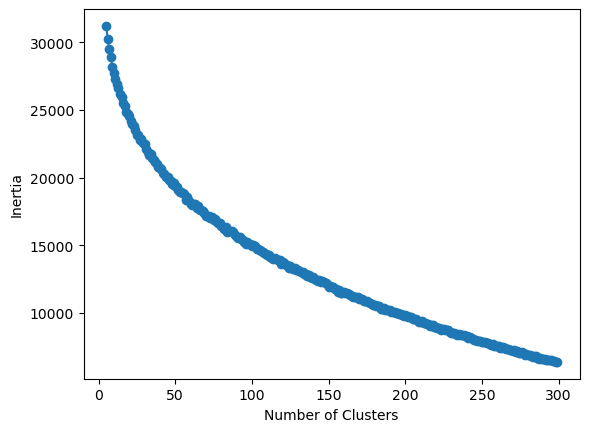

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

trials = []
num_clusters = range(5,300)

for i in tqdm(num_clusters):
    km = KMeans(n_clusters=i, 
           max_iter=300, 
           tol=0.0001, 
           random_state=42,
            verbose=1)
    km.fit(X)
    trials.append(km.inertia_)
    
plt.plot(num_clusters, trials, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [22]:
km.labels_

array([ 10, 279, 104, 154,  48, 154,  23,  34,  69, 103,  74,  53, 168,
        19,  82,   4, 103,  94,  35, 160,  12,   3, 103,  51, 199, 161,
       143,  47,  29,  67,  67, 181,  31,  39, 259, 279,  29,  51,  15,
       154, 279,  27, 111,   0, 212,  82, 178,  48,  51,  63, 110, 165,
        12,   0, 103,  47,  17,  48,  19, 111, 228, 201, 118,  17,  32,
       185,  76,  88, 124, 120,  48, 249,  41, 165, 154, 199,   6,  80,
         5, 298, 118, 151,  90, 175, 269,  10, 222, 120,  71,  15,  37,
       221,  42, 250, 192, 226,  82,  23, 131, 119,   1, 103,  23,  18,
       100,  21,   7, 286,  14,  61,  75,  43, 232, 276,  12,  75,  30,
       142, 154,  82,  87, 100,  82,  28, 217, 262,  95, 282,  12, 176,
       272, 174, 120,  41, 234,  82, 106,  54,  11, 283, 293, 251,  37,
       246, 219, 249,  51, 154,  16,  48, 212,  90,  78,   8, 156,  10,
       243, 239, 287, 288,  39, 182,   7, 121, 216,  33,  42, 266,  90,
        37,  98,  34, 199,  67, 180, 176, 130, 183, 184,  87, 13